## Loading the Data

In [ ]:
ls

drive/  sample_data/


In [ ]:
cd /content/drive/MyDrive/Master/code_base/dataset/multiclass_classification

/content/drive/MyDrive/Master/code_base/dataset/multiclass_classification


In [ ]:
ls

broken_stitch/             hole/                seam_puckering/
cnn_model_mc.pth           improved_cnn_mc.pth  skip_stitch/
cnn_multi_model.onnx       output/              uncut_thread/
cnn_multi_new_model.onnx   raw_edge/
efficientnet_model_mc.pth  resnet_model_mc.pth


In [ ]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch
import torchvision
import shutil
import torchvision.models as models
from tqdm import tqdm
from PIL import Image, ImageEnhance
from torchvision import datasets
from torch.utils.data import DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import torch.onnx
import seaborn as sns

In [ ]:
data_dir = '/content/drive/MyDrive/Master/code_base/dataset/multiclass_classification'
output_dir = '/content/drive/MyDrive/Master/code_base/dataset/multiclass_classification/output'

In [ ]:

hole = os.path.join(data_dir, "hole")
broken_stitch = os.path.join(data_dir, "broken_stitch")
raw_edge = os.path.join(data_dir, "raw_edge")
seams = os.path.join(data_dir,"seam_puckering")
skip_stitch = os.path.join(data_dir, "skip_stitch")
uncut_thread = os.path.join(data_dir, "uncut_thread")

print("Number of Hole Images:", len(os.listdir(hole)))
print("Number of Broken Stitches Images:", len(os.listdir(broken_stitch)))
print("Number of Raw Edges Images:", len(os.listdir(raw_edge)))
print("Number of Seam Puckering Images:", len(os.listdir(seams)))
print("Number of Skip Stitches Images:", len(os.listdir(skip_stitch)))
print("Number of Uncut Thread Images:", len(os.listdir(uncut_thread)))

Number of Hole Images: 82
Number of Broken Stitches Images: 84
Number of Raw Edges Images: 56
Number of Seam Puckering Images: 91
Number of Skip Stitches Images: 48
Number of Uncut Thread Images: 62


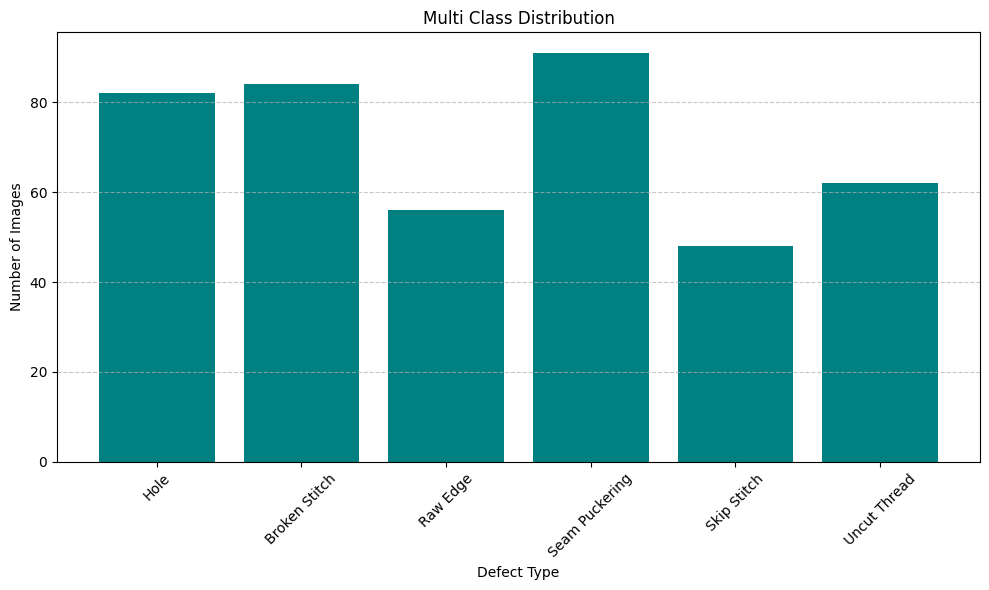

In [ ]:
# Class directories
classes = {
    "Hole": os.path.join(data_dir, "hole"),
    "Broken Stitch": os.path.join(data_dir, "broken_stitch"),
    "Raw Edge": os.path.join(data_dir, "raw_edge"),
    "Seam Puckering": os.path.join(data_dir, "seam_puckering"),
    "Skip Stitch": os.path.join(data_dir, "skip_stitch"),
    "Uncut Thread": os.path.join(data_dir, "uncut_thread"),
}

# Count images in each class
image_counts = {label: len(os.listdir(path)) for label, path in classes.items()}

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values(), color='teal')
plt.title('Multi Class Distribution')
plt.xlabel('Defect Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Understanding the dataset

Hole Images:


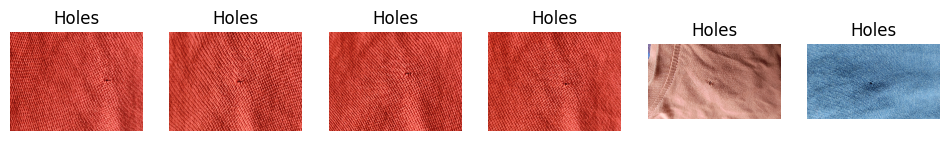

Broken Stitch Images:


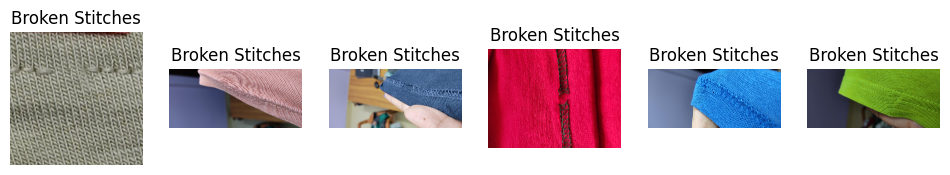

Raw Edges Images:


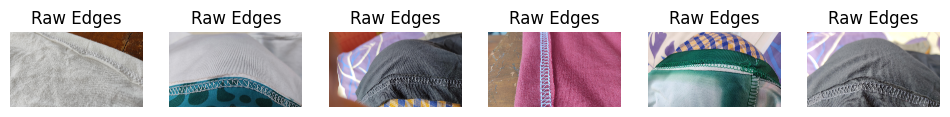

Seam Puckering Images:


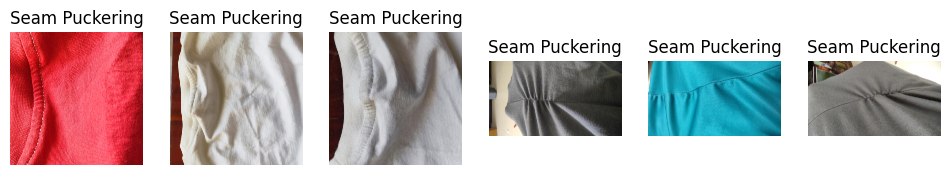

Skip Stitches Images:


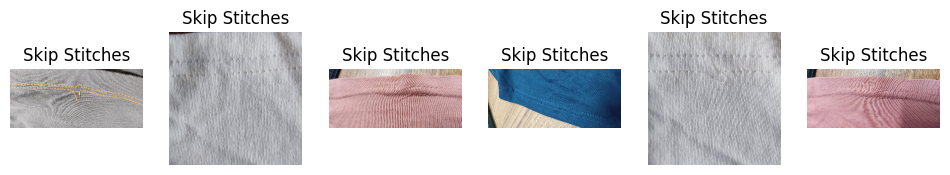

Uncut Thread Images:


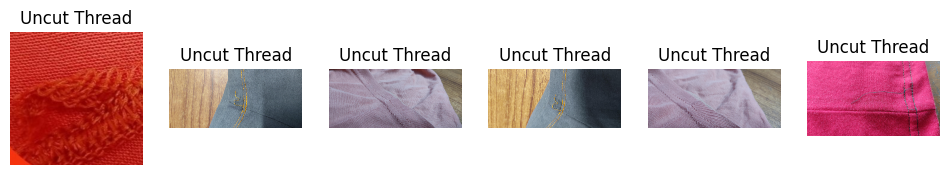

In [ ]:
# Load the file names from both directories
hole_dir = os.path.join(data_dir, "hole")
broken_stitch_dir = os.path.join(data_dir, "broken_stitch")
raw_edge_dir = os.path.join(data_dir, "raw_edge")
seams_dir = os.path.join(data_dir,"seam_puckering")
skip_stitch_dir = os.path.join(data_dir, "skip_stitch")
uncut_thread_dir = os.path.join(data_dir, "uncut_thread")

hole_images = os.listdir(hole_dir)
broken_stitch_images = os.listdir(broken_stitch_dir)
raw_edge_images = os.listdir(raw_edge_dir)
seams_images = os.listdir(seams_dir)
skip_stitch_images = os.listdir(skip_stitch_dir)
uncut_thread_images = os.listdir(uncut_thread_dir)
# ... (load other image lists similarly)

# Function to display images
def display_images(image_list, image_dir, label, num_images=6):
    plt.figure(figsize=(12, 6))
    for i, image_name in enumerate(image_list[:num_images]):
        img_path = os.path.join(image_dir, image_name)
        img = cv2.imread(img_path)
        # Check if image was loaded correctly
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_images, i+1)
            plt.imshow(img)
            plt.title(f"{label}")
            plt.axis('off')
        else:
            print(f"Failed to load image: {img_path}")  # Print an error message
    plt.show()

#Display Images
print("Hole Images:")
display_images(hole_images, hole_dir, label="Holes")
print("Broken Stitch Images:")
display_images(broken_stitch_images, broken_stitch_dir, label="Broken Stitches")
print("Raw Edges Images:")
display_images(raw_edge_images, raw_edge_dir, label="Raw Edges")
print("Seam Puckering Images:")
display_images(seams_images, seams_dir, label="Seam Puckering")
print("Skip Stitches Images:")
display_images(skip_stitch_images, skip_stitch_dir, label="Skip Stitches")
print("Uncut Thread Images:")
display_images(uncut_thread_images, uncut_thread_dir, label="Uncut Thread")

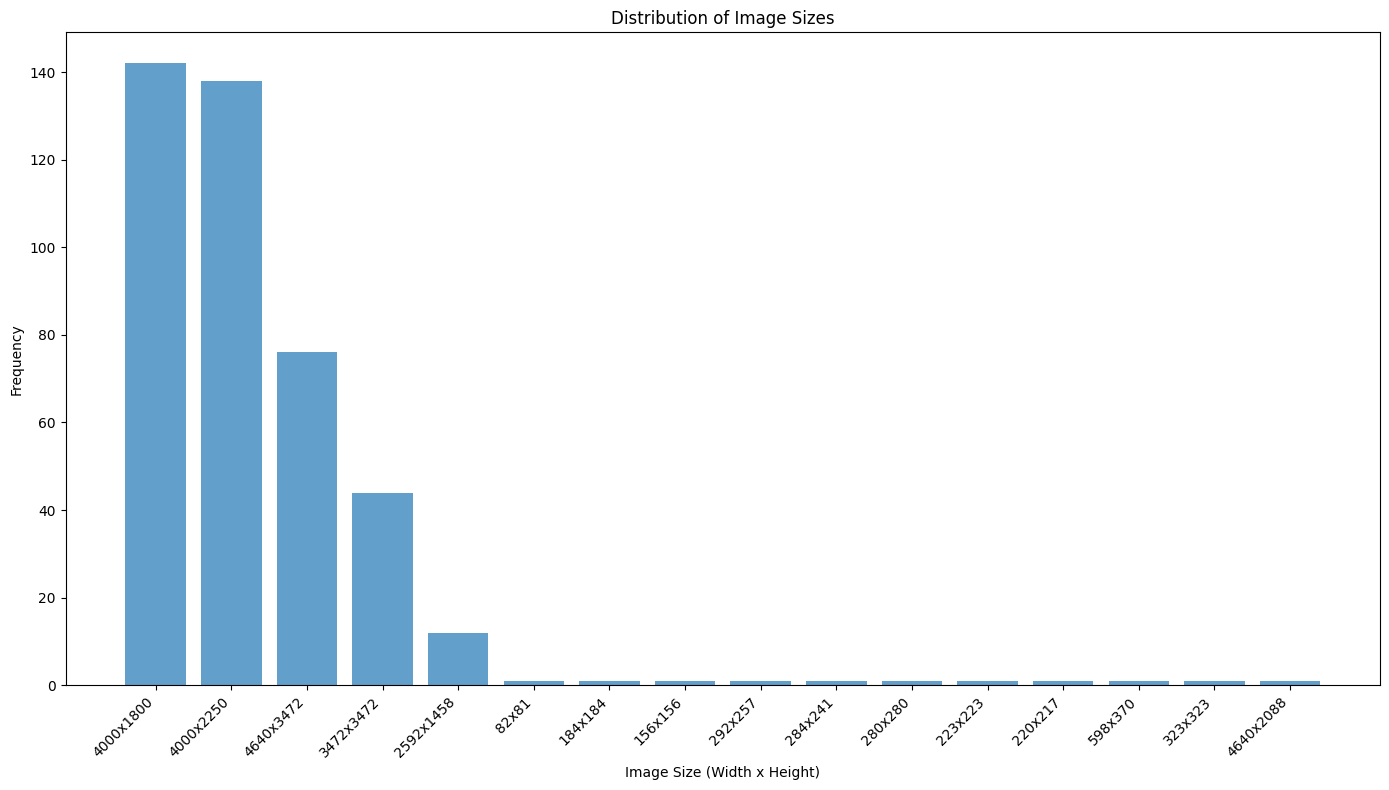

In [ ]:

# Combine image paths from multiple folders
def get_image_paths(folders):
    image_paths = []
    for folder in folders:
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            if os.path.isfile(file_path) and file_name.lower().endswith(('png', 'jpg', 'jpeg')):
                image_paths.append(file_path)
    return image_paths

# Collect image size information
def collect_image_sizes(image_paths):
    image_sizes = []
    for image_path in image_paths:
        with Image.open(image_path) as img:
            width, height = img.size
            image_sizes.append((width, height))
    return image_sizes

# Display the distribution of each image size
def display_image_size_distribution(image_sizes):
    # Convert list of tuples to DataFrame
    df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

    # Count occurrences of each unique size
    size_counts = df.value_counts().reset_index(name='Count')
    size_counts.rename(columns={0: 'Count'}, inplace=True)

    # Plot the distribution
    plt.figure(figsize=(14, 8))
    plt.bar(
        size_counts.index,
        size_counts['Count'],
        tick_label=[f"{w}x{h}" for w, h in size_counts[['Width', 'Height']].values],
        alpha=0.7
    )
    plt.xlabel("Image Size (Width x Height)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Image Sizes")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.tight_layout()
    plt.show()

# Example usage
folders = [hole_dir, broken_stitch_dir,raw_edge_dir,seams_dir,uncut_thread_dir,skip_stitch_dir]  # Use your defined folder paths
image_paths = get_image_paths(folders)
image_sizes = collect_image_sizes(image_paths)
display_image_size_distribution(image_sizes)


## Splitting

In [ ]:

# # Class folders
# class_dirs = {
#     "hole": os.path.join(data_dir, "hole"),
#     "broken_stitch": os.path.join(data_dir, "broken_stitch"),
#     "raw_edge": os.path.join(data_dir, "raw_edge"),
#     "seam_puckering": os.path.join(data_dir, "seam_puckering"),
#     "skip_stitch": os.path.join(data_dir, "skip_stitch"),
#     "uncut_thread": os.path.join(data_dir, "uncut_thread")
# }

# # Train, Val, Test split percentages
# train_ratio = 0.8
# val_ratio = 0.1
# test_ratio = 0.1

# # Create output directories
# for split in ["train", "val", "test"]:
#     for class_name in class_dirs.keys():
#         os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# # Function to split and copy files
# def split_and_copy(class_name, class_path):
#     images = os.listdir(class_path)
#     random.shuffle(images)  # Shuffle to ensure randomness

#     total_images = len(images)
#     train_count = int(total_images * train_ratio)
#     val_count = int(total_images * val_ratio)
#     test_count = total_images - train_count - val_count

#     train_images = images[:train_count]
#     val_images = images[train_count:train_count + val_count]
#     test_images = images[train_count + val_count:]

#     # Copy images to respective folders
#     for img in train_images:
#         shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, "train", class_name, img))

#     for img in val_images:
#         shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, "val", class_name, img))

#     for img in test_images:
#         shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, "test", class_name, img))

# # Split dataset
# for class_name, class_path in class_dirs.items():
#     split_and_copy(class_name, class_path)

# print("Dataset split completed!")


In [ ]:

# Function to count images in each directory
def count_images(directory):
    class_counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
    return class_counts

# Count images in each split
for split in ["train", "val", "test"]:
    split_path = os.path.join(output_dir, split)
    counts = count_images(split_path)

    print(f"\n📂 {split.upper()} Dataset:")
    for class_name, num_images in counts.items():
        print(f"  - {class_name}: {num_images} images")



📂 TRAIN Dataset:
  - broken_stitch: 67 images
  - hole: 65 images
  - raw_edge: 44 images
  - seam_puckering: 72 images
  - skip_stitch: 38 images
  - uncut_thread: 49 images

📂 VAL Dataset:
  - broken_stitch: 8 images
  - hole: 8 images
  - raw_edge: 5 images
  - seam_puckering: 9 images
  - skip_stitch: 4 images
  - uncut_thread: 6 images

📂 TEST Dataset:
  - broken_stitch: 9 images
  - hole: 9 images
  - raw_edge: 7 images
  - seam_puckering: 10 images
  - skip_stitch: 6 images
  - uncut_thread: 7 images


## Transform

In [ ]:

dataset_path = "/content/drive/MyDrive/Master/code_base/dataset/multiclass_classification/output"

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "val"), transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "test"), transform=val_test_transform)

# Define DataLoaders
batch_size = 32  # Adjust based on memory constraints
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset stats
print(f"Train Dataset: {len(train_dataset)} images")
print(f"Validation Dataset: {len(val_dataset)} images")
print(f"Test Dataset: {len(test_dataset)} images")
print(f"Number of Classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")


Train Dataset: 335 images
Validation Dataset: 40 images
Test Dataset: 48 images
Number of Classes: 6
Classes: ['broken_stitch', 'hole', 'raw_edge', 'seam_puckering', 'skip_stitch', 'uncut_thread']


## Vizualize the loaders

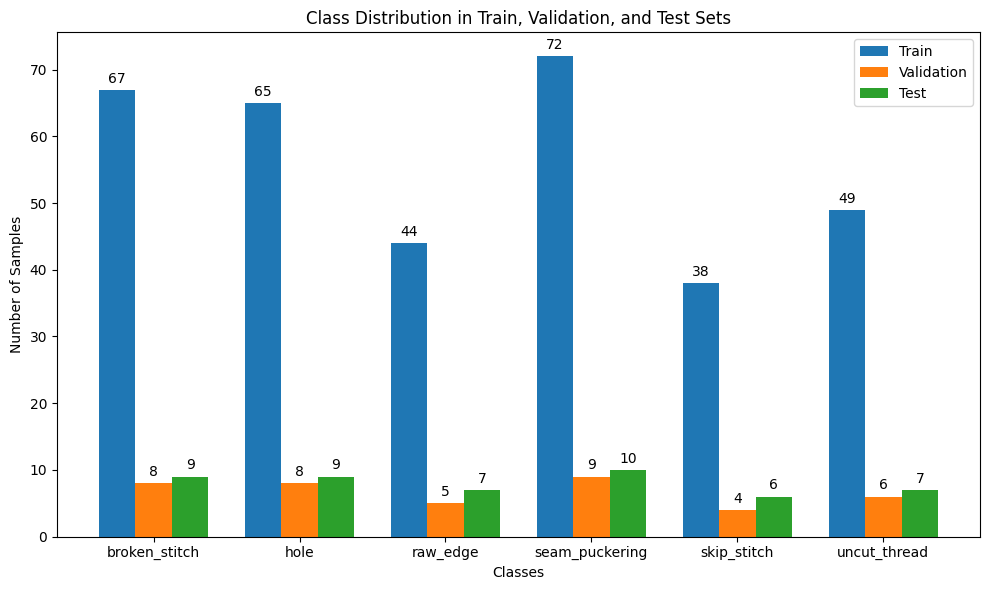

In [ ]:

def get_class_distribution(loader):
    """Helper function to get the class distribution from a DataLoader."""
    class_counts = Counter()
    for _, labels in loader:
        class_counts.update(labels.numpy())  # Update counter with the labels
    return class_counts

def plot_class_distribution(train_loader, valid_loader, test_loader, class_names = ['broken_stitch', 'hole', 'raw_edge', 'seam_puckering', 'skip_stitch', 'uncut_thread']):
    """Plot the class distribution for each dataset."""

    # Get class distributions from each loader
    train_counts = get_class_distribution(train_loader)
    valid_counts = get_class_distribution(valid_loader)
    test_counts = get_class_distribution(test_loader)

    # Convert counters to lists of class counts
    train_counts_list = [train_counts[i] for i in range(len(class_names))]
    valid_counts_list = [valid_counts[i] for i in range(len(class_names))]
    test_counts_list = [test_counts[i] for i in range(len(class_names))]

    # Plot the class distributions
    labels = class_names
    x = np.arange(len(labels))  # Label locations

    width = 0.25  # Width of the bars
    fig, ax = plt.subplots(figsize=(10, 6))

    rects1 = ax.bar(x - width, train_counts_list, width, label='Train')
    rects2 = ax.bar(x, valid_counts_list, width, label='Validation')
    rects3 = ax.bar(x + width, test_counts_list, width, label='Test')

    # Add some text for labels, title and axes ticks
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Class Distribution in Train, Validation, and Test Sets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Attach a text label above each bar, displaying its height
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    plt.tight_layout()
    plt.show()

# Visualize the class balances in each DataLoader
plot_class_distribution(train_loader, valid_loader, test_loader, class_names=['broken_stitch', 'hole', 'raw_edge', 'seam_puckering', 'skip_stitch', 'uncut_thread'])


Train Test

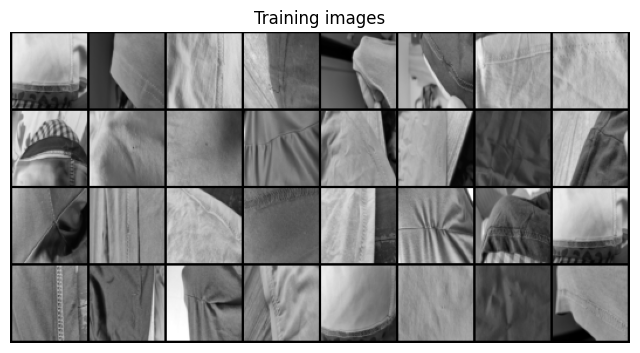

In [ ]:
train_batch = next(iter(train_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(
    np.transpose(
        vutils.make_grid(train_batch[0][:64], padding=2, normalize=True), (1, 2, 0)
    )
)
plt.show()

Test Test

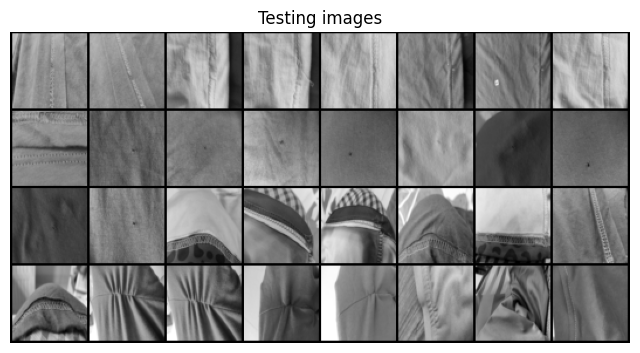

In [ ]:
test_batch = next(iter(test_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Testing images")
plt.imshow(
    np.transpose(
        vutils.make_grid(test_batch[0][:64], padding=2, normalize=True), (1, 2, 0)
    )
)
plt.show()

Valid Images

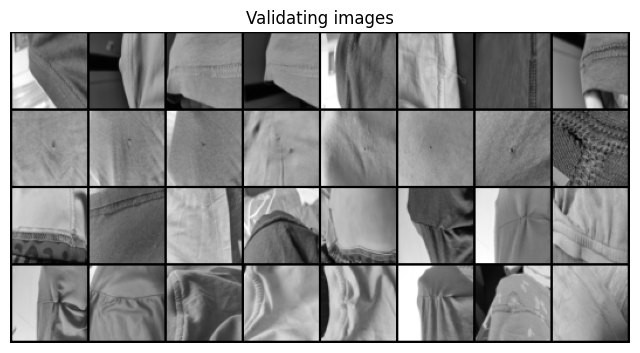

In [ ]:
valid_batch = next(iter(valid_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Validating images")
plt.imshow(
    np.transpose(
        vutils.make_grid(valid_batch[0][:64], padding=2, normalize=True), (1, 2, 0)
    )
)
plt.show()

# Models

## Intial Model

In [ ]:

class DefectCNN(nn.Module):
    def __init__(self, num_classes):
        super(DefectCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input: (1,64,64) → Output: (32,64,64)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Output: (64,32,32)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Output: (128,16,16)

        self.pool = nn.MaxPool2d(2, 2)  # Reduce feature map size by half
        self.dropout = nn.Dropout(0.4)

        self.fc1 = nn.Linear(128 * 8 * 8, 256)  # Fully connected layer
        self.fc2 = nn.Linear(256, num_classes)  # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 128 * 8 * 8)  # Flatten feature maps
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(train_dataset.classes)
model_intial_model = DefectCNN(num_classes).to(device)

criterion_intial_model = nn.CrossEntropyLoss()
optimizer_intial_model = optim.Adam(model_intial_model.parameters(), lr=0.001)


### Model Export

In [ ]:
sample_input, _ = next(iter(train_loader))

# Use only one sample or the entire batch depending on your use case
sample_input = sample_input.to(device)
onnx_file_path = "cnn_multi_model.onnx"
# Run the model once to initialize dynamic layers
model(sample_input)

# Export to ONNX using the sample_input
torch.onnx.export(
    model,
    sample_input,  # Use real data instead of random tensor
    onnx_file_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print(f"✅ Model exported to: {os.path.abspath(onnx_file_path)}")

KeyboardInterrupt: 

## Improved Model

In [ ]:

class ImprovedDefectCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedDefectCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)  # Larger kernel for more spatial features
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)  # Downsampling
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)

        self.dropout = nn.Dropout(0.5)  # Higher dropout to reduce overfitting

        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))

        x = x.view(-1, 256 * 8 * 8)  # Flattening
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)  # Update with your dataset
model_improved = ImprovedDefectCNN(num_classes).to(device)

# Loss function
criterion_improved_model = nn.CrossEntropyLoss()

# Optimizer with weight decay to reduce overfitting
optimizer_improved_model = optim.Adam(model_improved.parameters(), lr=0.0001, weight_decay=1e-4)


### Model Export

In [ ]:
sample_input, _ = next(iter(train_loader))

# Use only one sample or the entire batch depending on your use case
sample_input = sample_input.to(device)
onnx_file_path = "cnn_multi_new_model.onnx"
# Run the model once to initialize dynamic layers
model_improved(sample_input)

# Export to ONNX using the sample_input
torch.onnx.export(
    model_improved,
    sample_input,  # Use real data instead of random tensor
    onnx_file_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print(f"✅ Model exported to: {os.path.abspath(onnx_file_path)}")

✅ Model exported to: /content/drive/MyDrive/Master/code_base/dataset/multiclass_classification/cnn_multi_new_model.onnx


## Transfer Learning - EfficientNet_B0

In [ ]:
def efficientnet_model(num_classes):
    model = models.efficientnet_b0(pretrained=True)


    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)
model_efficient = efficientnet_model(num_classes)
model_efficient.to(device)
print(model_efficient)
criterion_efficient = nn.CrossEntropyLoss()
optimizer_efficient = torch.optim.Adam(model_efficient .parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 112MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Transfer Learning - Resnet 18

In [ ]:
def build_resnet18_model(num_classes):
    model = models.resnet18(pretrained=True)

    # Modify first conv layer to accept 1-channel input
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Replace classifier (fc)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)


model_resnet = build_resnet18_model(num_classes)
model_resnet.to(device)
print(model_resnet)

# Optimizer and Loss
criterion_restnet = nn.CrossEntropyLoss()
optimizer_restnet = torch.optim.Adam(model_resnet.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Model Testing with Grad CAM Viz

## Train Validator Function

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._clear_hooks()
        self._register_hooks()

    def _clear_hooks(self):
        if hasattr(self.target_layer, '_backward_hooks'):
            self.target_layer._backward_hooks.clear()
        if hasattr(self.target_layer, '_full_backward_hooks'):
            self.target_layer._full_backward_hooks.clear()
        if hasattr(self.target_layer, '_forward_hooks'):
            self.target_layer._forward_hooks.clear()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        handle_forward = self.target_layer.register_forward_hook(forward_hook)
        handle_backward = self.target_layer.register_full_backward_hook(backward_hook)
        self.hook_handles.extend([handle_forward, handle_backward])

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def __call__(self, input_tensor, target_class=None):
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1

        self.model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)

        gradients = self.gradients
        activations = self.activations
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam.squeeze(0).cpu().numpy()

def get_gradcam_overlay(img_tensor, cam, cmap=cv2.COLORMAP_JET, alpha=0.5):
    # Convert tensor to NumPy array (H x W x C)
    img = img_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    img = np.uint8(255 * img)
    # Convert grayscale to 3 channels if needed
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Resize the CAM to match image size
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    # Apply colormap and convert to RGB
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cmap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    # Blend heatmap with original image
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlay

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).to(tensor.device)
    std = torch.tensor(std).to(tensor.device)
    if tensor.ndim == 4:
        mean = mean.view(1, -1, 1, 1)
        std = std.view(1, -1, 1, 1)
    else:
        mean = mean.view(-1, 1, 1)
        std = std.view(-1, 1, 1)
    return tensor * std + mean

# ----------------- Training Function -----------------

def train_model_with_metrics_tqdm(model, train_loader, valid_loader, criterion, optimizer, num_epochs=15, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    train_precisions, train_recalls, train_f1s = [], [], []
    valid_precisions, valid_recalls, valid_f1s = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        all_train_labels, all_train_preds = [], []

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size
            _, predicted = torch.max(outputs, 1)
            total_train += batch_size
            correct_train += (predicted == labels).sum().item()

            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())

            avg_loss = running_loss / total_train
            avg_acc = 100 * correct_train / total_train
            train_bar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{avg_acc:.2f}%")

        train_loss = running_loss / total_train
        train_accuracy = 100 * correct_train / total_train
        train_precision = precision_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
        train_recall = recall_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)

        model.eval()
        valid_loss, correct_valid, total_valid = 0.0, 0, 0
        all_valid_labels, all_valid_preds = [], []

        valid_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False)
        with torch.no_grad():
            for images, labels in valid_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                batch_size = images.size(0)
                valid_loss += loss.item() * batch_size

                _, predicted = torch.max(outputs, 1)
                total_valid += batch_size
                correct_valid += (predicted == labels).sum().item()

                all_valid_labels.extend(labels.cpu().numpy())
                all_valid_preds.extend(predicted.cpu().numpy())

                avg_val_loss = valid_loss / total_valid
                avg_val_acc = 100 * correct_valid / total_valid
                valid_bar.set_postfix(loss=f"{avg_val_loss:.4f}", acc=f"{avg_val_acc:.2f}%")

        valid_loss = valid_loss / total_valid
        valid_accuracy = 100 * correct_valid / total_valid
        valid_precision = precision_score(all_valid_labels, all_valid_preds, average='weighted', zero_division=0)
        valid_recall = recall_score(all_valid_labels, all_valid_preds, average='weighted', zero_division=0)
        valid_f1 = f1_score(all_valid_labels, all_valid_preds, average='weighted', zero_division=0)

        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        valid_precisions.append(valid_precision)
        valid_recalls.append(valid_recall)
        valid_f1s.append(valid_f1)

        print(f'Epoch [{epoch+1}/{num_epochs}]:')
        print(f'  Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1: {train_f1:.2f}')
        print(f'  Validation Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.2f}%, Precision: {valid_precision:.2f}, Recall: {valid_recall:.2f}, F1: {valid_f1:.2f}')
        print('-' * 80)

        if (epoch + 1) % 5 == 0:
            try:
                if hasattr(train_loader.dataset, 'dataset') and hasattr(train_loader.dataset.dataset, 'classes'):
                    class_names = train_loader.dataset.dataset.classes
                elif hasattr(train_loader.dataset, 'classes'):
                    class_names = train_loader.dataset.classes
                else:
                    raise AttributeError
                num_classes = len(class_names)
            except AttributeError:
                class_names = ['broken_stitch', 'hole', 'raw_edge', 'seam_puckering', 'skip_stitch', 'uncut_thread']
                num_classes = len(class_names)

            model.eval()
            images_by_class = [[] for _ in range(num_classes)]
            for images, labels in valid_loader:
                for i in range(images.size(0)):
                    cls = labels[i].item()
                    images_by_class[cls].append(images[i:i+1].to(device))
            random_images_by_class = [random.choice(cls_list) if cls_list else None for cls_list in images_by_class]

            fig, axes = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))

            if num_classes == 1:
                axes = [axes]
            mean_vals = [0.485, 0.456, 0.406]
            std_vals = [0.229, 0.224, 0.225]
            for idx, sample_img in enumerate(random_images_by_class):
                if sample_img is not None:
                    sample_img_denorm = denormalize(sample_img.clone(), mean_vals, std_vals)
                    np_img = sample_img_denorm.squeeze(0).cpu().numpy().transpose(1, 2, 0)
                    np_img = np.clip(np_img, 0, 1)
                    axes[idx].imshow(np_img)
                    axes[idx].set_title(f"Input - {class_names[idx]}")
                    axes[idx].axis('off')
            plt.tight_layout()
            plt.show()

            if hasattr(model, 'conv3'):
                target_layer = model.conv3
            else:
                conv_layers = [m for m in model.modules() if isinstance(m, nn.Conv2d)]
                target_layer = conv_layers[-1]

            gradcam = GradCAM(model, target_layer)
            fig, axes = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))
            if num_classes == 1:
                axes = [axes]
            for cls_idx, sample_img in enumerate(random_images_by_class):
                if sample_img is not None:
                    cam = gradcam(sample_img)
                    overlay = get_gradcam_overlay(sample_img, cam)
                    axes[cls_idx].imshow(overlay)
                    axes[cls_idx].set_title(f"Grad-CAM - {class_names[cls_idx]}")
                    axes[cls_idx].axis('off')
            plt.tight_layout()
            plt.show()
            gradcam.remove_hooks()

    # Plotting
    def plot_metric(metric, name, ylabel):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, num_epochs + 1), metric[0], label='Train', color='blue')
        plt.plot(range(1, num_epochs + 1), metric[1], label='Validation', color='green')
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.title(f'Training and Validation {ylabel}')
        plt.legend()
        plt.show()

    plot_metric((train_losses, valid_losses), 'Loss', 'Loss')
    plot_metric((train_accuracies, valid_accuracies), 'Accuracy', 'Accuracy (%)')
    plot_metric((train_precisions, valid_precisions), 'Precision', 'Precision')
    plot_metric((train_recalls, valid_recalls), 'Recall', 'Recall')
    plot_metric((train_f1s, valid_f1s), 'F1 Score', 'F1 Score')


## Test Validator Function

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_multiple_models_with_gradcam(models, model_names, test_loader, class_names, device="cuda" if torch.cuda.is_available() else "cpu", num_samples=5):
    assert len(models) == len(model_names), "Mismatch between models and names"

    # Sample for Grad-CAM
    sample_images, sample_labels = [], []
    for images, labels in test_loader:
        for i in range(images.size(0)):
            sample_images.append(images[i:i+1])
            sample_labels.append(labels[i].item())
            if len(sample_images) >= num_samples:
                break
        if len(sample_images) >= num_samples:
            break

    for model, name in zip(models, model_names):
        model.to(device)
        model.eval()

        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Classification Metrics
        acc = accuracy_score(all_labels, all_preds) * 100
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        print(f"\n📊 Results for: {name}")
        print(f"   Accuracy  : {acc:.2f}%")
        print(f"   Precision : {precision:.4f}")
        print(f"   Recall    : {recall:.4f}")
        print(f"   F1 Score  : {f1:.4f}")
        print("   Classification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - {name}")
        plt.show()

        # Grad-CAM Setup
        print(f"\n🧠 Grad-CAM Visualizations for {name}")
        if hasattr(model, 'conv3'):
            target_layer = model.conv3
        else:
            conv_layers = [m for m in model.modules() if isinstance(m, nn.Conv2d)]
            target_layer = conv_layers[-1]

        gradcam = GradCAM(model, target_layer)
        fig, axes = plt.subplots(2, num_samples, figsize=(5 * num_samples, 10))

        for i in range(num_samples):
            input_img = sample_images[i].to(device)
            true_label = class_names[sample_labels[i]]

            with torch.no_grad():
                output = model(input_img)
                pred_idx = output.argmax(dim=1).item()
                pred_label = class_names[pred_idx]

            # Generate Grad-CAM
            cam = gradcam(input_img, target_class=pred_idx)


            # Prepare overlay
            cam_resized = Image.fromarray(np.uint8(cam * 255)).resize((64, 64), resample=Image.BILINEAR)
            overlay = cam_resized

            # Convert grayscale image to numpy
            np_img = input_img.squeeze().cpu().numpy()

            # Plot original
            axes[0, i].imshow(np_img, cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title(f"Original\nTrue: {true_label}", fontsize=10)

            # Plot Grad-CAM
            axes[1, i].imshow(np_img, cmap='gray')
            axes[1, i].imshow(overlay, cmap='jet', alpha=0.5)
            axes[1, i].axis('off')
            axes[1, i].set_title(f"Grad-CAM\nPred: {pred_label}", fontsize=10)

        plt.suptitle(f"Grad-CAM and Input Visualization for {name}", fontsize=14)
        plt.tight_layout()
        plt.show()
        gradcam.remove_hooks()


# Test Results

## Intial Model

Epoch [1/30]:
  Training Loss: 1.7866, Accuracy: 19.10%, Precision: 0.22, Recall: 0.19, F1: 0.15
  Validation Loss: 1.6905, Accuracy: 37.50%, Precision: 0.35, Recall: 0.38, F1: 0.26
--------------------------------------------------------------------------------


Epoch [2/30]:
  Training Loss: 1.6226, Accuracy: 34.33%, Precision: 0.43, Recall: 0.34, F1: 0.31
  Validation Loss: 1.4907, Accuracy: 55.00%, Precision: 0.55, Recall: 0.55, F1: 0.51
--------------------------------------------------------------------------------


Epoch [3/30]:
  Training Loss: 1.3610, Accuracy: 50.75%, Precision: 0.51, Recall: 0.51, F1: 0.50
  Validation Loss: 1.3337, Accuracy: 57.50%, Precision: 0.71, Recall: 0.57, F1: 0.55
--------------------------------------------------------------------------------


Epoch [4/30]:
  Training Loss: 1.3001, Accuracy: 51.64%, Precision: 0.51, Recall: 0.52, F1: 0.50
  Validation Loss: 1.1934, Accuracy: 65.00%, Precision: 0.75, Recall: 0.65, F1: 0.64
--------------------------------------------------------------------------------


Epoch [5/30]:
  Training Loss: 1.0841, Accuracy: 61.79%, Precision: 0.63, Recall: 0.62, F1: 0.62
  Validation Loss: 1.0560, Accuracy: 67.50%, Precision: 0.70, Recall: 0.68, F1: 0.67
--------------------------------------------------------------------------------


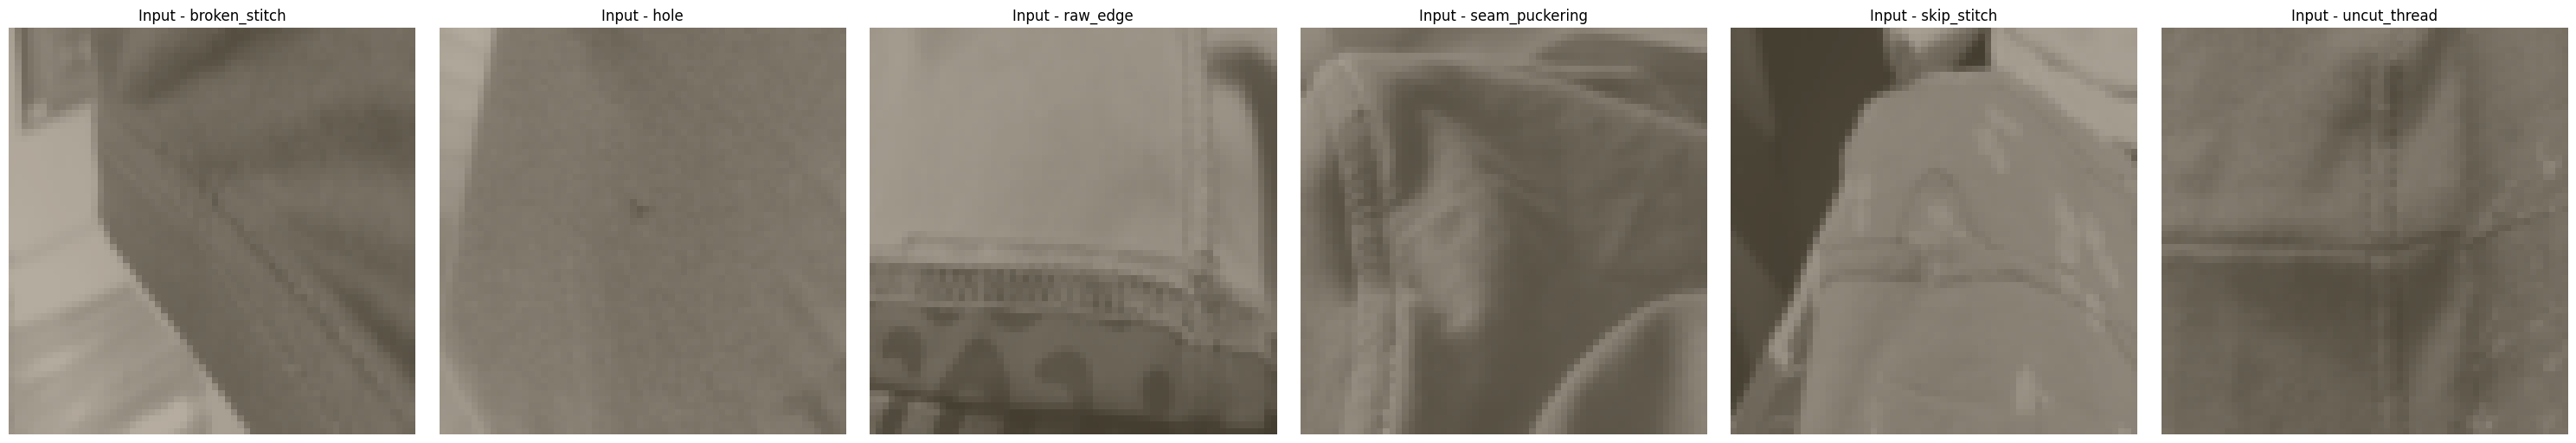

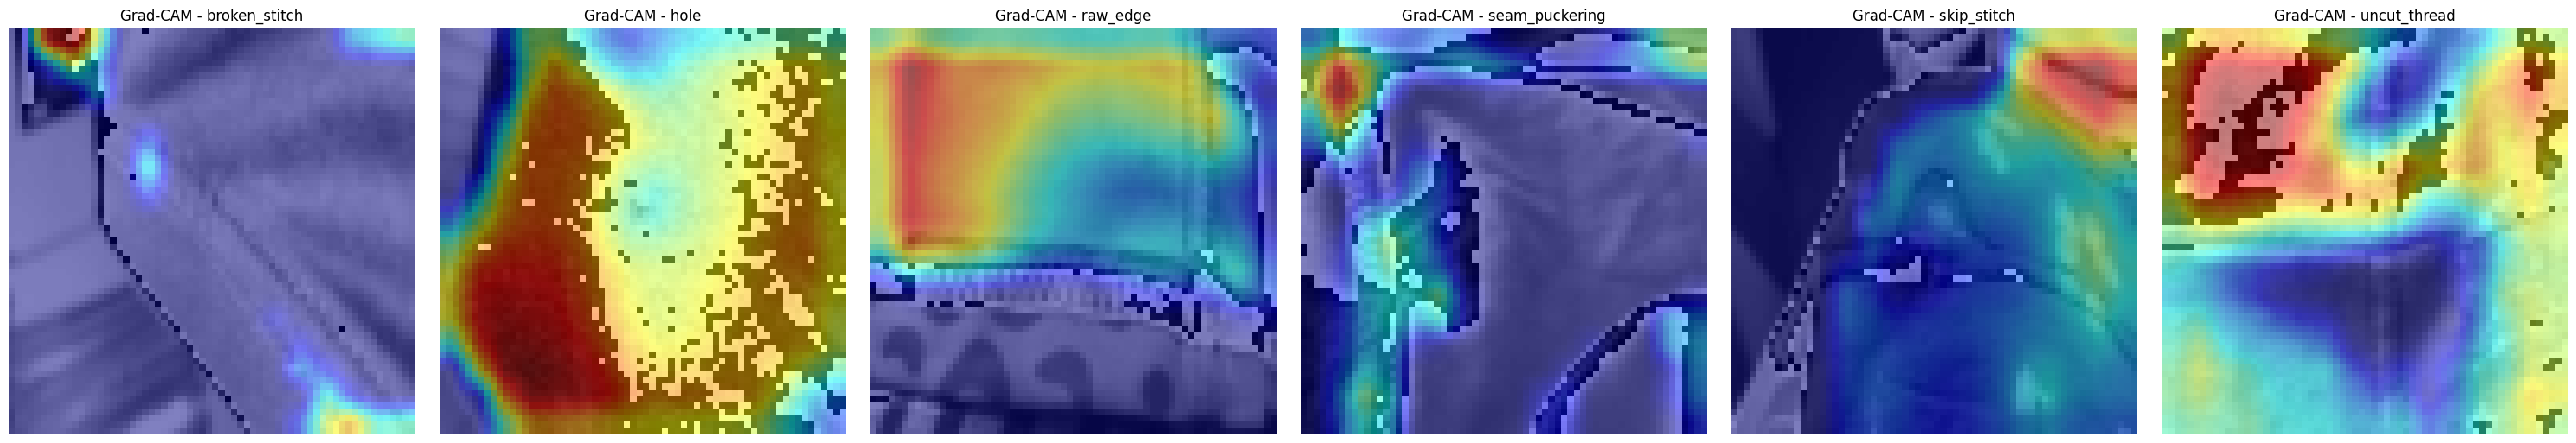

Epoch [6/30]:
  Training Loss: 0.9785, Accuracy: 65.07%, Precision: 0.66, Recall: 0.65, F1: 0.64
  Validation Loss: 1.0344, Accuracy: 65.00%, Precision: 0.74, Recall: 0.65, F1: 0.64
--------------------------------------------------------------------------------


Epoch [7/30]:
  Training Loss: 0.8167, Accuracy: 70.15%, Precision: 0.71, Recall: 0.70, F1: 0.70
  Validation Loss: 0.7483, Accuracy: 77.50%, Precision: 0.81, Recall: 0.78, F1: 0.77
--------------------------------------------------------------------------------


Epoch [8/30]:
  Training Loss: 0.6549, Accuracy: 77.31%, Precision: 0.78, Recall: 0.77, F1: 0.77
  Validation Loss: 0.7101, Accuracy: 80.00%, Precision: 0.84, Recall: 0.80, F1: 0.79
--------------------------------------------------------------------------------


Epoch [9/30]:
  Training Loss: 0.5455, Accuracy: 78.51%, Precision: 0.79, Recall: 0.79, F1: 0.79
  Validation Loss: 0.6590, Accuracy: 85.00%, Precision: 0.87, Recall: 0.85, F1: 0.84
--------------------------------------------------------------------------------


Epoch [10/30]:
  Training Loss: 0.5030, Accuracy: 80.90%, Precision: 0.82, Recall: 0.81, F1: 0.81
  Validation Loss: 0.6174, Accuracy: 85.00%, Precision: 0.89, Recall: 0.85, F1: 0.85
--------------------------------------------------------------------------------


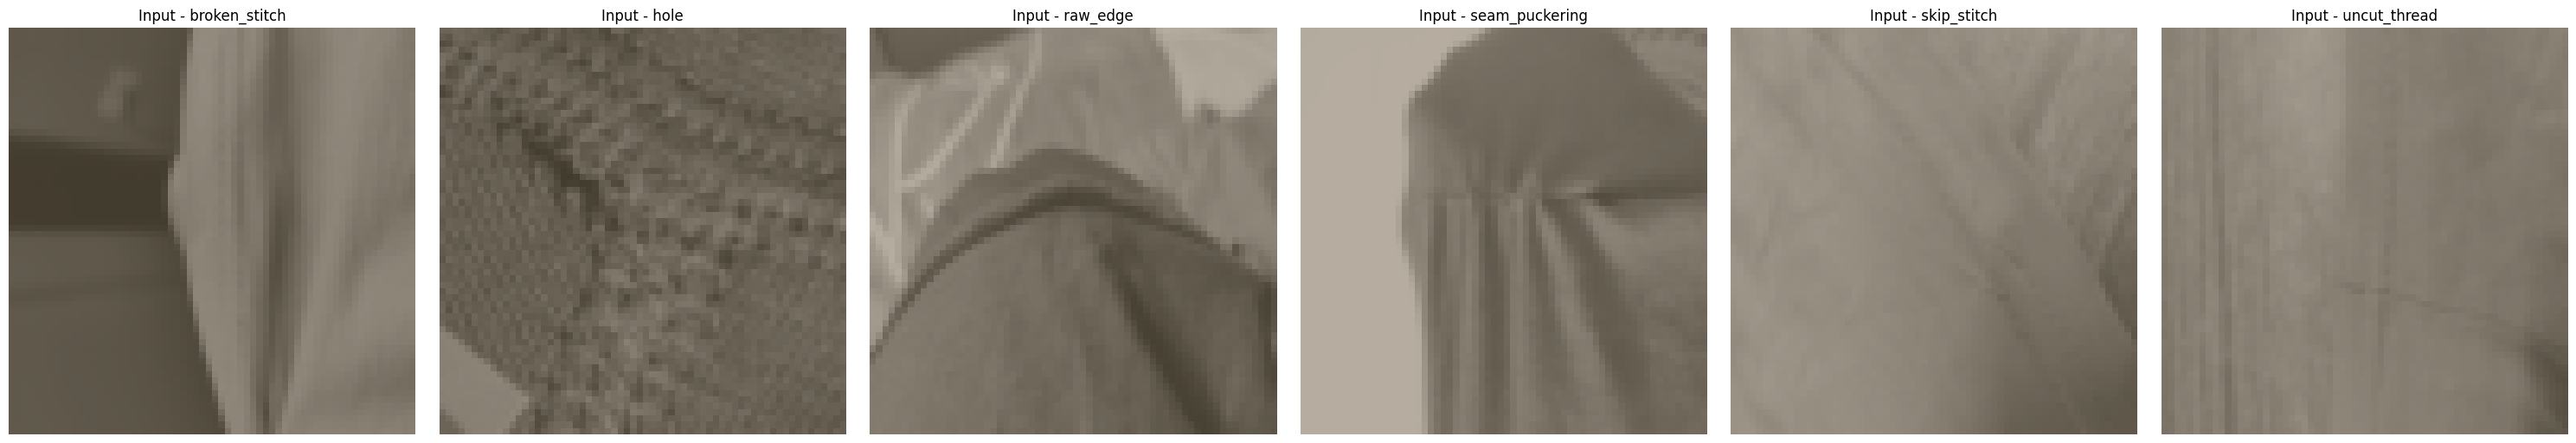

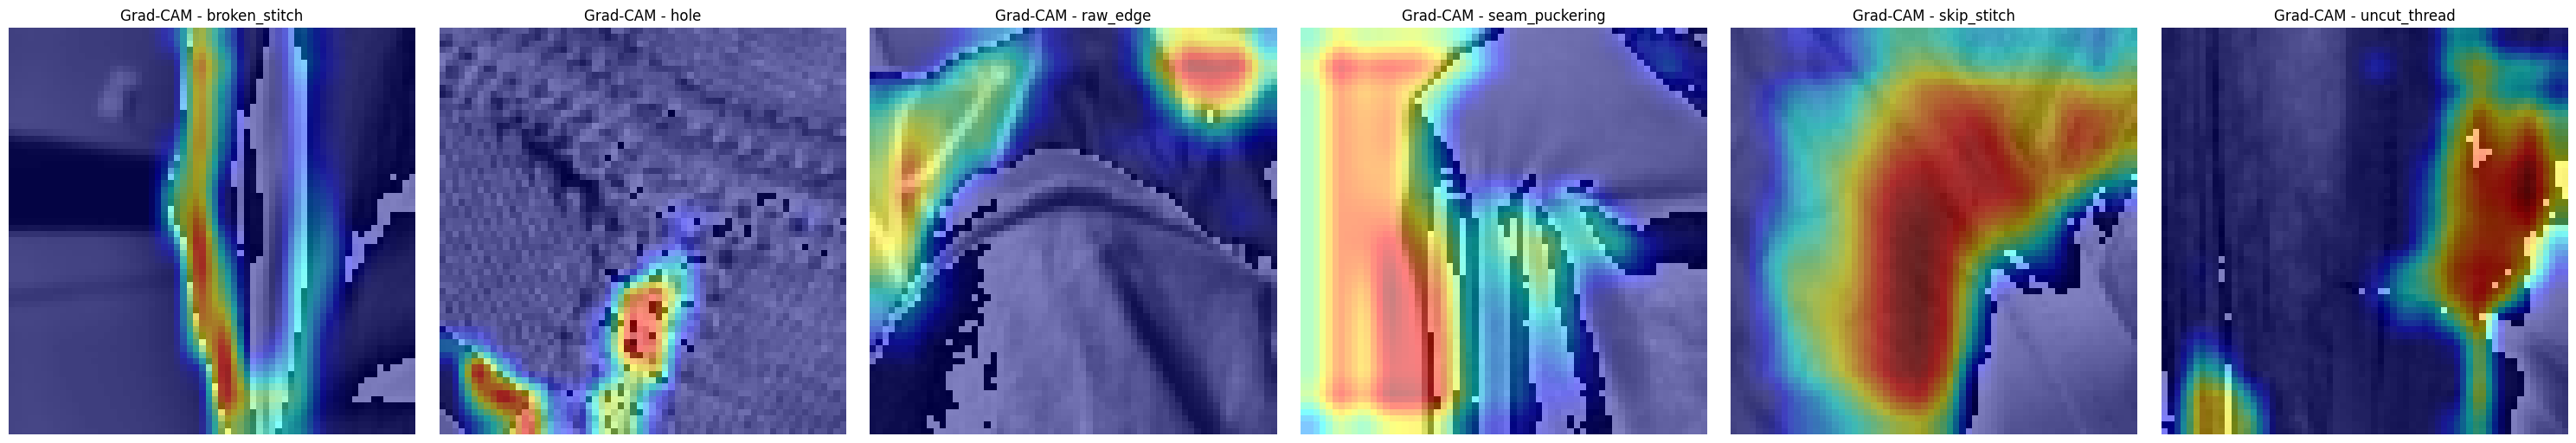

Epoch [11/30]:
  Training Loss: 0.3950, Accuracy: 86.87%, Precision: 0.87, Recall: 0.87, F1: 0.87
  Validation Loss: 0.5675, Accuracy: 87.50%, Precision: 0.89, Recall: 0.88, F1: 0.88
--------------------------------------------------------------------------------


Epoch [12/30]:
  Training Loss: 0.3444, Accuracy: 87.76%, Precision: 0.88, Recall: 0.88, F1: 0.88
  Validation Loss: 0.5274, Accuracy: 85.00%, Precision: 0.88, Recall: 0.85, F1: 0.85
--------------------------------------------------------------------------------


Epoch [13/30]:
  Training Loss: 0.3383, Accuracy: 87.76%, Precision: 0.88, Recall: 0.88, F1: 0.88
  Validation Loss: 0.5909, Accuracy: 82.50%, Precision: 0.86, Recall: 0.82, F1: 0.82
--------------------------------------------------------------------------------


Epoch [14/30]:
  Training Loss: 0.2592, Accuracy: 91.94%, Precision: 0.92, Recall: 0.92, F1: 0.92
  Validation Loss: 0.6717, Accuracy: 82.50%, Precision: 0.84, Recall: 0.82, F1: 0.82
--------------------------------------------------------------------------------


Epoch [15/30]:
  Training Loss: 0.1967, Accuracy: 93.43%, Precision: 0.94, Recall: 0.93, F1: 0.93
  Validation Loss: 0.5656, Accuracy: 85.00%, Precision: 0.86, Recall: 0.85, F1: 0.85
--------------------------------------------------------------------------------


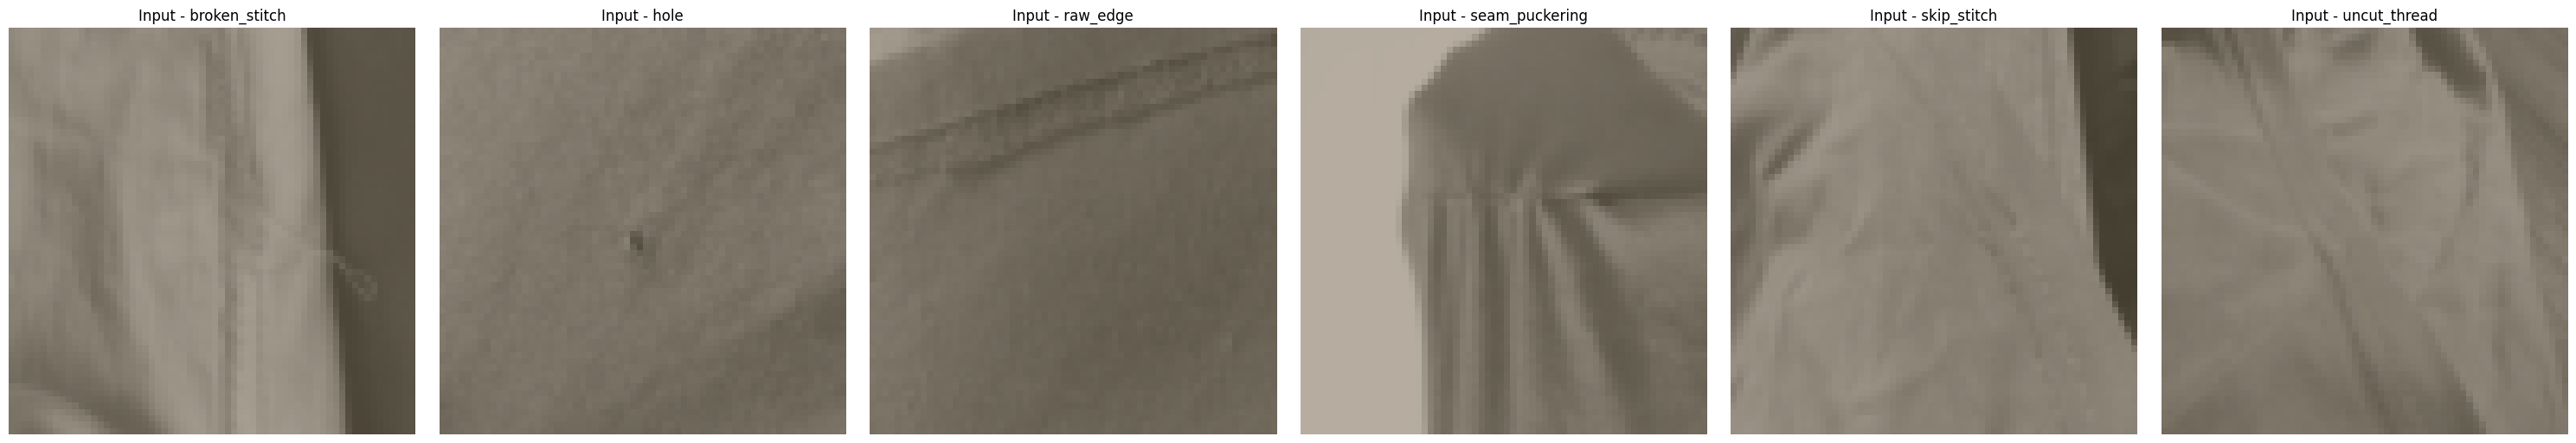

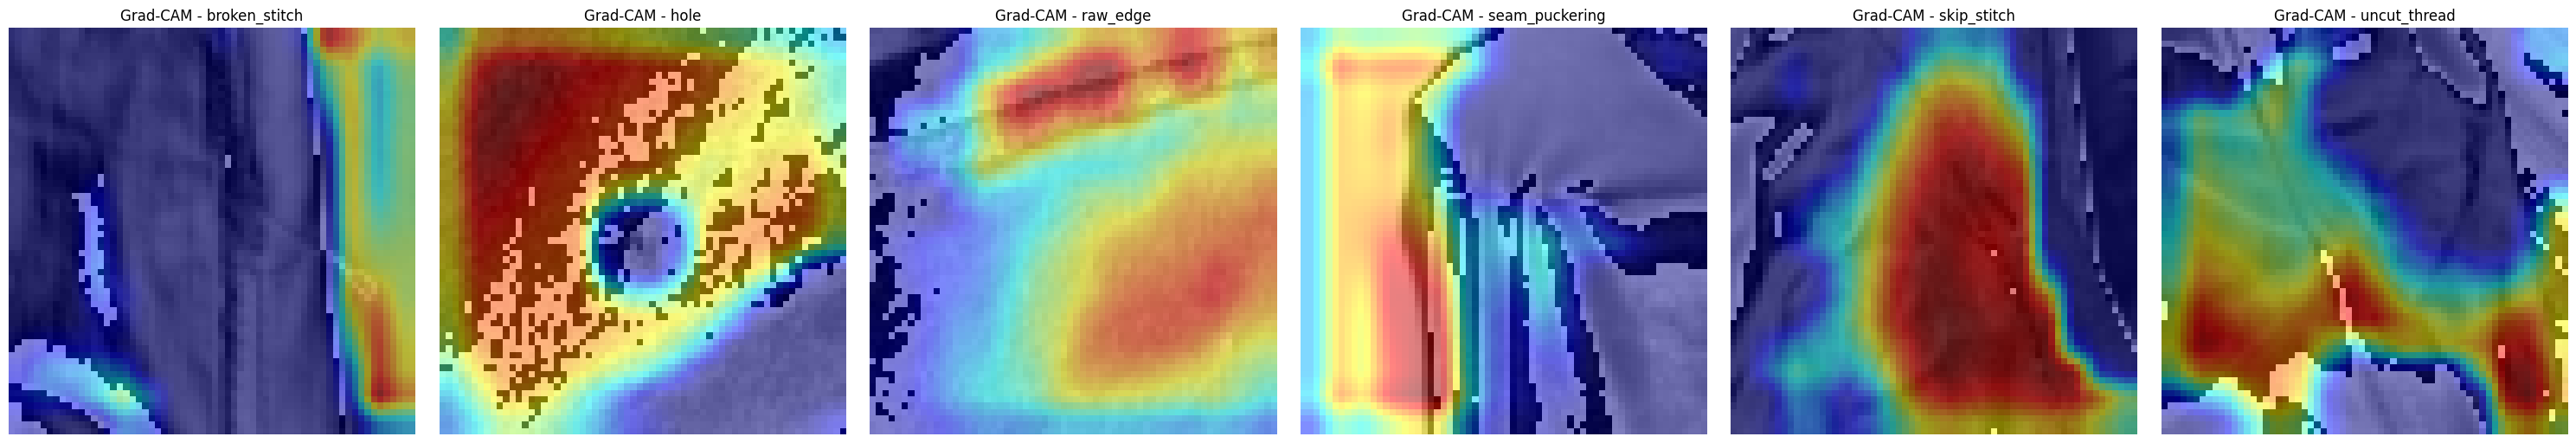

Epoch [16/30]:
  Training Loss: 0.1724, Accuracy: 94.33%, Precision: 0.95, Recall: 0.94, F1: 0.94
  Validation Loss: 0.5871, Accuracy: 85.00%, Precision: 0.87, Recall: 0.85, F1: 0.84
--------------------------------------------------------------------------------


Epoch [17/30]:
  Training Loss: 0.1675, Accuracy: 94.03%, Precision: 0.94, Recall: 0.94, F1: 0.94
  Validation Loss: 0.6731, Accuracy: 80.00%, Precision: 0.82, Recall: 0.80, F1: 0.80
--------------------------------------------------------------------------------


Epoch [18/30]:
  Training Loss: 0.1530, Accuracy: 93.73%, Precision: 0.94, Recall: 0.94, F1: 0.94
  Validation Loss: 0.6487, Accuracy: 85.00%, Precision: 0.86, Recall: 0.85, F1: 0.85
--------------------------------------------------------------------------------


Epoch [19/30]:
  Training Loss: 0.1361, Accuracy: 94.63%, Precision: 0.95, Recall: 0.95, F1: 0.95
  Validation Loss: 0.6042, Accuracy: 87.50%, Precision: 0.91, Recall: 0.88, F1: 0.88
--------------------------------------------------------------------------------


Epoch [20/30]:
  Training Loss: 0.1239, Accuracy: 95.82%, Precision: 0.96, Recall: 0.96, F1: 0.96
  Validation Loss: 0.8665, Accuracy: 87.50%, Precision: 0.90, Recall: 0.88, F1: 0.87
--------------------------------------------------------------------------------


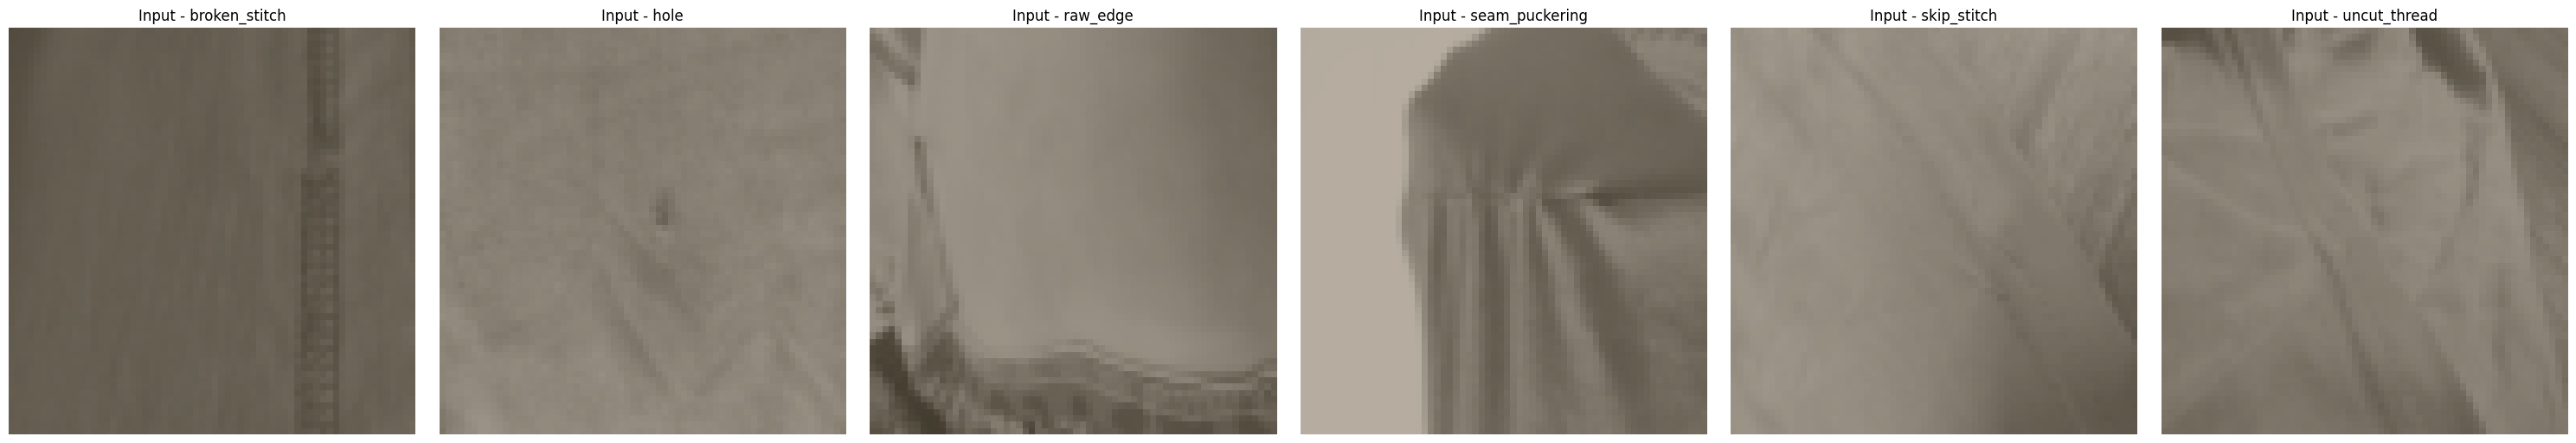

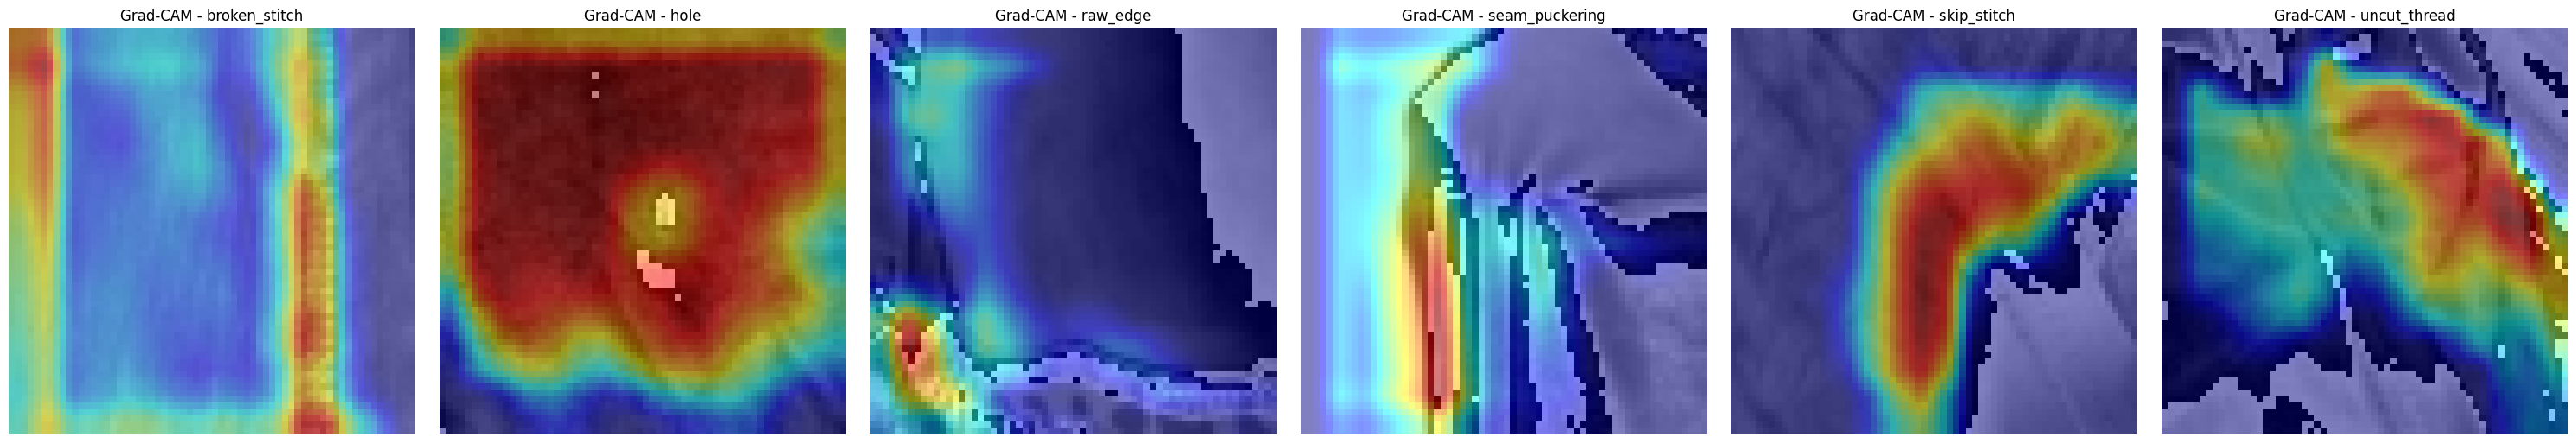

Epoch [21/30]:
  Training Loss: 0.0914, Accuracy: 97.31%, Precision: 0.97, Recall: 0.97, F1: 0.97
  Validation Loss: 0.8643, Accuracy: 80.00%, Precision: 0.84, Recall: 0.80, F1: 0.81
--------------------------------------------------------------------------------


Epoch [22/30]:
  Training Loss: 0.0640, Accuracy: 98.21%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.8115, Accuracy: 82.50%, Precision: 0.85, Recall: 0.82, F1: 0.83
--------------------------------------------------------------------------------


Epoch [23/30]:
  Training Loss: 0.0741, Accuracy: 98.21%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.9923, Accuracy: 82.50%, Precision: 0.87, Recall: 0.82, F1: 0.83
--------------------------------------------------------------------------------


Epoch [24/30]:
  Training Loss: 0.0663, Accuracy: 98.21%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.8728, Accuracy: 85.00%, Precision: 0.86, Recall: 0.85, F1: 0.85
--------------------------------------------------------------------------------


Epoch [25/30]:
  Training Loss: 0.0603, Accuracy: 97.61%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.9596, Accuracy: 90.00%, Precision: 0.91, Recall: 0.90, F1: 0.90
--------------------------------------------------------------------------------


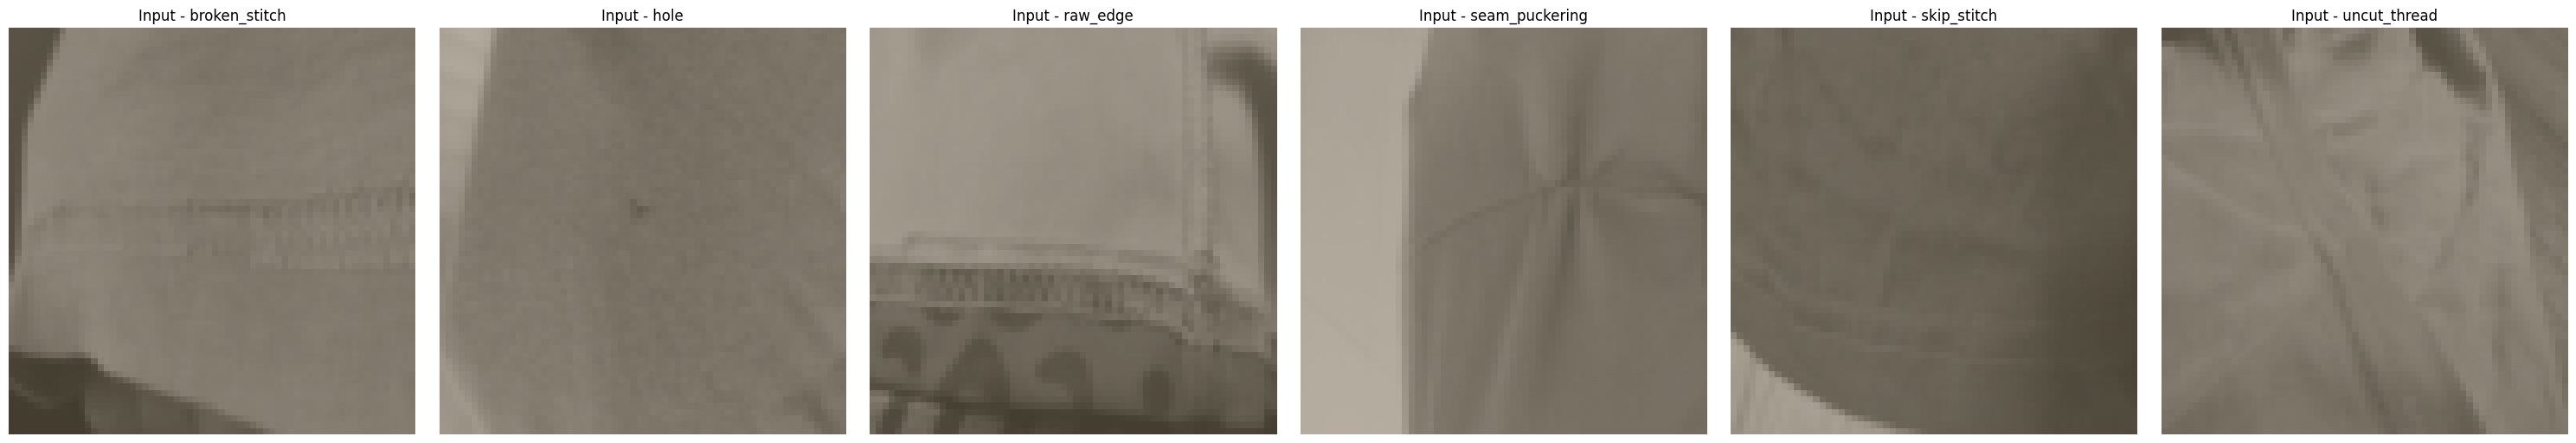

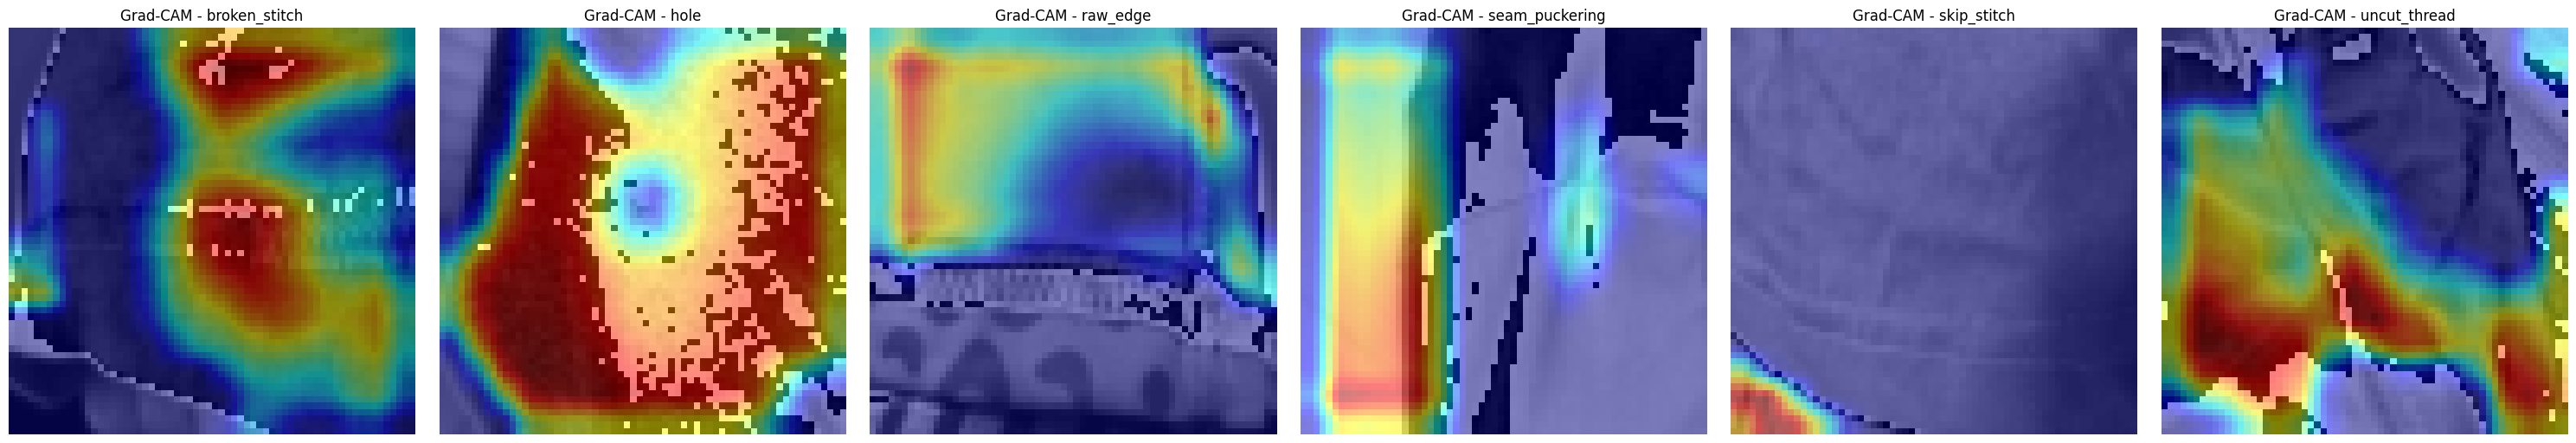

Epoch [26/30]:
  Training Loss: 0.0700, Accuracy: 98.51%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.9070, Accuracy: 87.50%, Precision: 0.88, Recall: 0.88, F1: 0.87
--------------------------------------------------------------------------------


Epoch [27/30]:
  Training Loss: 0.0476, Accuracy: 98.21%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.9171, Accuracy: 85.00%, Precision: 0.87, Recall: 0.85, F1: 0.85
--------------------------------------------------------------------------------


Epoch [28/30]:
  Training Loss: 0.0408, Accuracy: 98.81%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.7764, Accuracy: 85.00%, Precision: 0.87, Recall: 0.85, F1: 0.85
--------------------------------------------------------------------------------


Epoch [29/30]:
  Training Loss: 0.0397, Accuracy: 98.81%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.7912, Accuracy: 85.00%, Precision: 0.86, Recall: 0.85, F1: 0.85
--------------------------------------------------------------------------------


Epoch [30/30]:
  Training Loss: 0.0472, Accuracy: 98.51%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 1.1431, Accuracy: 82.50%, Precision: 0.87, Recall: 0.82, F1: 0.83
--------------------------------------------------------------------------------


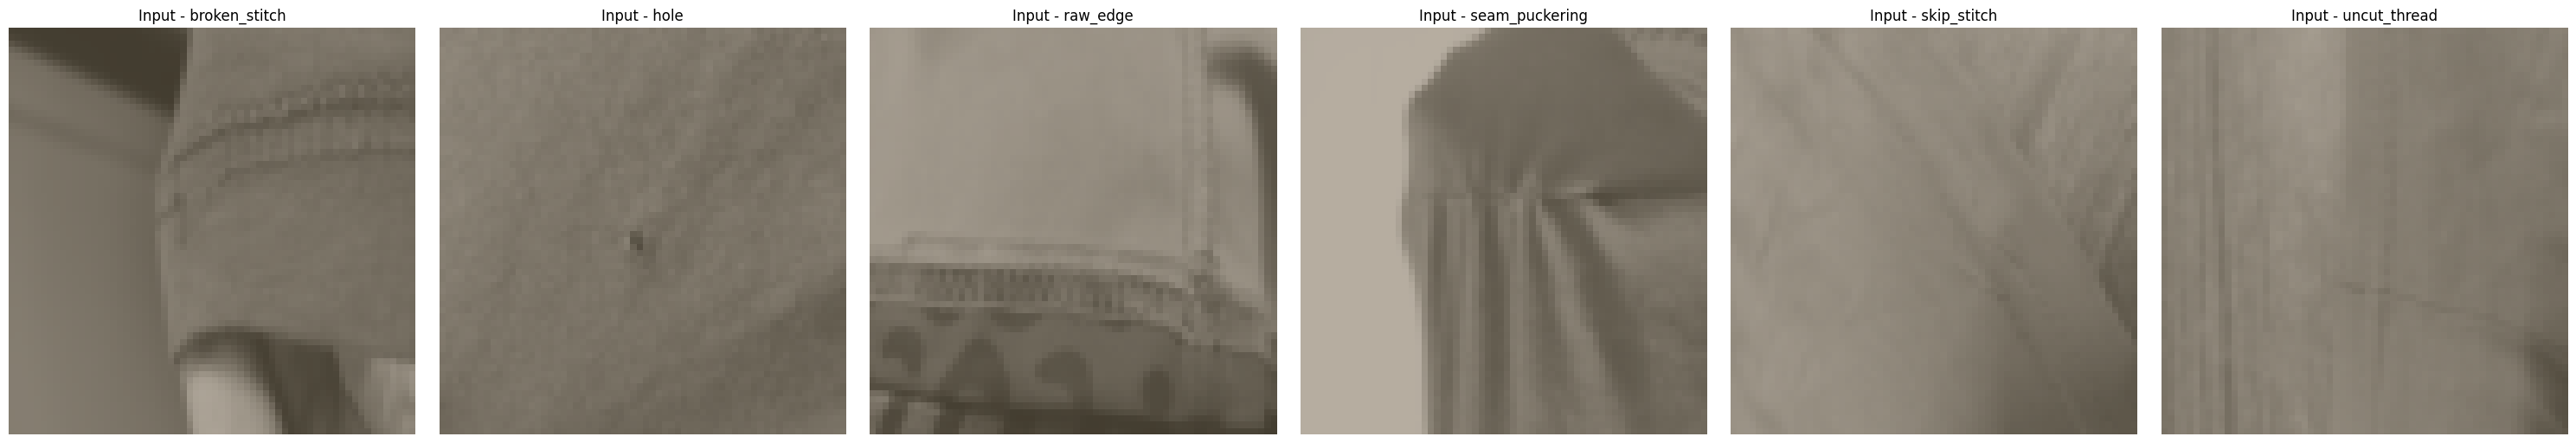

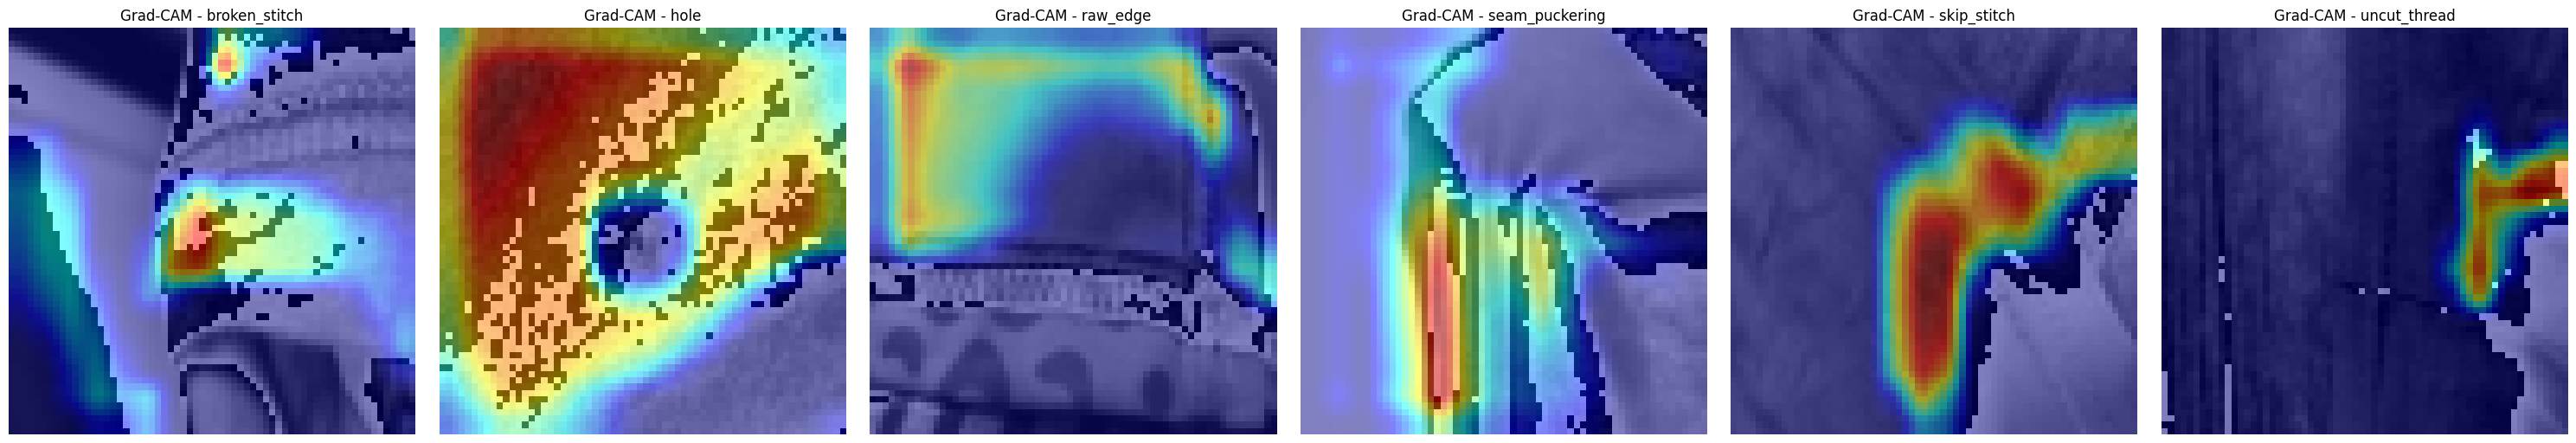

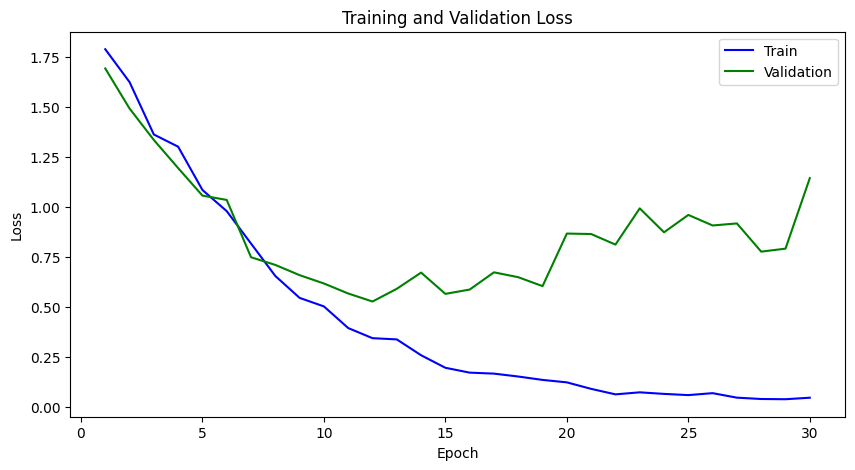

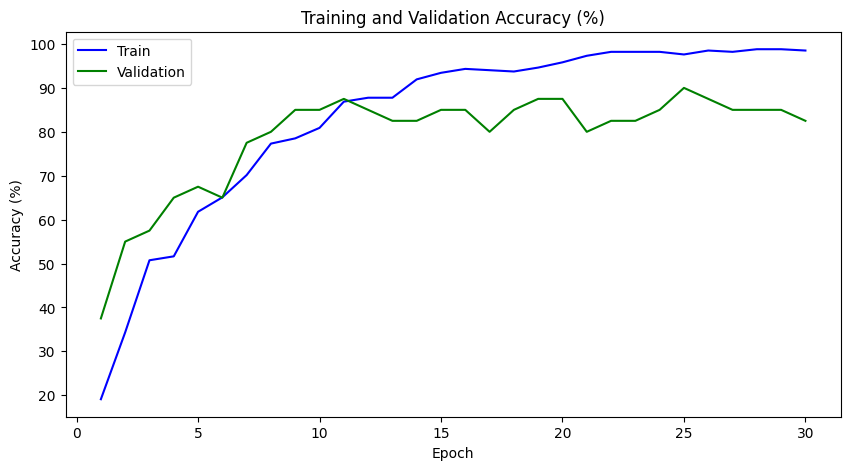

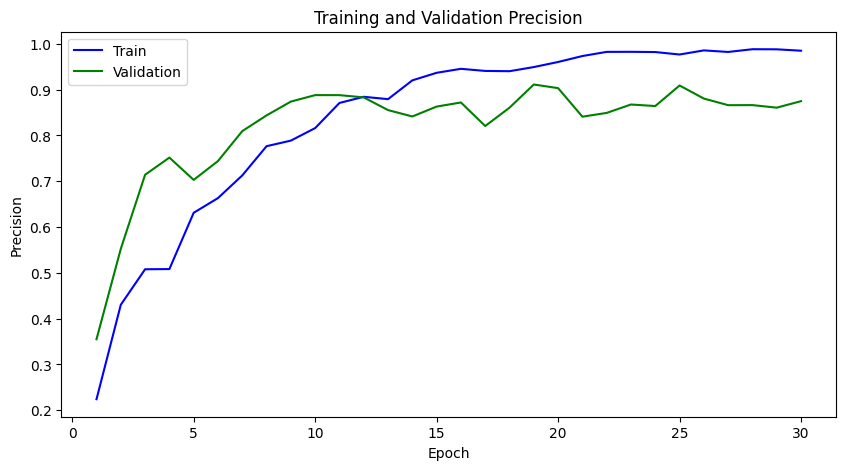

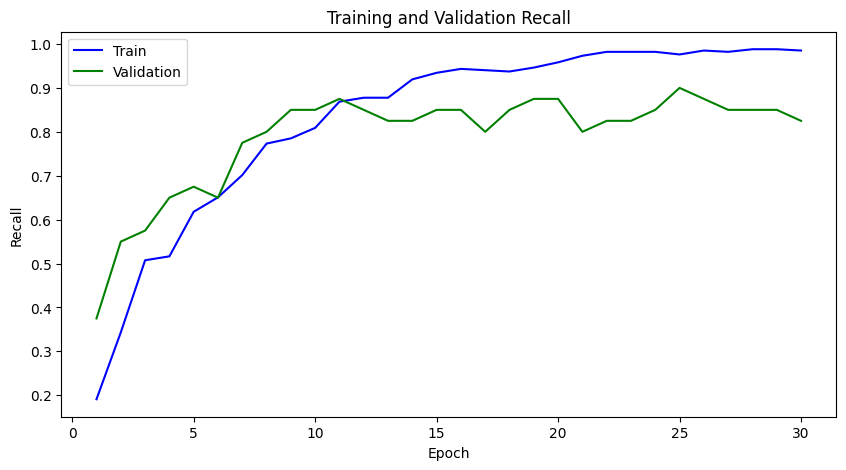

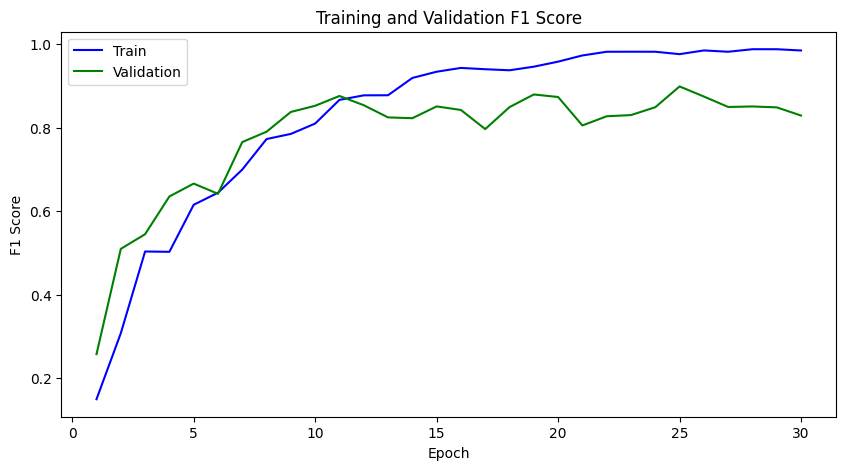

In [ ]:
train_model_with_metrics_tqdm(model_intial_model,train_loader, valid_loader, criterion_intial_model, optimizer_intial_model, num_epochs=30)

## Improved Model

Epoch [1/30]:
  Training Loss: 1.7679, Accuracy: 31.64%, Precision: 0.32, Recall: 0.32, F1: 0.31
  Validation Loss: 1.8236, Accuracy: 20.00%, Precision: 0.04, Recall: 0.20, F1: 0.07
--------------------------------------------------------------------------------


Epoch [2/30]:
  Training Loss: 1.1757, Accuracy: 58.81%, Precision: 0.59, Recall: 0.59, F1: 0.58
  Validation Loss: 2.1019, Accuracy: 20.00%, Precision: 0.04, Recall: 0.20, F1: 0.07
--------------------------------------------------------------------------------


Epoch [3/30]:
  Training Loss: 0.9537, Accuracy: 67.46%, Precision: 0.68, Recall: 0.67, F1: 0.67
  Validation Loss: 2.1258, Accuracy: 22.50%, Precision: 0.17, Recall: 0.23, F1: 0.11
--------------------------------------------------------------------------------


Epoch [4/30]:
  Training Loss: 0.7913, Accuracy: 73.73%, Precision: 0.75, Recall: 0.74, F1: 0.74
  Validation Loss: 1.1568, Accuracy: 55.00%, Precision: 0.74, Recall: 0.55, F1: 0.55
--------------------------------------------------------------------------------


Epoch [5/30]:
  Training Loss: 0.6307, Accuracy: 78.21%, Precision: 0.79, Recall: 0.78, F1: 0.78
  Validation Loss: 1.0833, Accuracy: 65.00%, Precision: 0.73, Recall: 0.65, F1: 0.64
--------------------------------------------------------------------------------


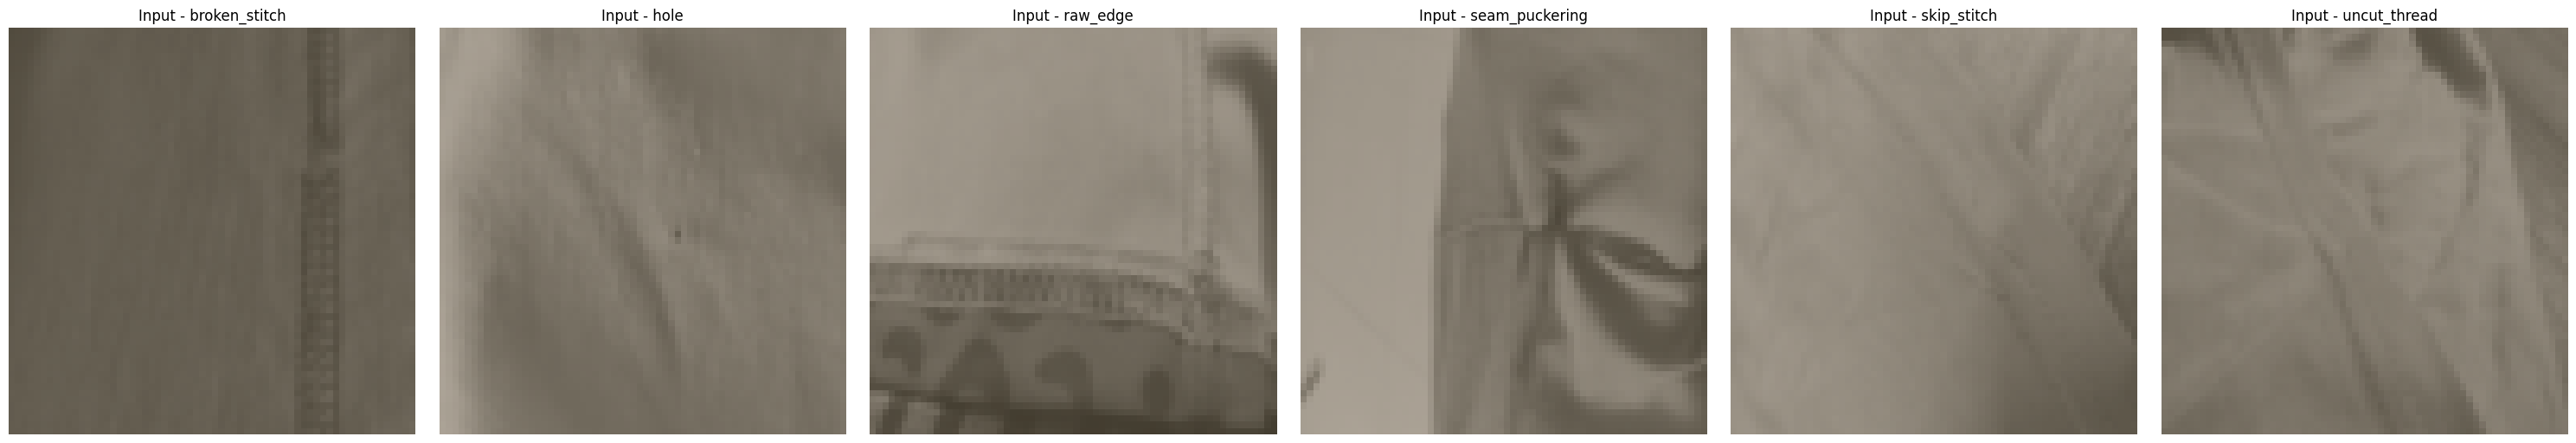

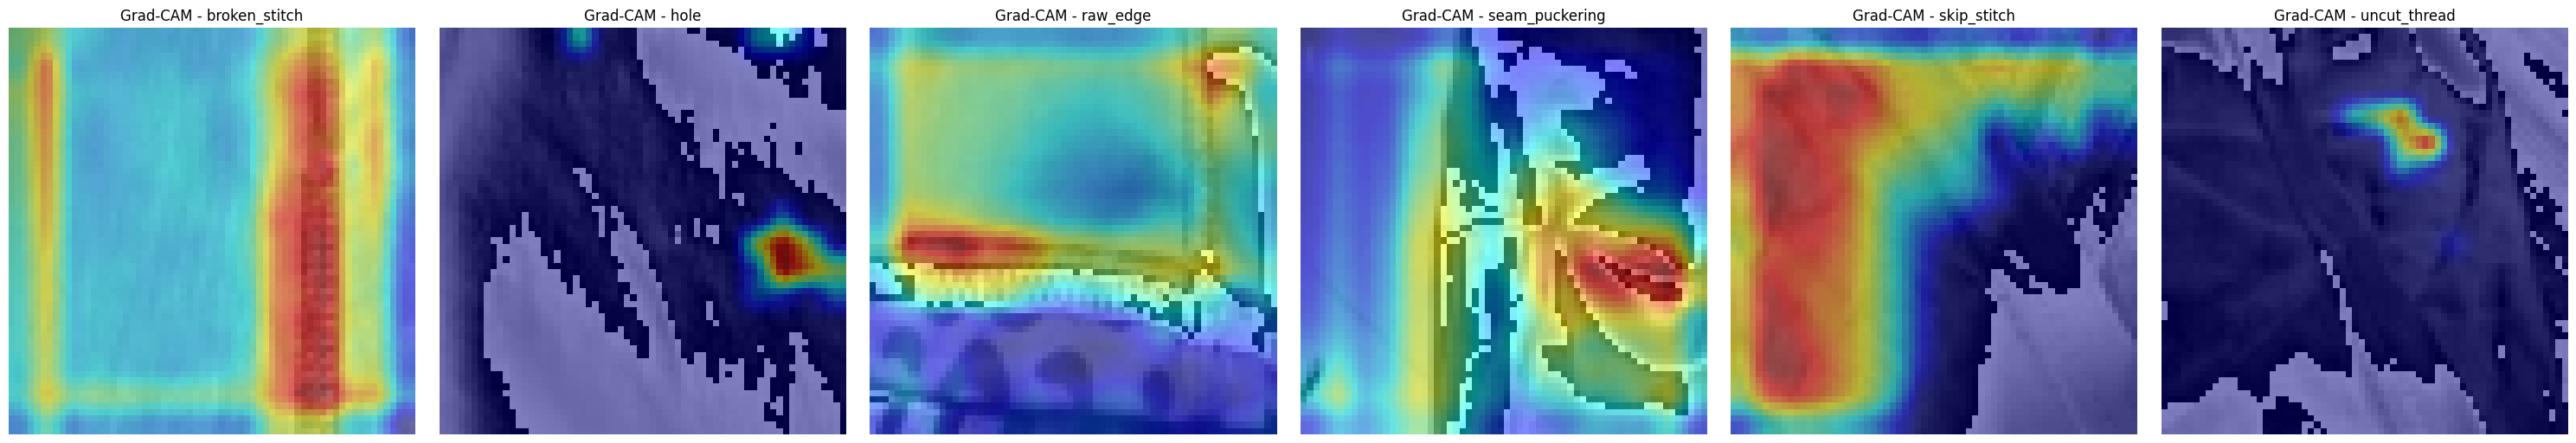

Epoch [6/30]:
  Training Loss: 0.5480, Accuracy: 82.39%, Precision: 0.83, Recall: 0.82, F1: 0.82
  Validation Loss: 0.7930, Accuracy: 72.50%, Precision: 0.80, Recall: 0.72, F1: 0.71
--------------------------------------------------------------------------------


Epoch [7/30]:
  Training Loss: 0.4453, Accuracy: 87.16%, Precision: 0.88, Recall: 0.87, F1: 0.87
  Validation Loss: 0.7818, Accuracy: 77.50%, Precision: 0.82, Recall: 0.78, F1: 0.76
--------------------------------------------------------------------------------


Epoch [8/30]:
  Training Loss: 0.3811, Accuracy: 88.36%, Precision: 0.89, Recall: 0.88, F1: 0.88
  Validation Loss: 0.8271, Accuracy: 75.00%, Precision: 0.81, Recall: 0.75, F1: 0.72
--------------------------------------------------------------------------------


Epoch [9/30]:
  Training Loss: 0.3422, Accuracy: 89.85%, Precision: 0.90, Recall: 0.90, F1: 0.90
  Validation Loss: 0.7281, Accuracy: 80.00%, Precision: 0.83, Recall: 0.80, F1: 0.79
--------------------------------------------------------------------------------


Epoch [10/30]:
  Training Loss: 0.3100, Accuracy: 91.04%, Precision: 0.92, Recall: 0.91, F1: 0.91
  Validation Loss: 0.7954, Accuracy: 80.00%, Precision: 0.83, Recall: 0.80, F1: 0.79
--------------------------------------------------------------------------------


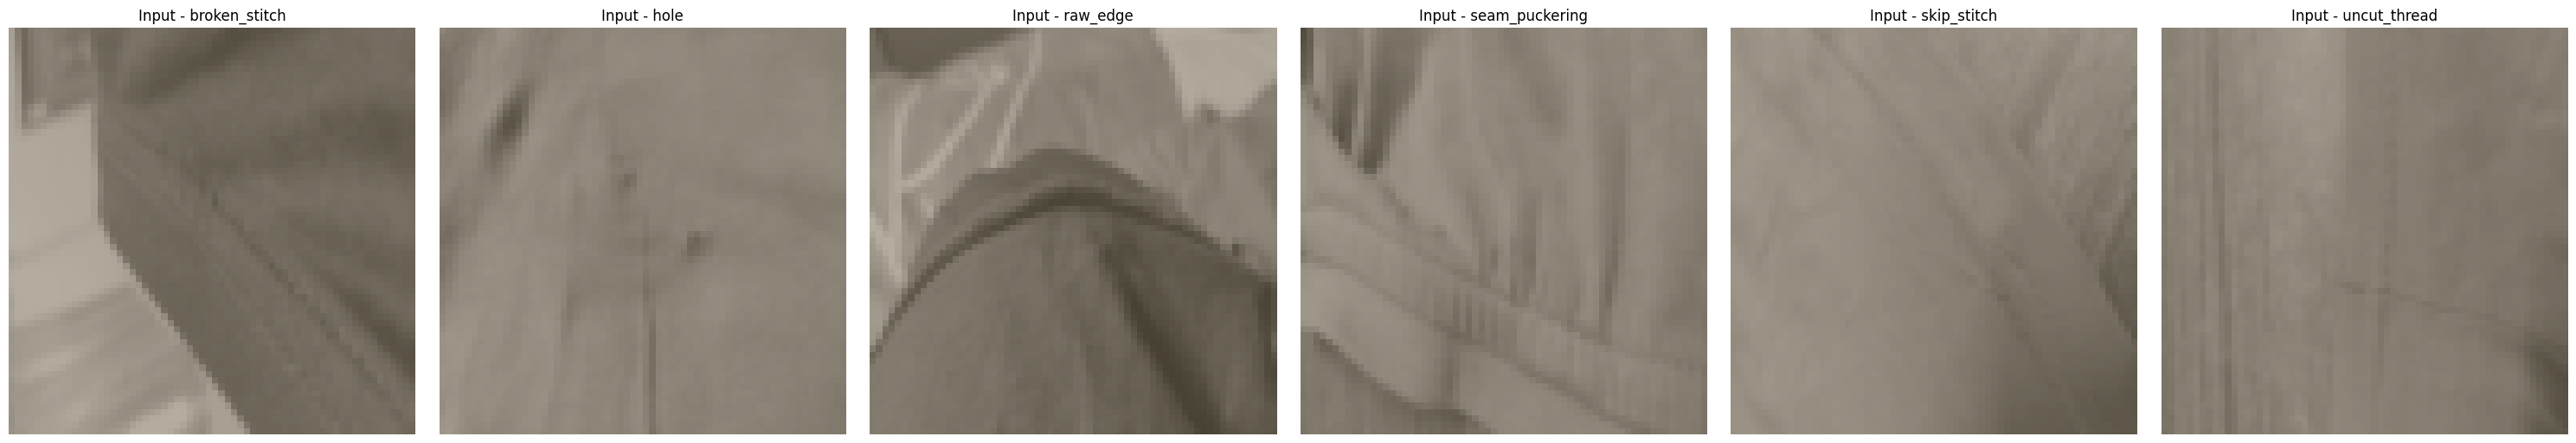

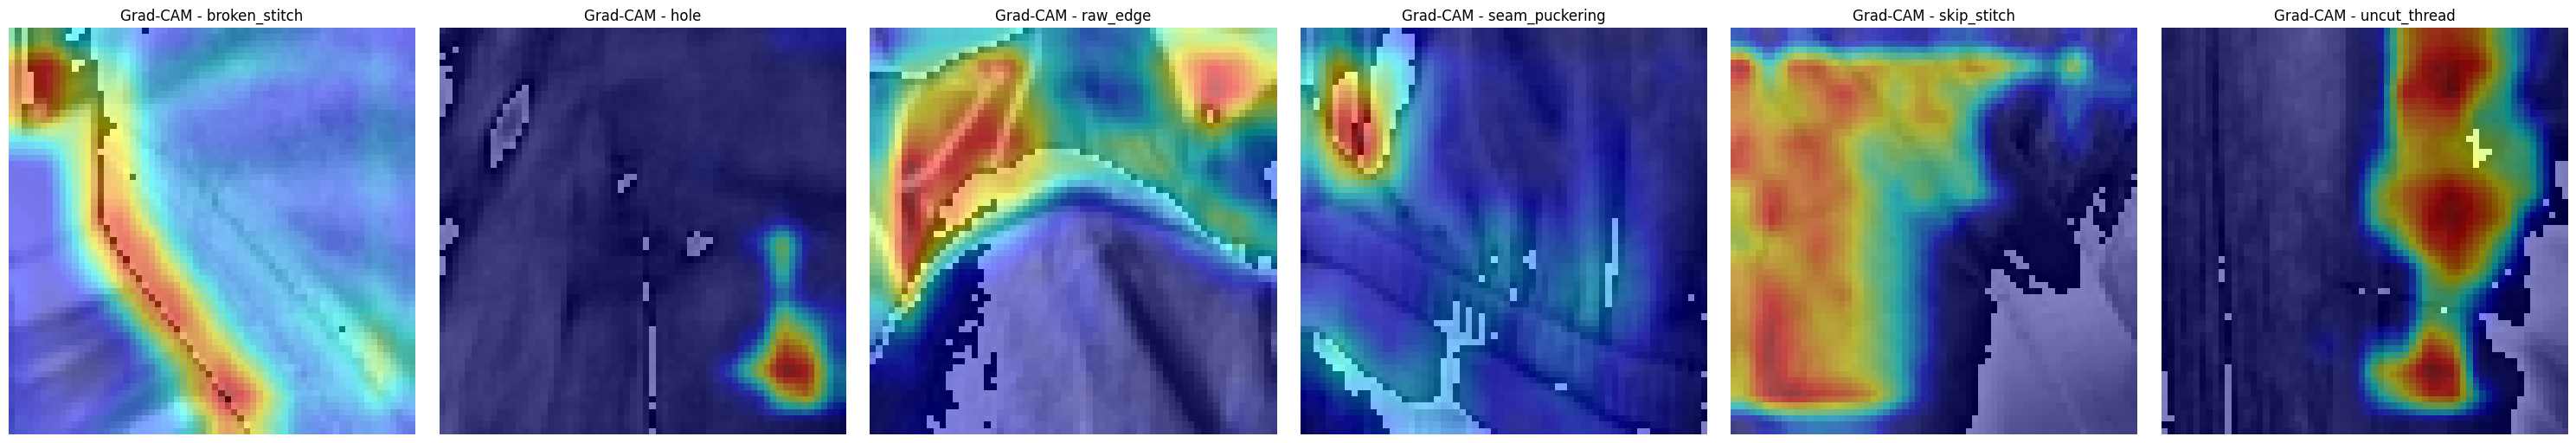

Epoch [11/30]:
  Training Loss: 0.2801, Accuracy: 93.13%, Precision: 0.93, Recall: 0.93, F1: 0.93
  Validation Loss: 0.7816, Accuracy: 80.00%, Precision: 0.83, Recall: 0.80, F1: 0.79
--------------------------------------------------------------------------------


Epoch [12/30]:
  Training Loss: 0.2206, Accuracy: 94.63%, Precision: 0.95, Recall: 0.95, F1: 0.95
  Validation Loss: 0.7074, Accuracy: 80.00%, Precision: 0.83, Recall: 0.80, F1: 0.79
--------------------------------------------------------------------------------


Epoch [13/30]:
  Training Loss: 0.2000, Accuracy: 96.12%, Precision: 0.96, Recall: 0.96, F1: 0.96
  Validation Loss: 0.7169, Accuracy: 80.00%, Precision: 0.83, Recall: 0.80, F1: 0.78
--------------------------------------------------------------------------------


Epoch [14/30]:
  Training Loss: 0.1703, Accuracy: 96.72%, Precision: 0.97, Recall: 0.97, F1: 0.97
  Validation Loss: 0.7390, Accuracy: 80.00%, Precision: 0.82, Recall: 0.80, F1: 0.78
--------------------------------------------------------------------------------


Epoch [15/30]:
  Training Loss: 0.1385, Accuracy: 97.61%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.7047, Accuracy: 80.00%, Precision: 0.82, Recall: 0.80, F1: 0.78
--------------------------------------------------------------------------------


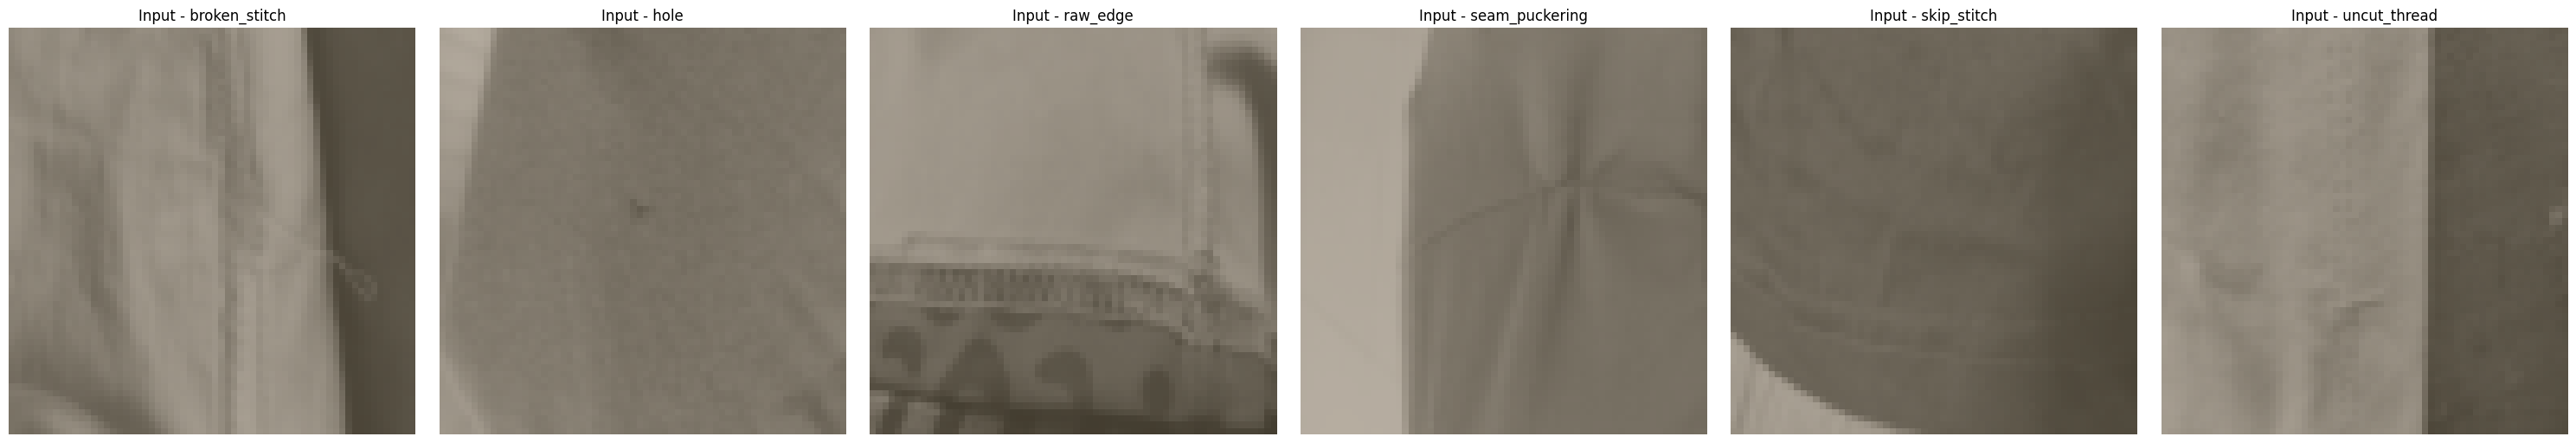

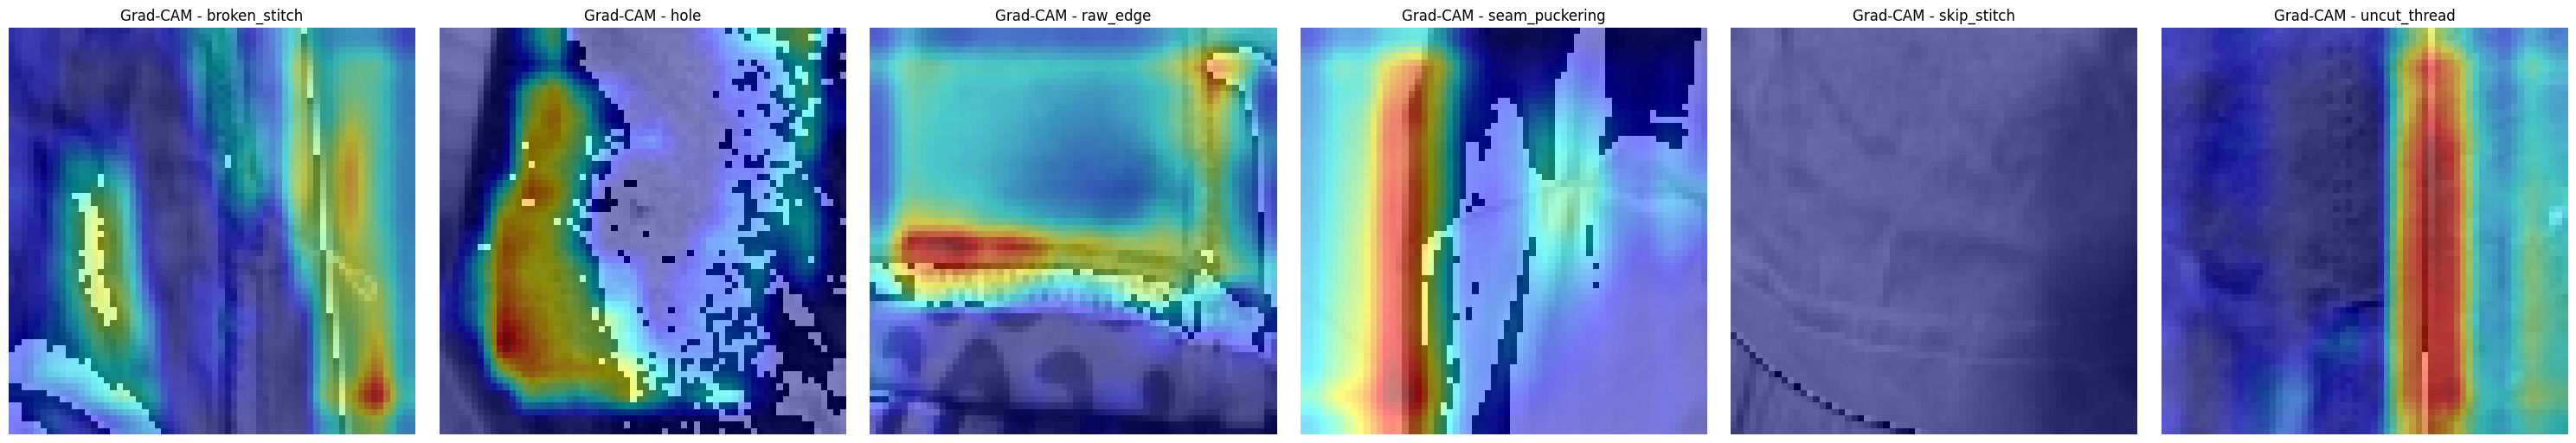

Epoch [16/30]:
  Training Loss: 0.1286, Accuracy: 97.61%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.7421, Accuracy: 80.00%, Precision: 0.82, Recall: 0.80, F1: 0.78
--------------------------------------------------------------------------------


Epoch [17/30]:
  Training Loss: 0.0980, Accuracy: 97.61%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.7724, Accuracy: 77.50%, Precision: 0.82, Recall: 0.78, F1: 0.76
--------------------------------------------------------------------------------


Epoch [18/30]:
  Training Loss: 0.0902, Accuracy: 98.81%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.6985, Accuracy: 80.00%, Precision: 0.83, Recall: 0.80, F1: 0.78
--------------------------------------------------------------------------------


Epoch [19/30]:
  Training Loss: 0.0865, Accuracy: 98.51%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.7056, Accuracy: 80.00%, Precision: 0.83, Recall: 0.80, F1: 0.78
--------------------------------------------------------------------------------


Epoch [20/30]:
  Training Loss: 0.0854, Accuracy: 98.51%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.7237, Accuracy: 77.50%, Precision: 0.82, Recall: 0.78, F1: 0.76
--------------------------------------------------------------------------------


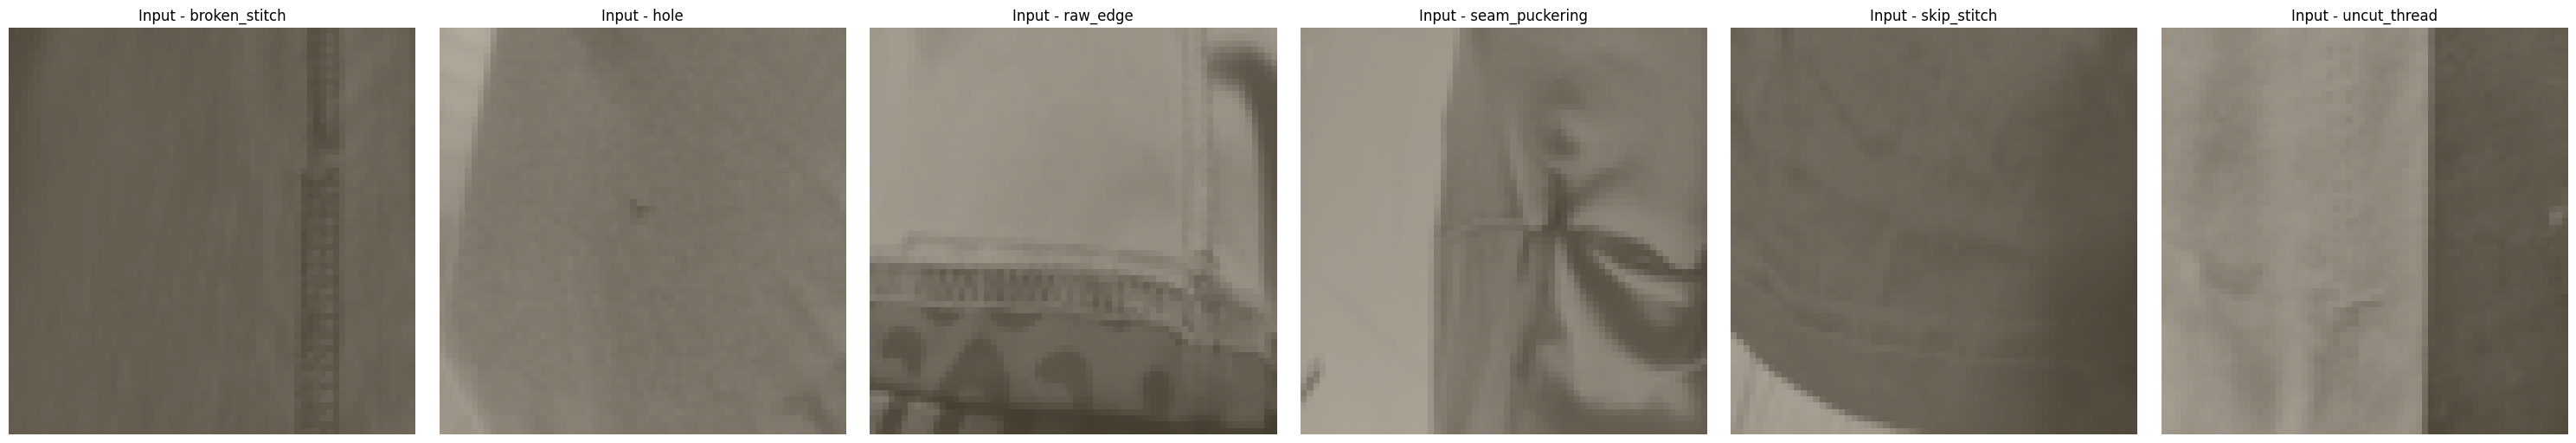

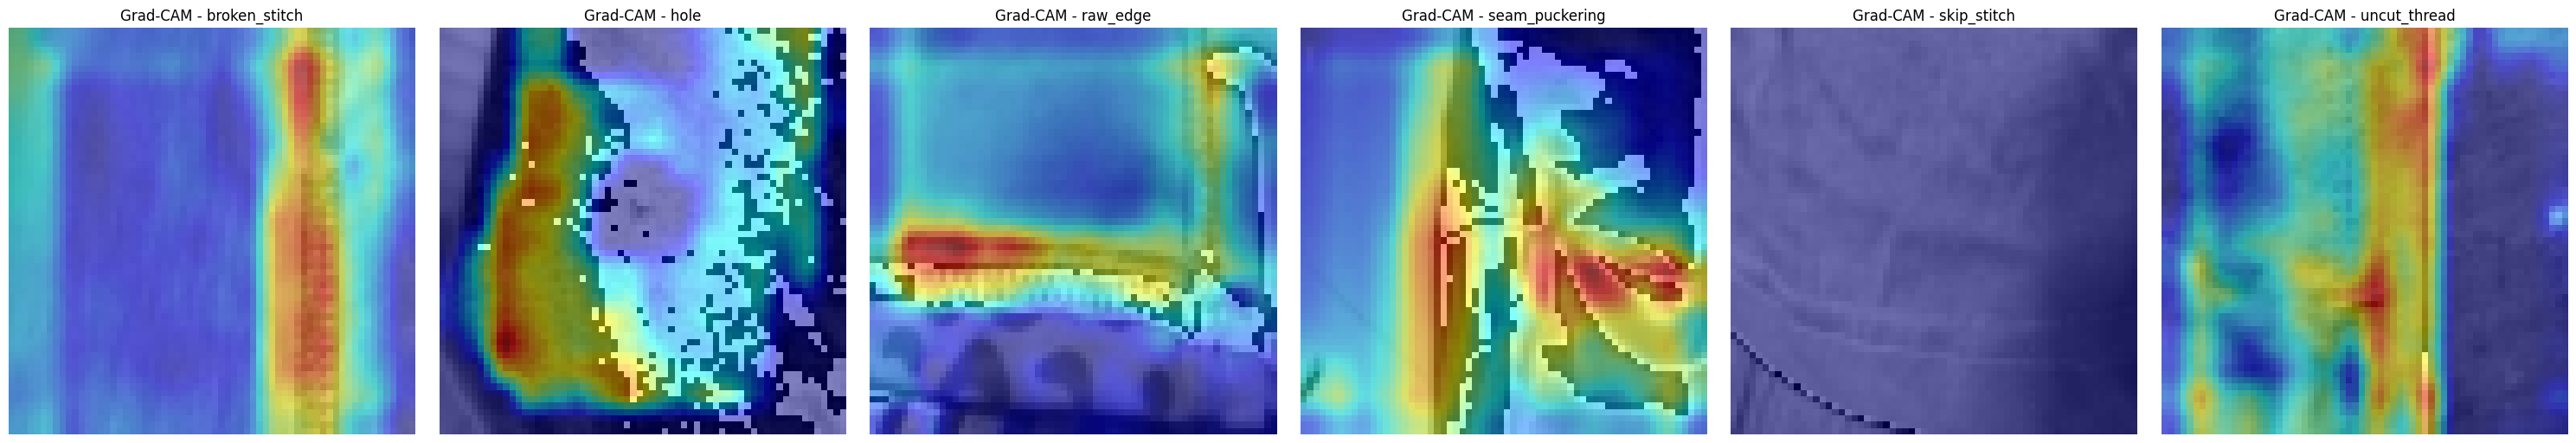

Epoch [21/30]:
  Training Loss: 0.0739, Accuracy: 99.40%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.6739, Accuracy: 80.00%, Precision: 0.82, Recall: 0.80, F1: 0.78
--------------------------------------------------------------------------------


Epoch [22/30]:
  Training Loss: 0.0761, Accuracy: 98.51%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.7442, Accuracy: 80.00%, Precision: 0.85, Recall: 0.80, F1: 0.79
--------------------------------------------------------------------------------


Epoch [23/30]:
  Training Loss: 0.0618, Accuracy: 99.10%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.6982, Accuracy: 80.00%, Precision: 0.82, Recall: 0.80, F1: 0.78
--------------------------------------------------------------------------------


Epoch [24/30]:
  Training Loss: 0.0438, Accuracy: 99.40%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.7387, Accuracy: 80.00%, Precision: 0.85, Recall: 0.80, F1: 0.79
--------------------------------------------------------------------------------


Epoch [25/30]:
  Training Loss: 0.0368, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.7337, Accuracy: 80.00%, Precision: 0.82, Recall: 0.80, F1: 0.78
--------------------------------------------------------------------------------


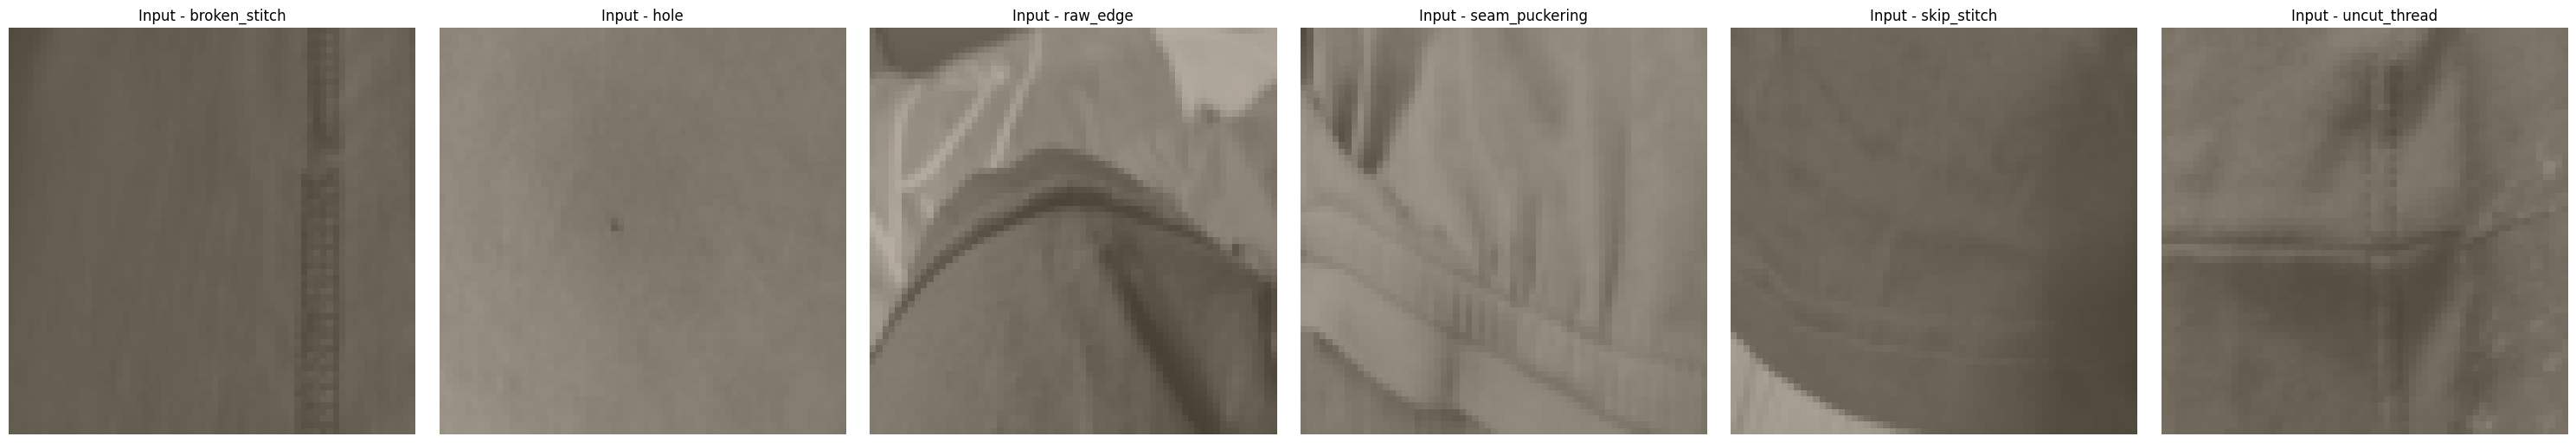

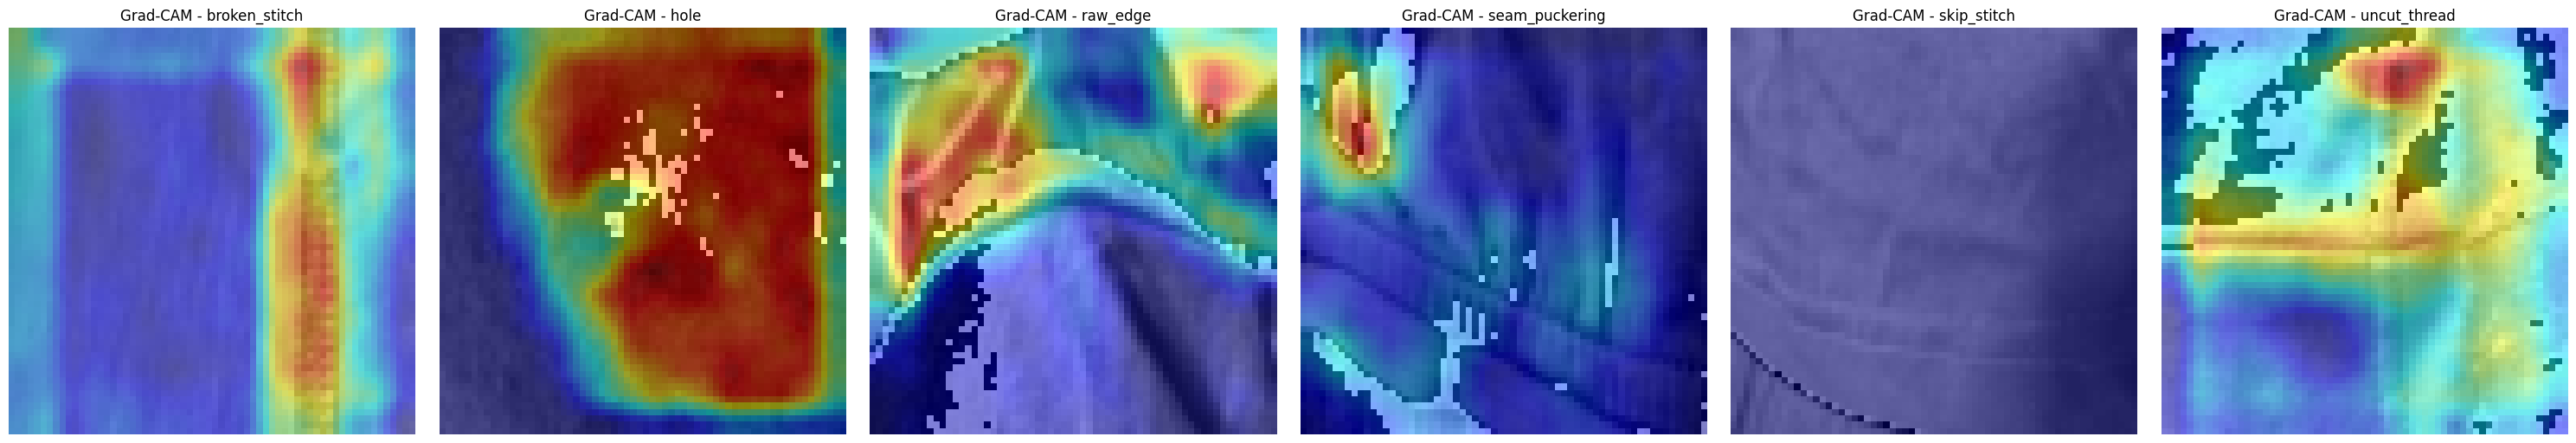

Epoch [26/30]:
  Training Loss: 0.0516, Accuracy: 99.10%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.8750, Accuracy: 72.50%, Precision: 0.79, Recall: 0.72, F1: 0.71
--------------------------------------------------------------------------------


Epoch [27/30]:
  Training Loss: 0.0384, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.8289, Accuracy: 82.50%, Precision: 0.84, Recall: 0.82, F1: 0.81
--------------------------------------------------------------------------------


Epoch [28/30]:
  Training Loss: 0.0328, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.8366, Accuracy: 80.00%, Precision: 0.82, Recall: 0.80, F1: 0.78
--------------------------------------------------------------------------------


Epoch [29/30]:
  Training Loss: 0.0361, Accuracy: 99.70%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.7958, Accuracy: 72.50%, Precision: 0.78, Recall: 0.72, F1: 0.72
--------------------------------------------------------------------------------


Epoch [30/30]:
  Training Loss: 0.0462, Accuracy: 98.81%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.7897, Accuracy: 77.50%, Precision: 0.82, Recall: 0.78, F1: 0.76
--------------------------------------------------------------------------------


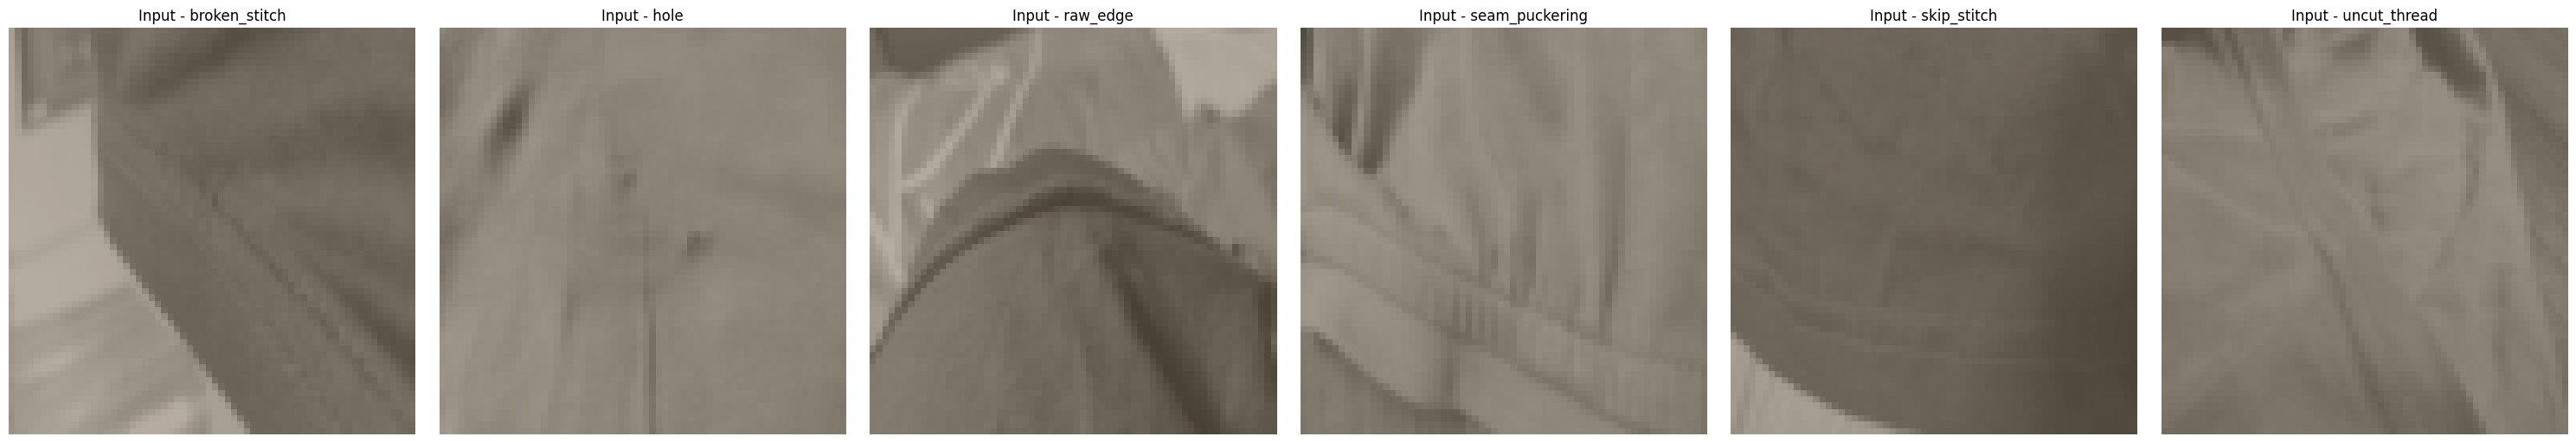

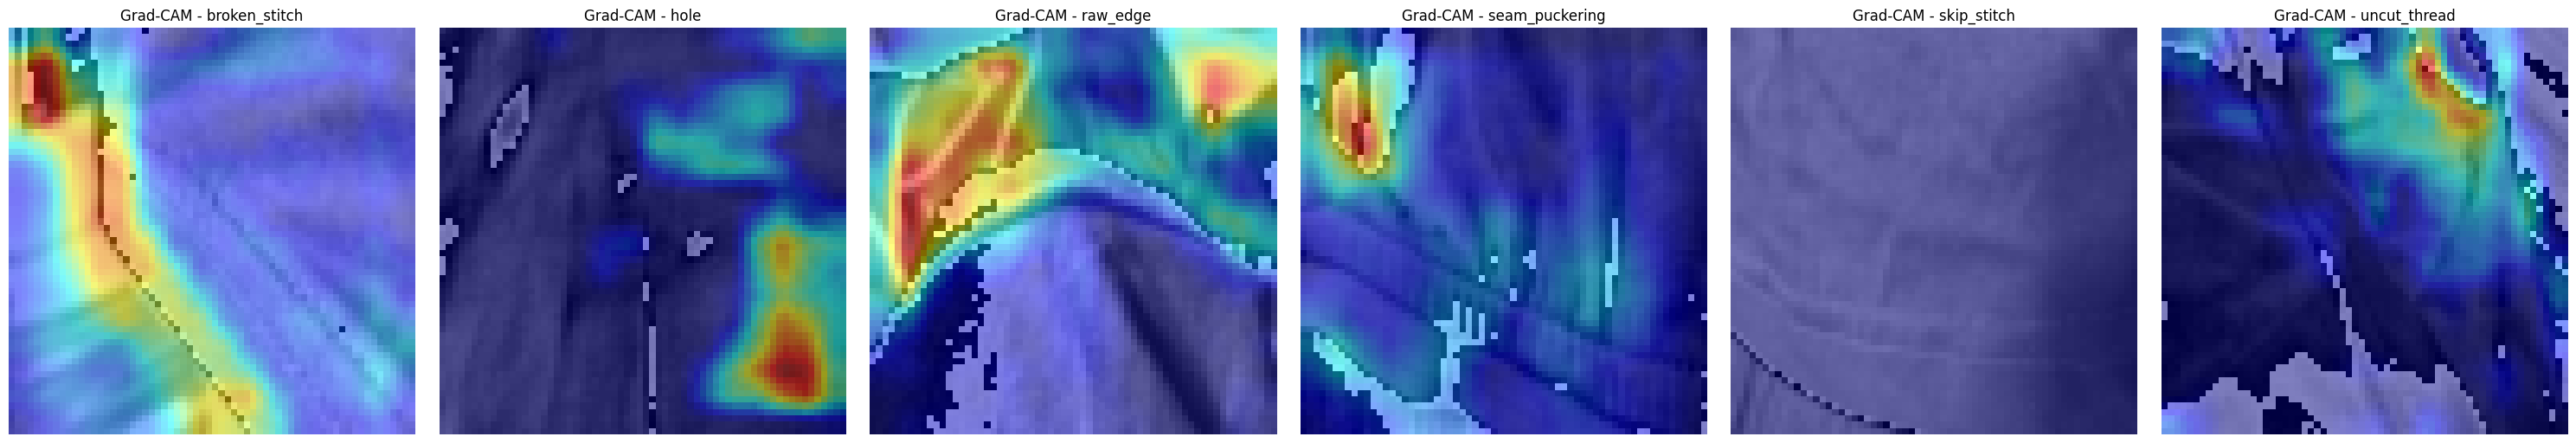

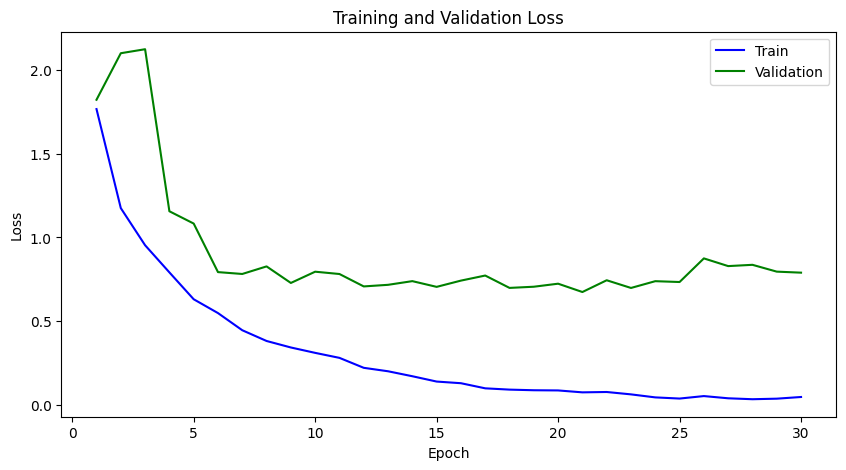

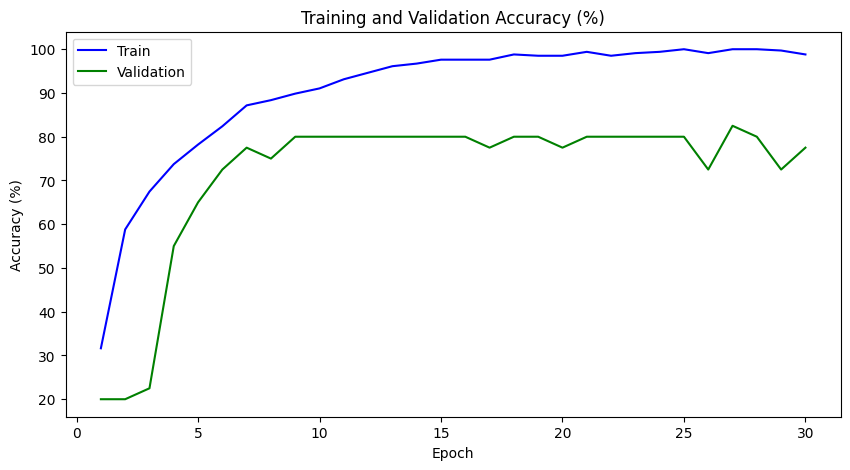

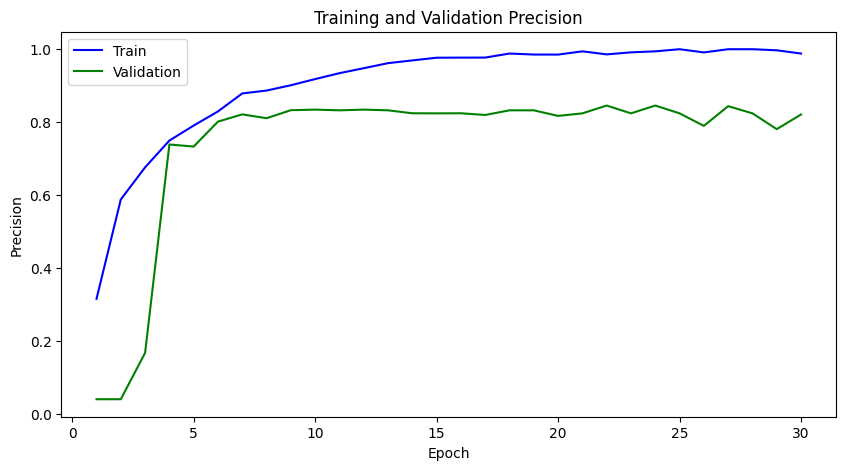

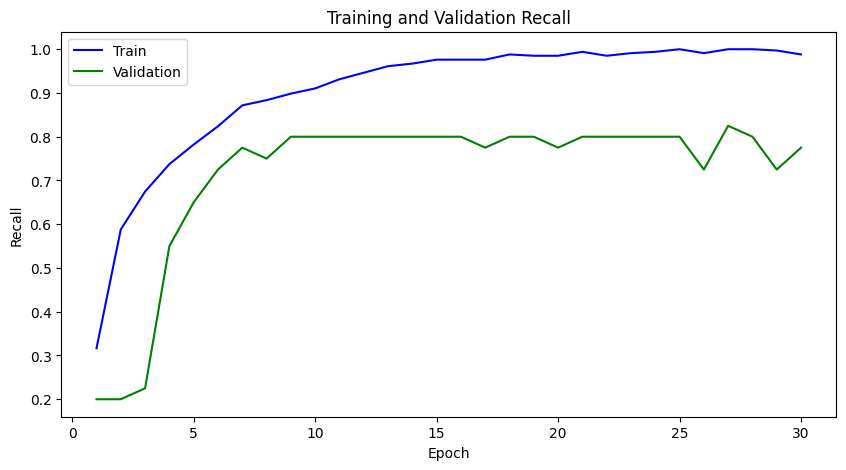

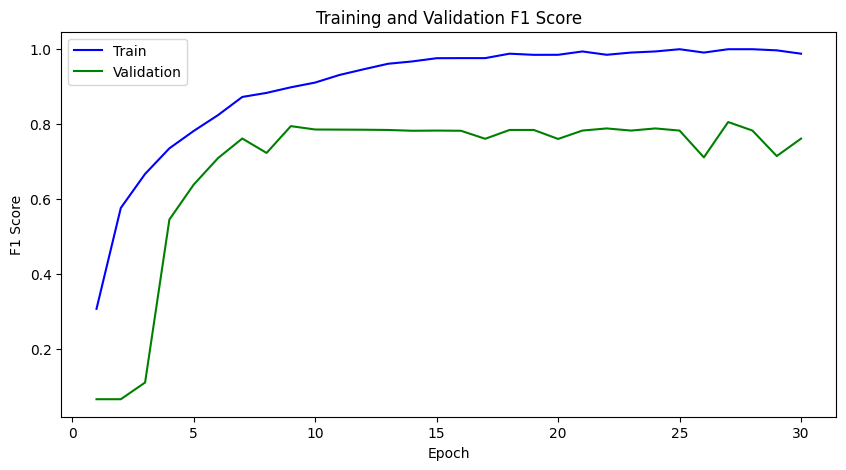

In [ ]:
train_model_with_metrics_tqdm(model_improved,train_loader, valid_loader, criterion_improved_model, optimizer_improved_model, num_epochs=30)

## ResNet

Epoch [1/30]:
  Training Loss: 1.6963, Accuracy: 34.93%, Precision: 0.40, Recall: 0.35, F1: 0.33
  Validation Loss: 1.7305, Accuracy: 25.00%, Precision: 0.14, Recall: 0.25, F1: 0.15
--------------------------------------------------------------------------------


Epoch [2/30]:
  Training Loss: 0.6013, Accuracy: 86.27%, Precision: 0.88, Recall: 0.86, F1: 0.86
  Validation Loss: 1.7766, Accuracy: 25.00%, Precision: 0.19, Recall: 0.25, F1: 0.15
--------------------------------------------------------------------------------


Epoch [3/30]:
  Training Loss: 0.2813, Accuracy: 94.63%, Precision: 0.95, Recall: 0.95, F1: 0.95
  Validation Loss: 1.6637, Accuracy: 40.00%, Precision: 0.36, Recall: 0.40, F1: 0.33
--------------------------------------------------------------------------------


Epoch [4/30]:
  Training Loss: 0.1506, Accuracy: 98.21%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 1.0193, Accuracy: 65.00%, Precision: 0.61, Recall: 0.65, F1: 0.60
--------------------------------------------------------------------------------


Epoch [5/30]:
  Training Loss: 0.0679, Accuracy: 99.40%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.6488, Accuracy: 80.00%, Precision: 0.81, Recall: 0.80, F1: 0.79
--------------------------------------------------------------------------------


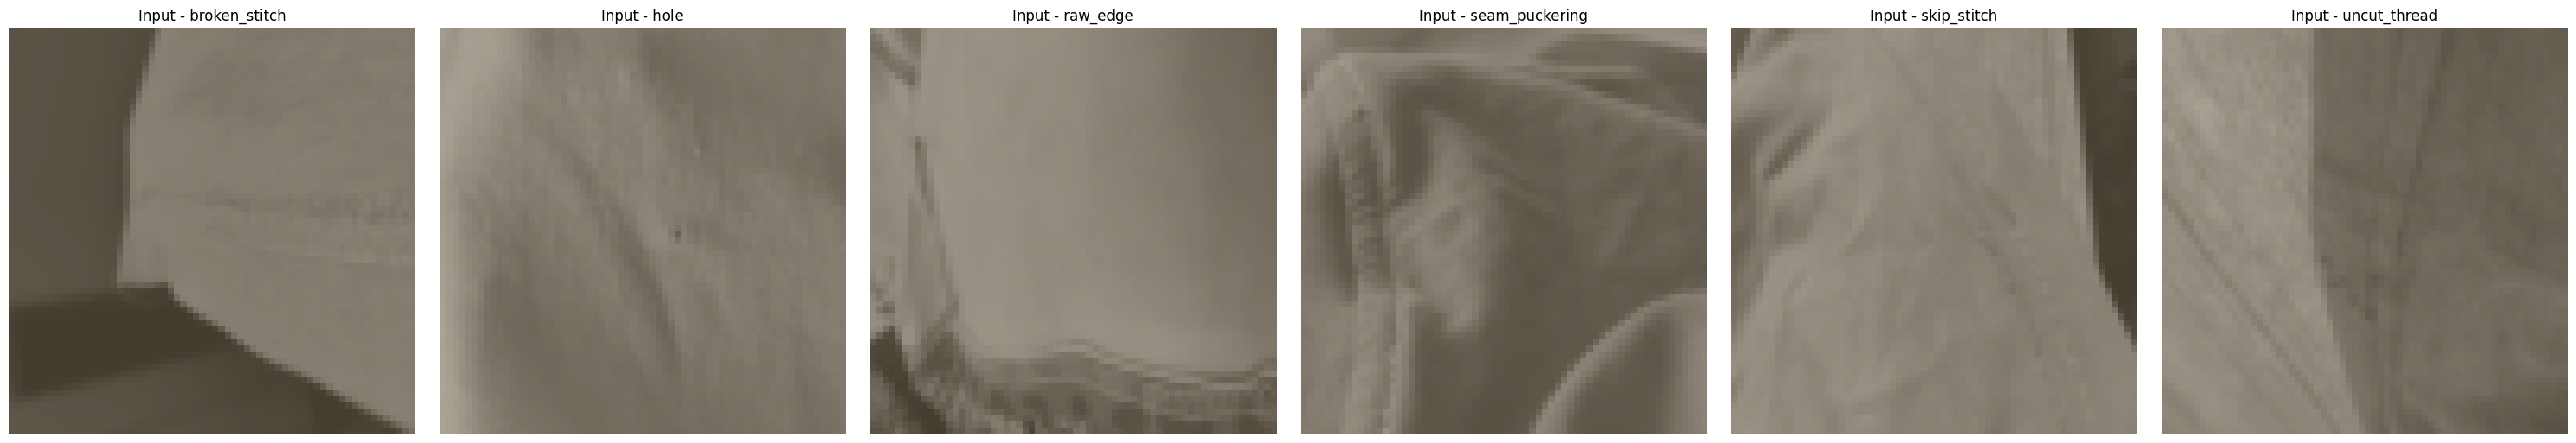

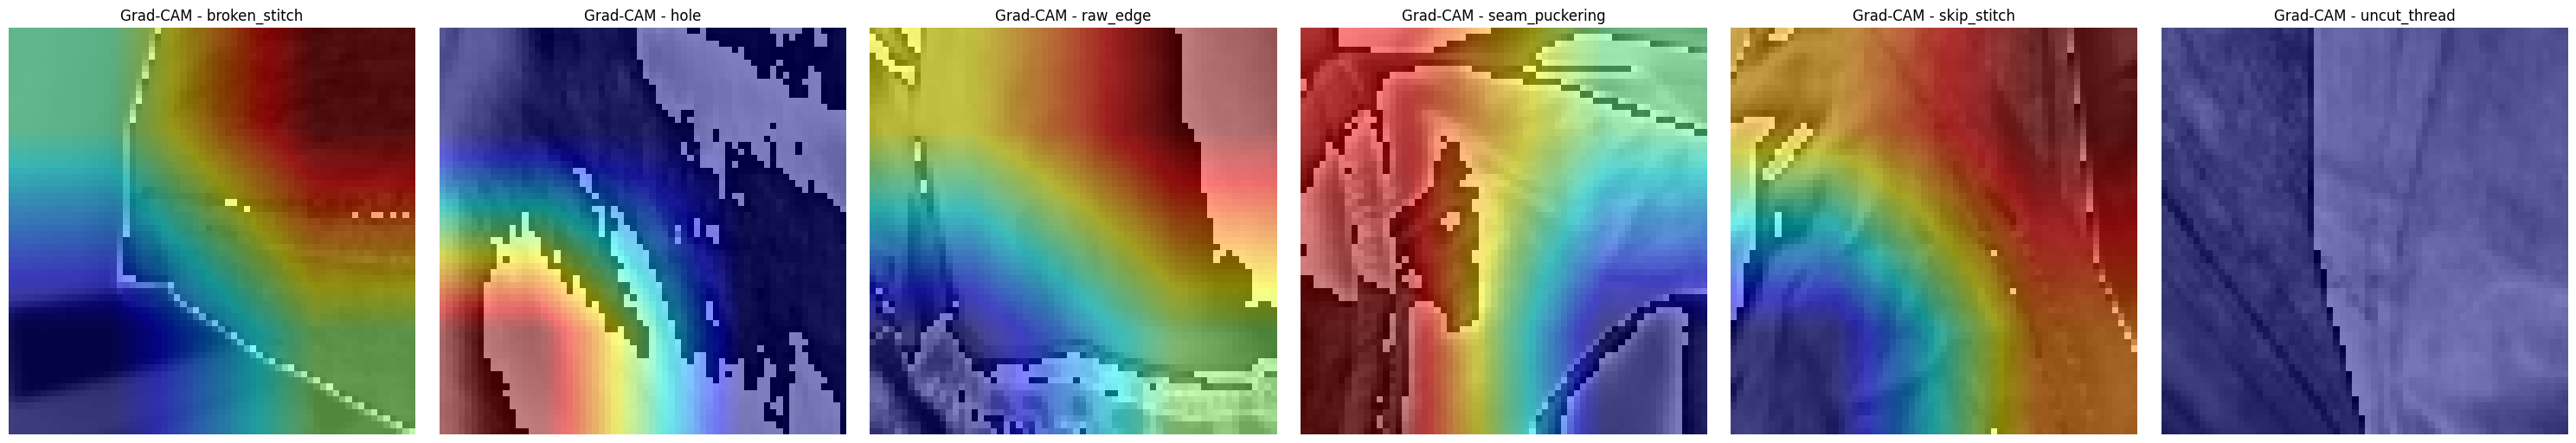

Epoch [6/30]:
  Training Loss: 0.0465, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.5516, Accuracy: 80.00%, Precision: 0.84, Recall: 0.80, F1: 0.80
--------------------------------------------------------------------------------


Epoch [7/30]:
  Training Loss: 0.0296, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4749, Accuracy: 87.50%, Precision: 0.89, Recall: 0.88, F1: 0.87
--------------------------------------------------------------------------------


Epoch [8/30]:
  Training Loss: 0.0227, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4752, Accuracy: 90.00%, Precision: 0.91, Recall: 0.90, F1: 0.90
--------------------------------------------------------------------------------


Epoch [9/30]:
  Training Loss: 0.0334, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4625, Accuracy: 90.00%, Precision: 0.91, Recall: 0.90, F1: 0.90
--------------------------------------------------------------------------------


Epoch [10/30]:
  Training Loss: 0.0175, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4401, Accuracy: 87.50%, Precision: 0.89, Recall: 0.88, F1: 0.87
--------------------------------------------------------------------------------


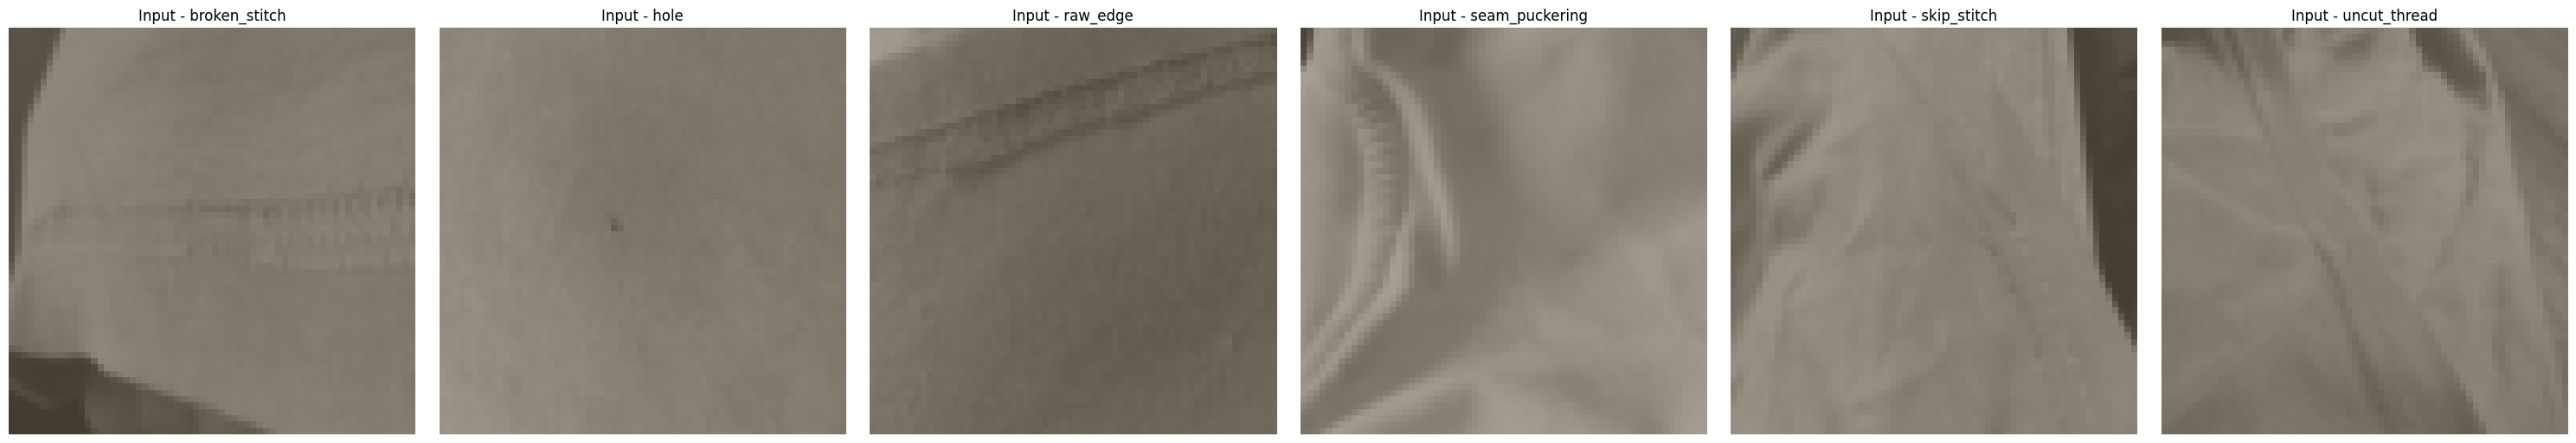

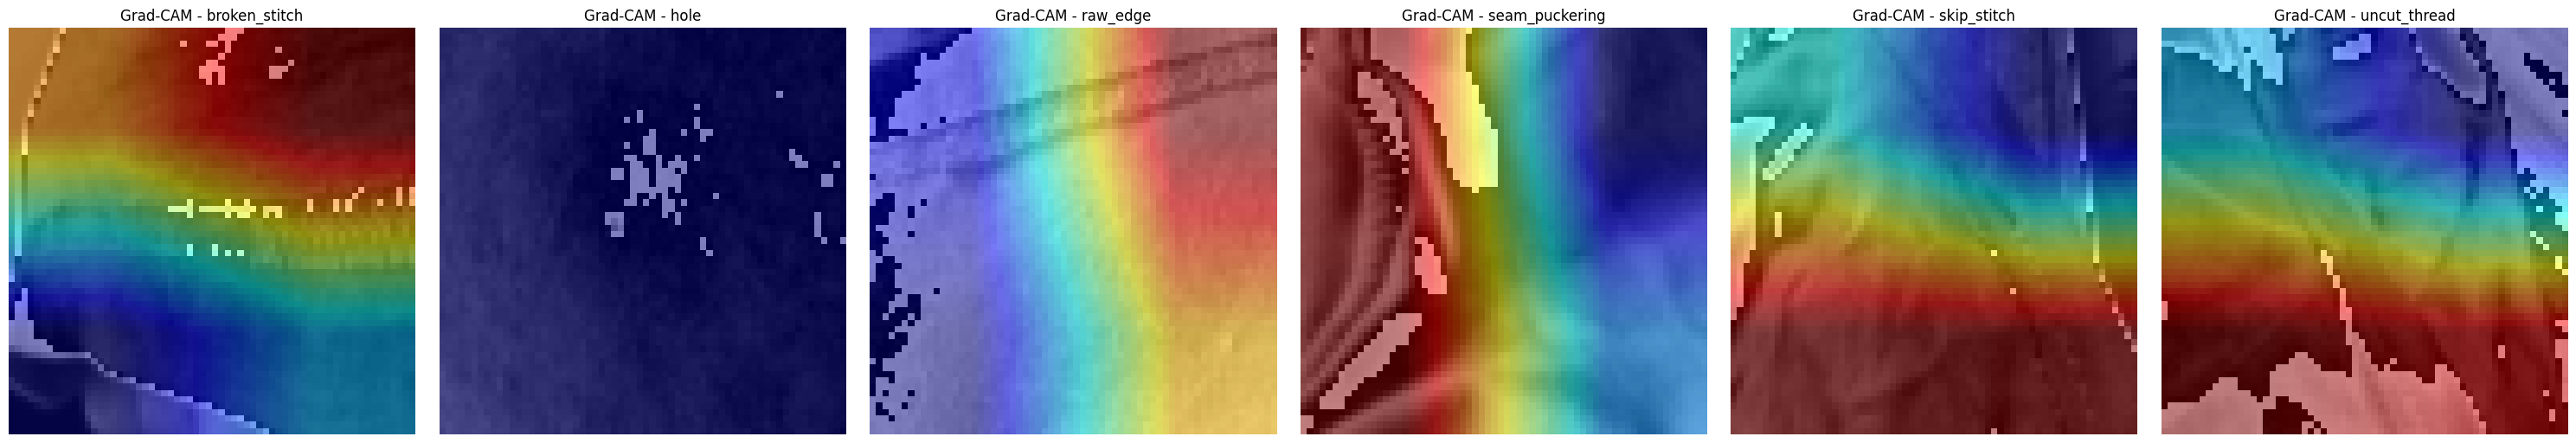

Epoch [11/30]:
  Training Loss: 0.0234, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4651, Accuracy: 90.00%, Precision: 0.91, Recall: 0.90, F1: 0.90
--------------------------------------------------------------------------------


Epoch [12/30]:
  Training Loss: 0.0206, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4835, Accuracy: 85.00%, Precision: 0.88, Recall: 0.85, F1: 0.85
--------------------------------------------------------------------------------


Epoch [13/30]:
  Training Loss: 0.0097, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4424, Accuracy: 87.50%, Precision: 0.89, Recall: 0.88, F1: 0.87
--------------------------------------------------------------------------------


Epoch [14/30]:
  Training Loss: 0.0137, Accuracy: 99.70%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4572, Accuracy: 87.50%, Precision: 0.89, Recall: 0.88, F1: 0.87
--------------------------------------------------------------------------------


Epoch [15/30]:
  Training Loss: 0.0452, Accuracy: 98.51%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.5172, Accuracy: 82.50%, Precision: 0.84, Recall: 0.82, F1: 0.82
--------------------------------------------------------------------------------


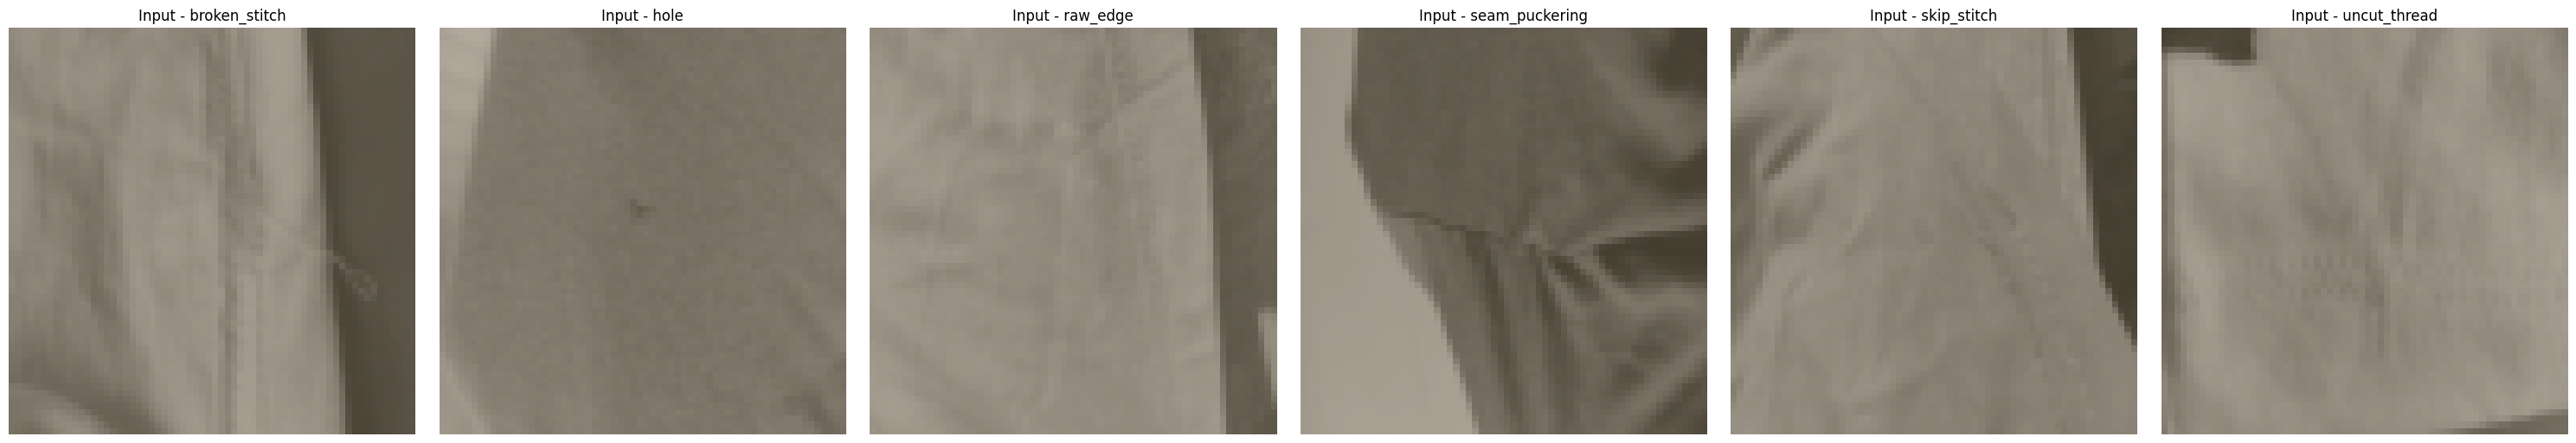

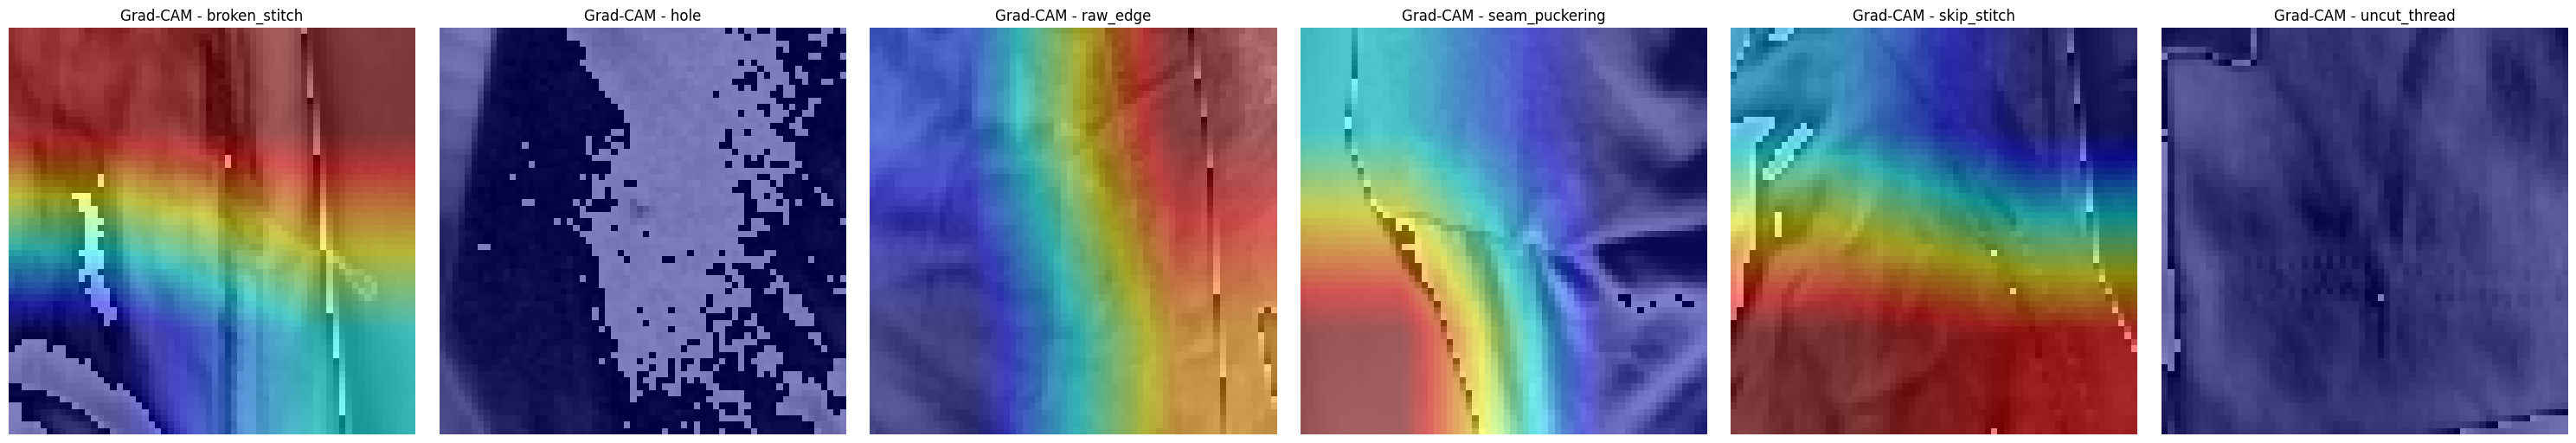

Epoch [16/30]:
  Training Loss: 0.0698, Accuracy: 98.51%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.5643, Accuracy: 85.00%, Precision: 0.86, Recall: 0.85, F1: 0.85
--------------------------------------------------------------------------------


Epoch [17/30]:
  Training Loss: 0.0354, Accuracy: 98.81%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.4113, Accuracy: 85.00%, Precision: 0.86, Recall: 0.85, F1: 0.85
--------------------------------------------------------------------------------


Epoch [18/30]:
  Training Loss: 0.0220, Accuracy: 99.70%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4529, Accuracy: 85.00%, Precision: 0.87, Recall: 0.85, F1: 0.85
--------------------------------------------------------------------------------


Epoch [19/30]:
  Training Loss: 0.0268, Accuracy: 99.70%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.5133, Accuracy: 87.50%, Precision: 0.89, Recall: 0.88, F1: 0.87
--------------------------------------------------------------------------------


Epoch [20/30]:
  Training Loss: 0.0176, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.5092, Accuracy: 85.00%, Precision: 0.87, Recall: 0.85, F1: 0.85
--------------------------------------------------------------------------------


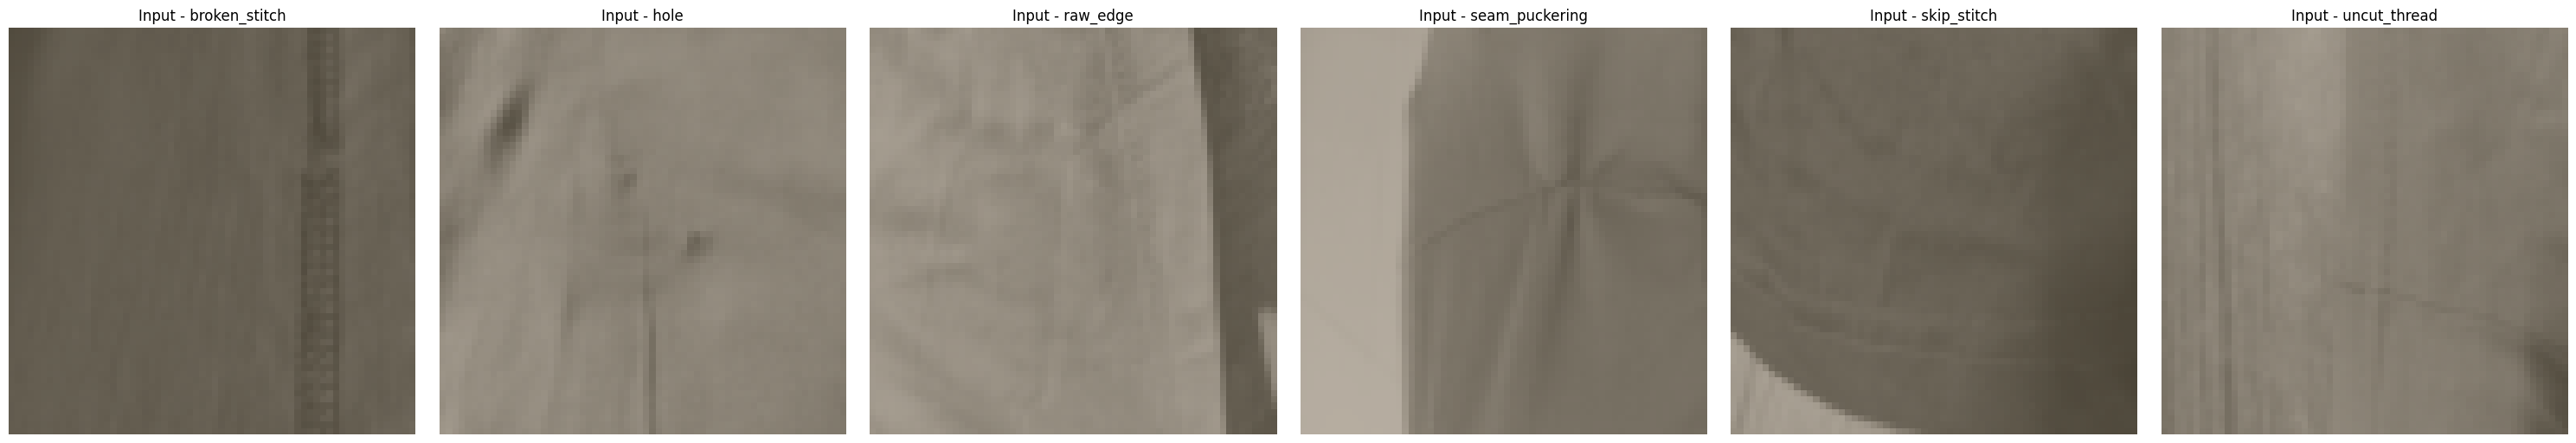

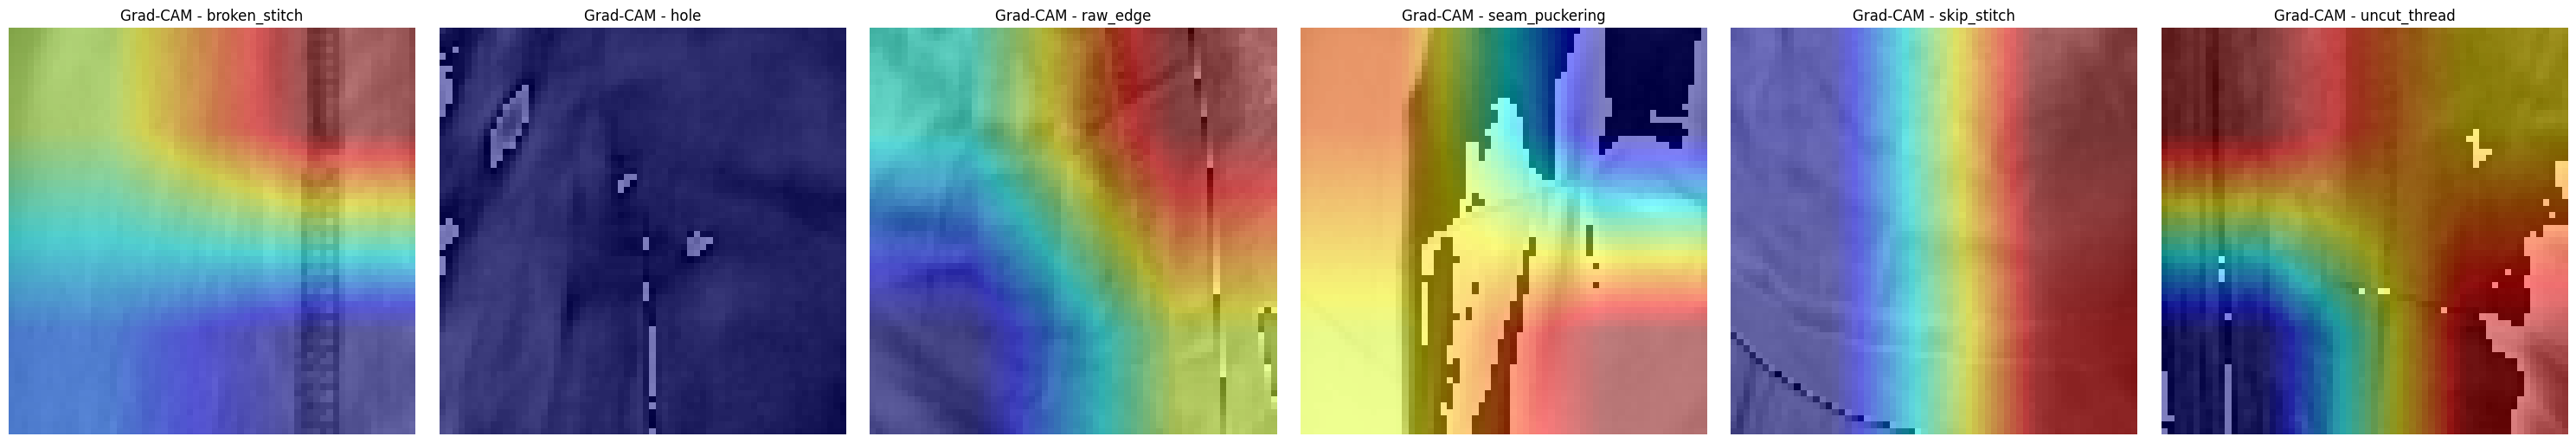

Epoch [21/30]:
  Training Loss: 0.0100, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.5154, Accuracy: 82.50%, Precision: 0.85, Recall: 0.82, F1: 0.83
--------------------------------------------------------------------------------


Epoch [22/30]:
  Training Loss: 0.0078, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4899, Accuracy: 87.50%, Precision: 0.90, Recall: 0.88, F1: 0.88
--------------------------------------------------------------------------------


Epoch [23/30]:
  Training Loss: 0.0081, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4624, Accuracy: 87.50%, Precision: 0.89, Recall: 0.88, F1: 0.87
--------------------------------------------------------------------------------


Epoch [24/30]:
  Training Loss: 0.0062, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4687, Accuracy: 87.50%, Precision: 0.89, Recall: 0.88, F1: 0.87
--------------------------------------------------------------------------------


Epoch [25/30]:
  Training Loss: 0.0037, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4985, Accuracy: 87.50%, Precision: 0.89, Recall: 0.88, F1: 0.87
--------------------------------------------------------------------------------


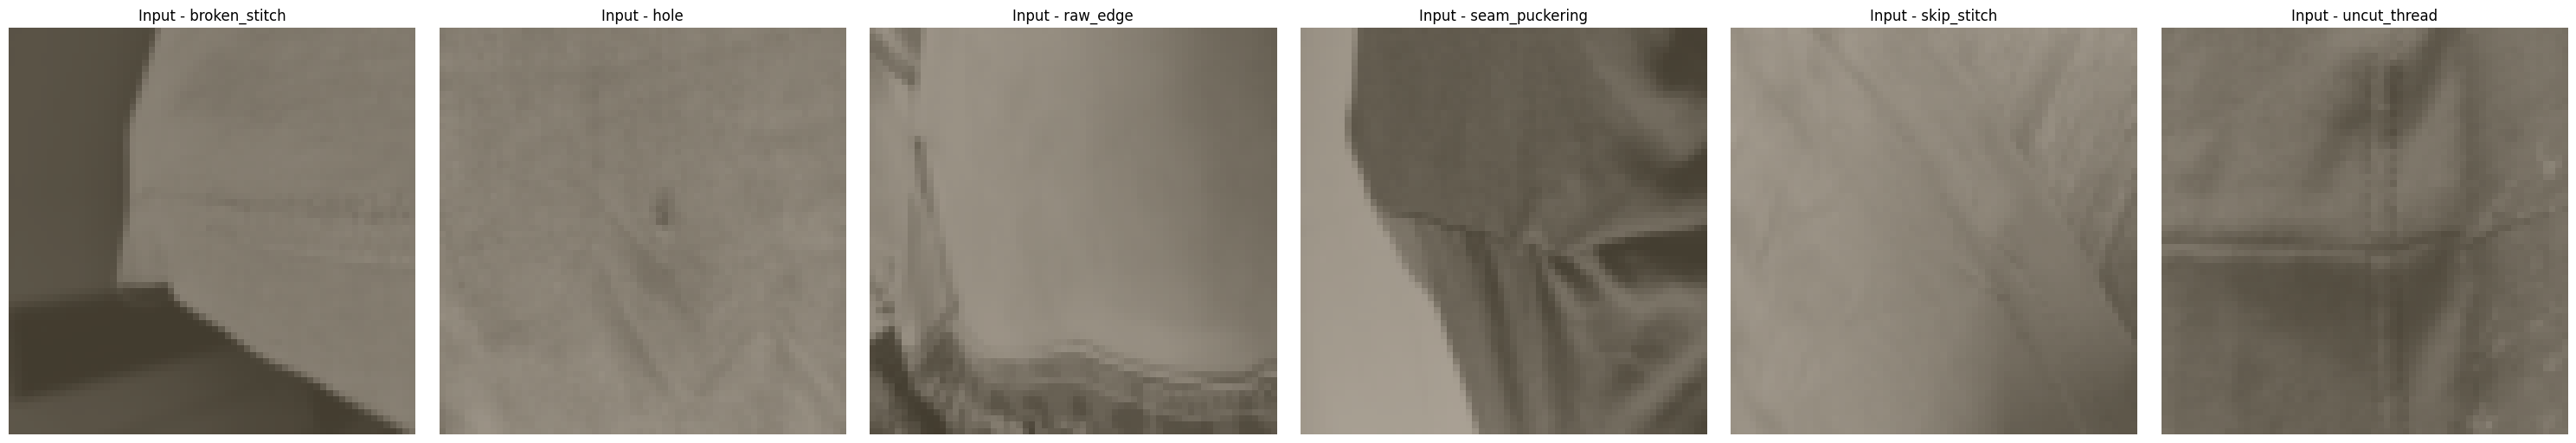

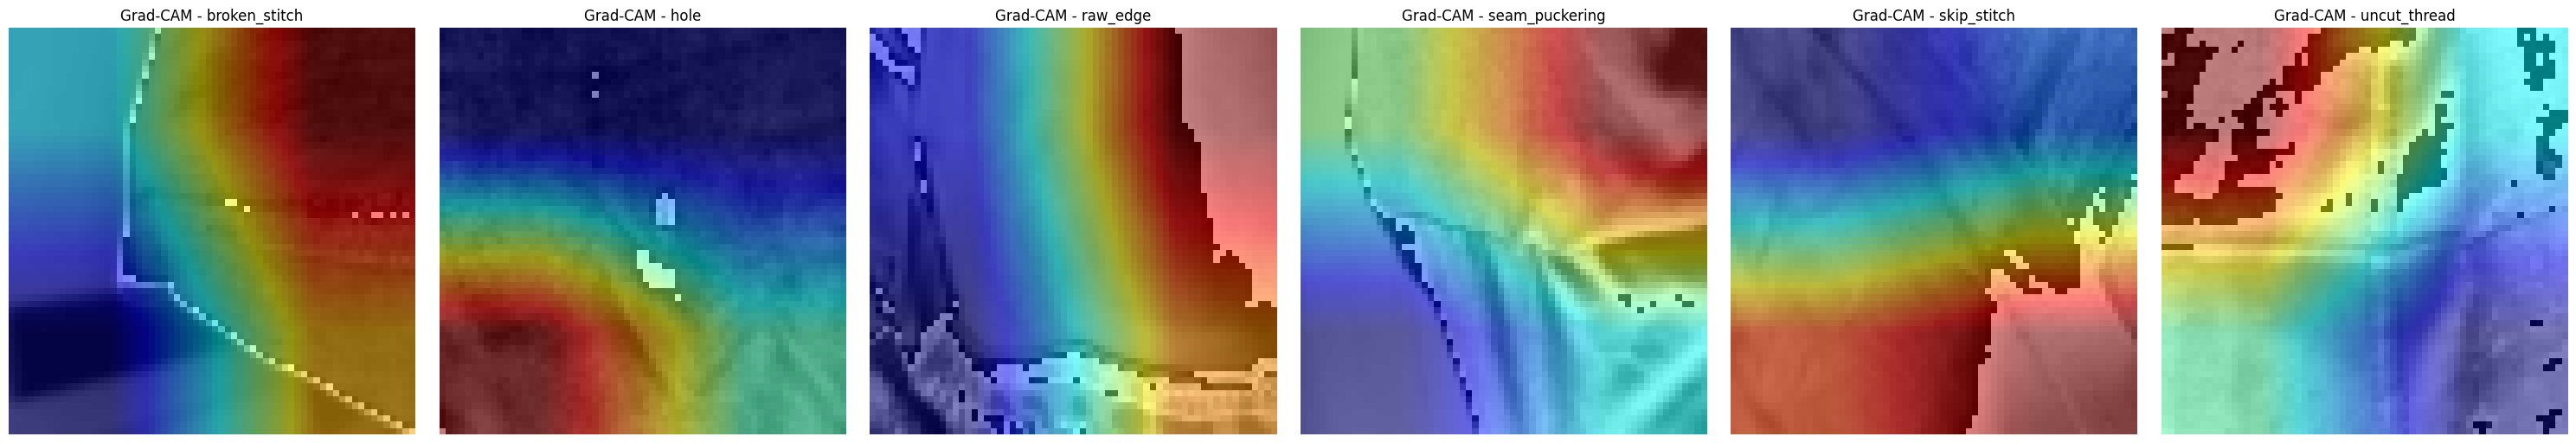

Epoch [26/30]:
  Training Loss: 0.0060, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4895, Accuracy: 87.50%, Precision: 0.89, Recall: 0.88, F1: 0.87
--------------------------------------------------------------------------------


Epoch [27/30]:
  Training Loss: 0.0054, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4730, Accuracy: 87.50%, Precision: 0.90, Recall: 0.88, F1: 0.88
--------------------------------------------------------------------------------


Epoch [28/30]:
  Training Loss: 0.0055, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4526, Accuracy: 87.50%, Precision: 0.89, Recall: 0.88, F1: 0.87
--------------------------------------------------------------------------------


Epoch [29/30]:
  Training Loss: 0.0027, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.4683, Accuracy: 87.50%, Precision: 0.89, Recall: 0.88, F1: 0.87
--------------------------------------------------------------------------------


Epoch [30/30]:
  Training Loss: 0.0058, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.5071, Accuracy: 87.50%, Precision: 0.89, Recall: 0.88, F1: 0.87
--------------------------------------------------------------------------------


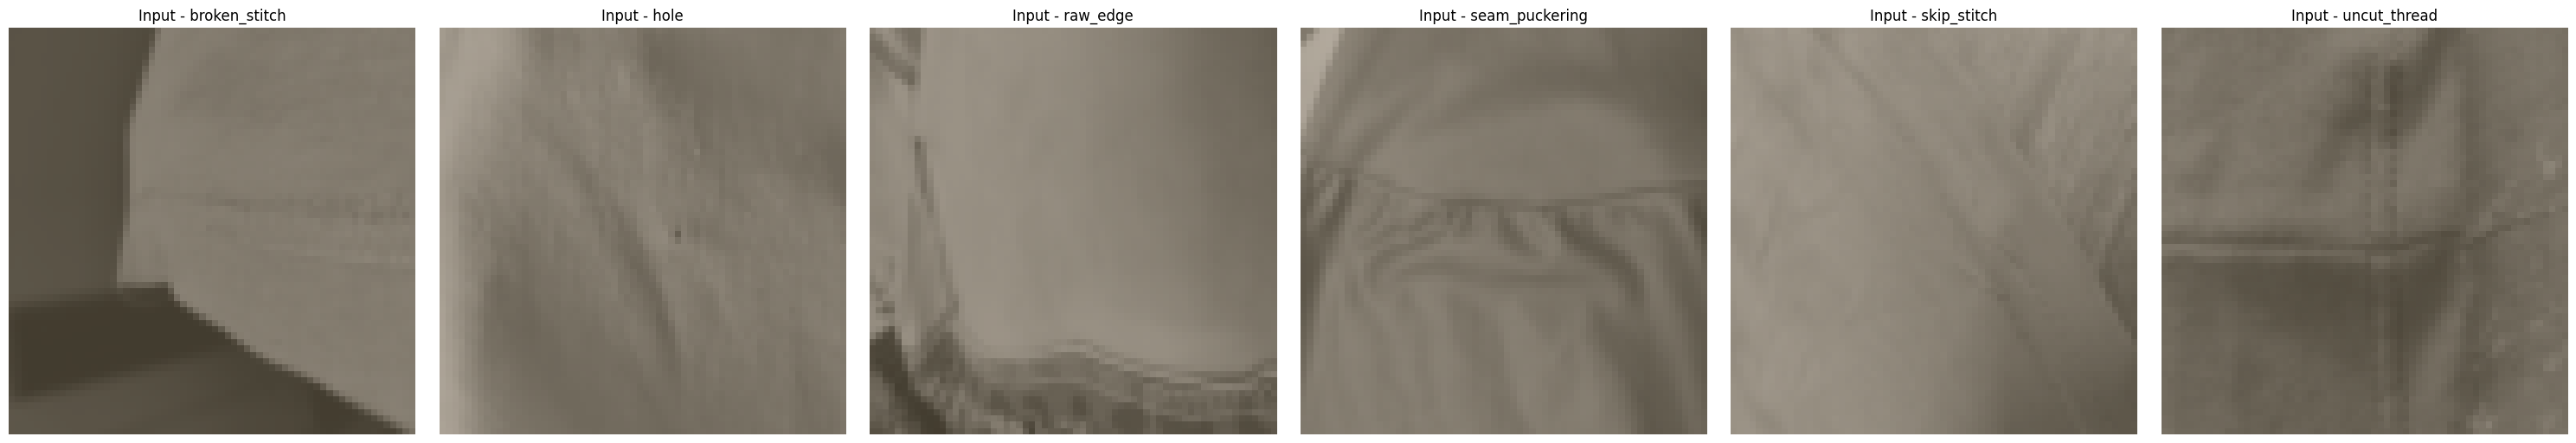

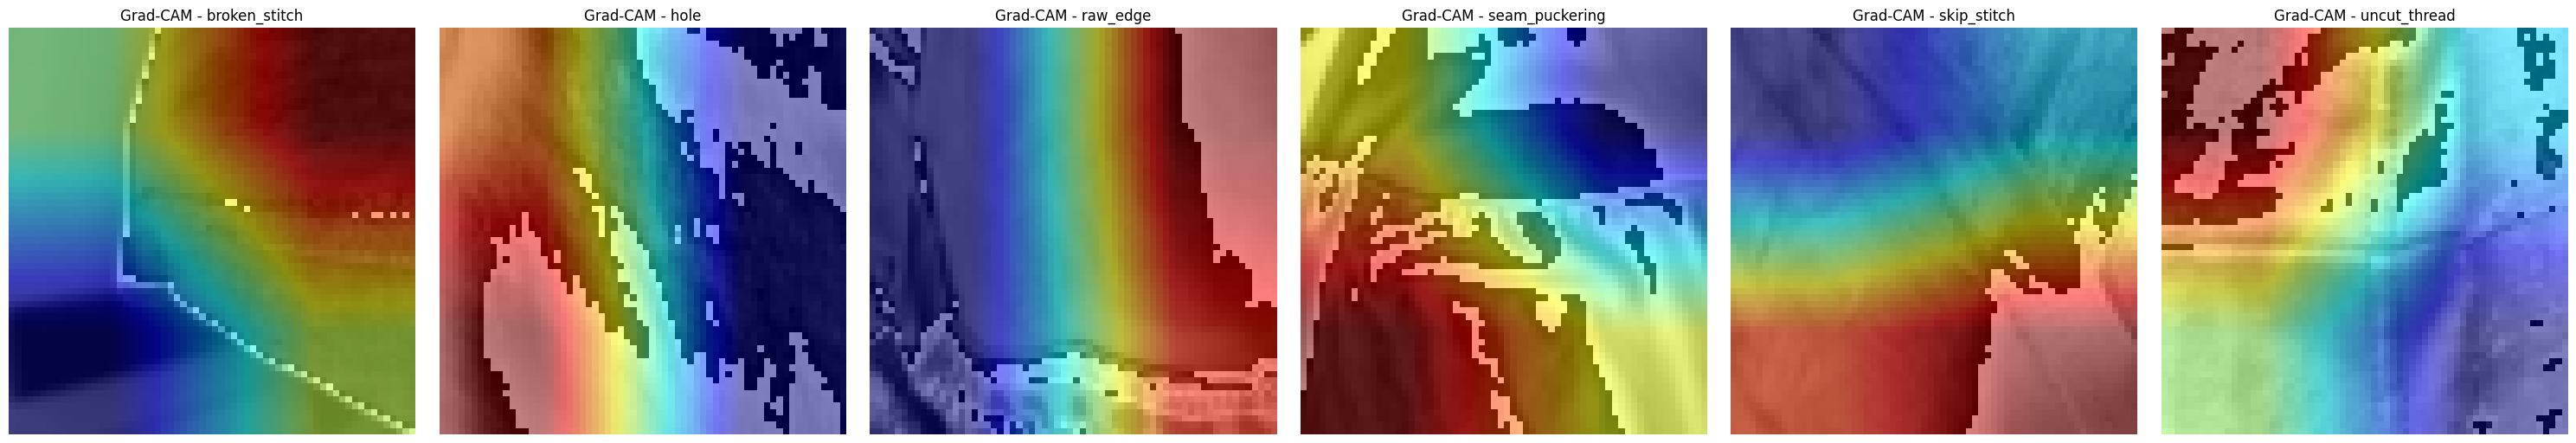

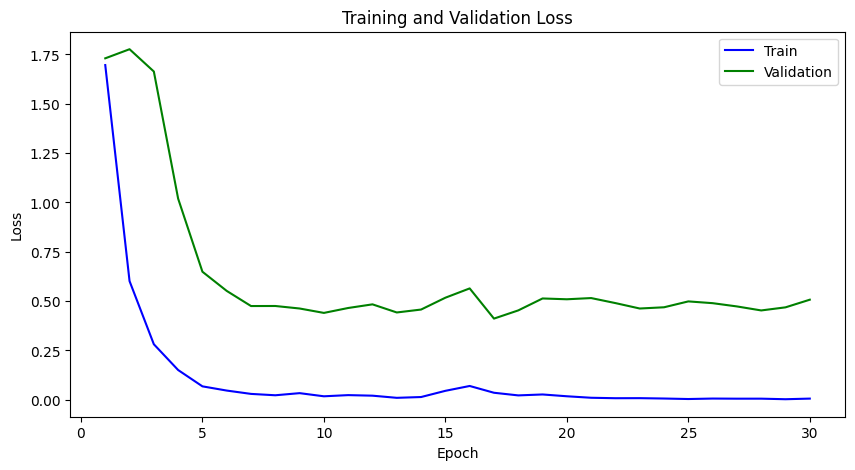

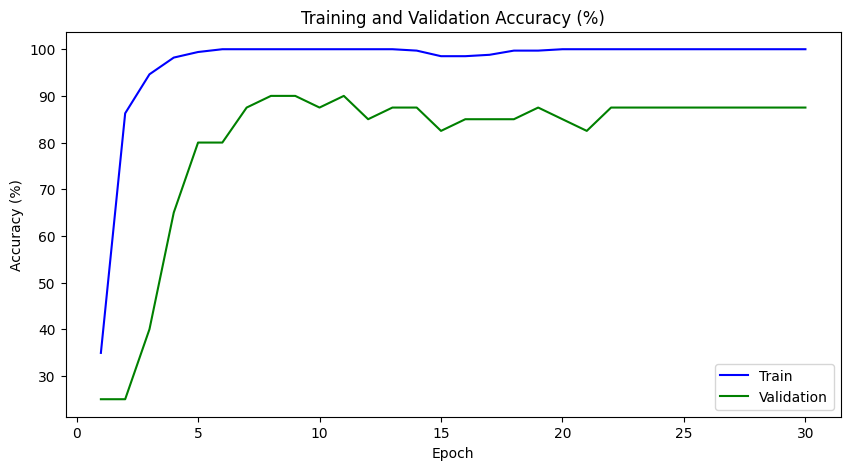

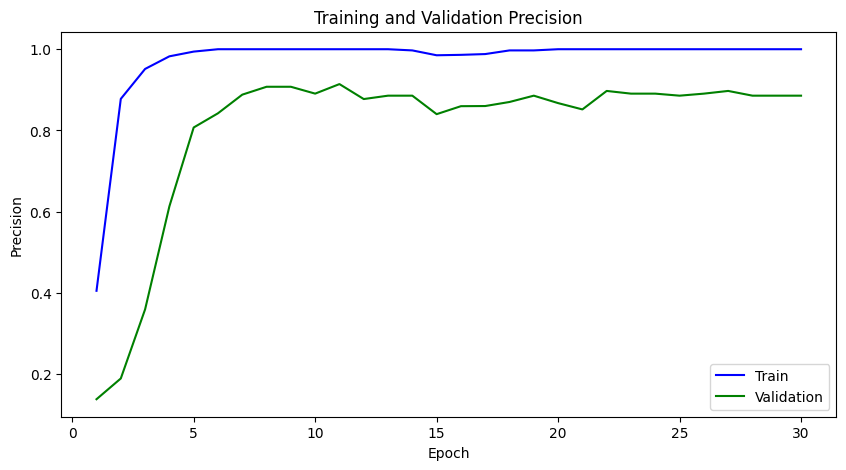

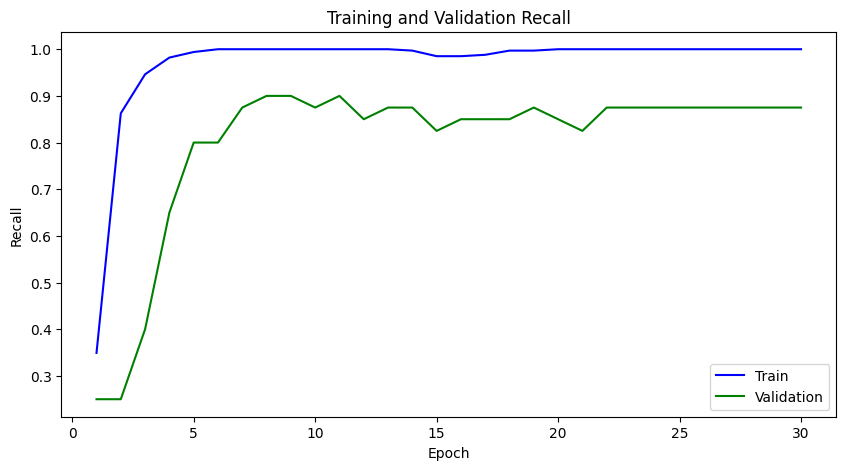

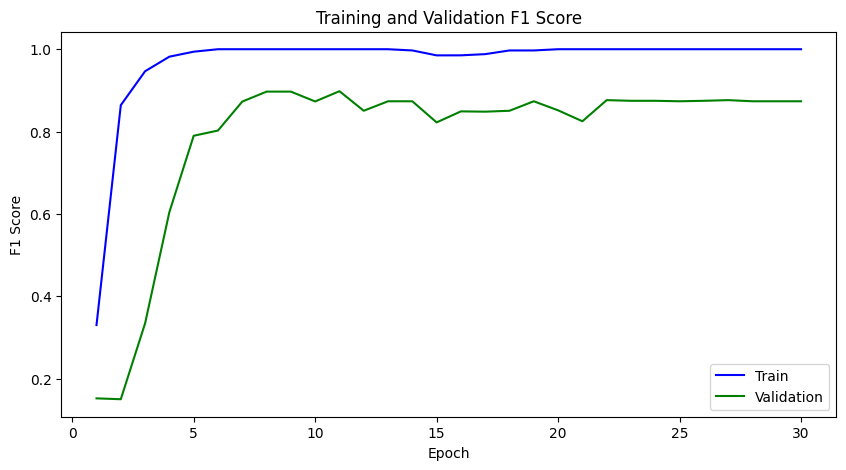

In [ ]:
train_model_with_metrics_tqdm(model_resnet,train_loader, valid_loader, criterion_restnet, optimizer_restnet, num_epochs=30)

## Efficient Net

Epoch [1/30]:
  Training Loss: 1.8267, Accuracy: 18.81%, Precision: 0.18, Recall: 0.19, F1: 0.18
  Validation Loss: 1.8077, Accuracy: 17.50%, Precision: 0.09, Recall: 0.17, F1: 0.12
--------------------------------------------------------------------------------


Epoch [2/30]:
  Training Loss: 1.6334, Accuracy: 33.73%, Precision: 0.32, Recall: 0.34, F1: 0.32
  Validation Loss: 1.8364, Accuracy: 15.00%, Precision: 0.10, Recall: 0.15, F1: 0.10
--------------------------------------------------------------------------------


Epoch [3/30]:
  Training Loss: 1.4506, Accuracy: 48.66%, Precision: 0.49, Recall: 0.49, F1: 0.48
  Validation Loss: 1.8323, Accuracy: 15.00%, Precision: 0.19, Recall: 0.15, F1: 0.13
--------------------------------------------------------------------------------


Epoch [4/30]:
  Training Loss: 1.2960, Accuracy: 61.19%, Precision: 0.61, Recall: 0.61, F1: 0.60
  Validation Loss: 1.8230, Accuracy: 20.00%, Precision: 0.24, Recall: 0.20, F1: 0.18
--------------------------------------------------------------------------------


Epoch [5/30]:
  Training Loss: 1.1903, Accuracy: 70.15%, Precision: 0.71, Recall: 0.70, F1: 0.70
  Validation Loss: 1.7860, Accuracy: 20.00%, Precision: 0.20, Recall: 0.20, F1: 0.18
--------------------------------------------------------------------------------


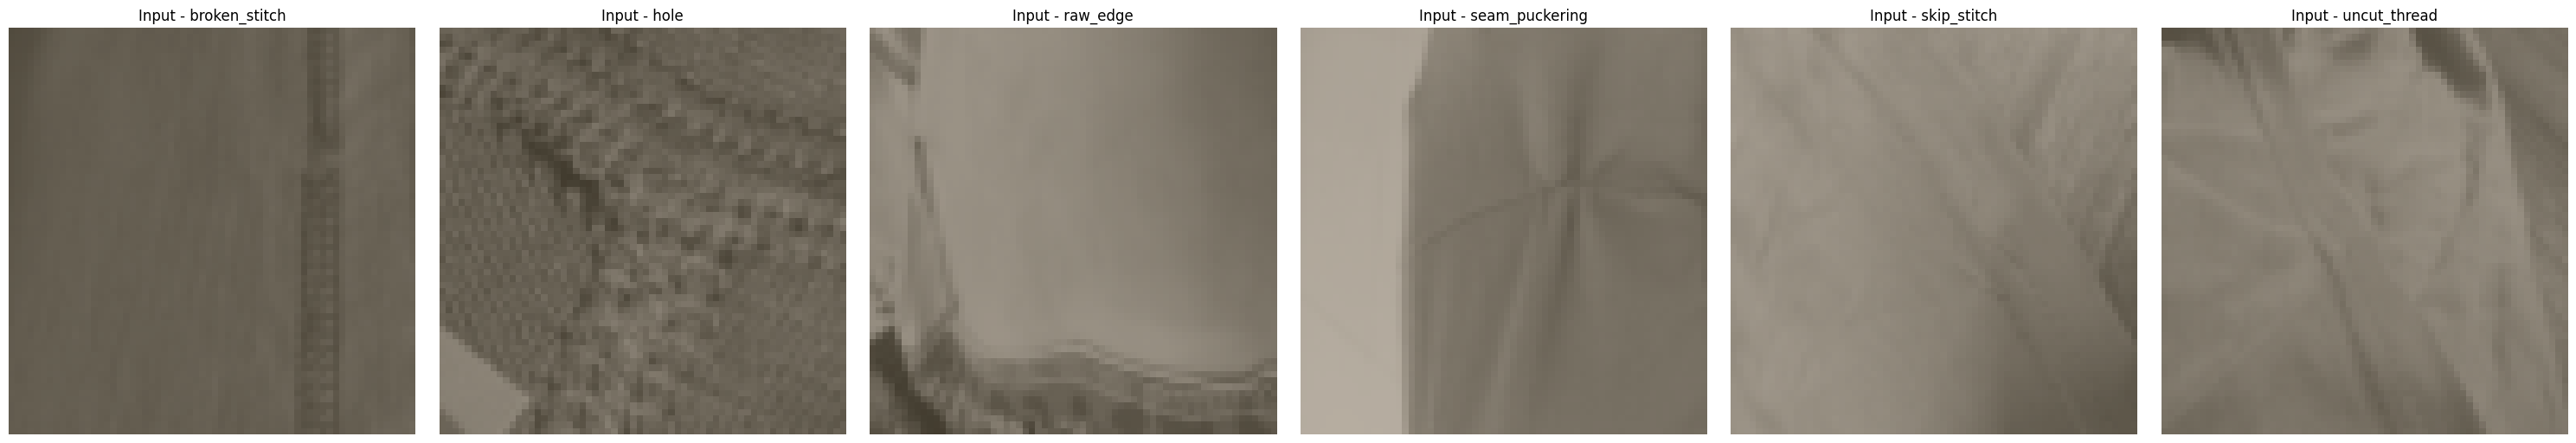

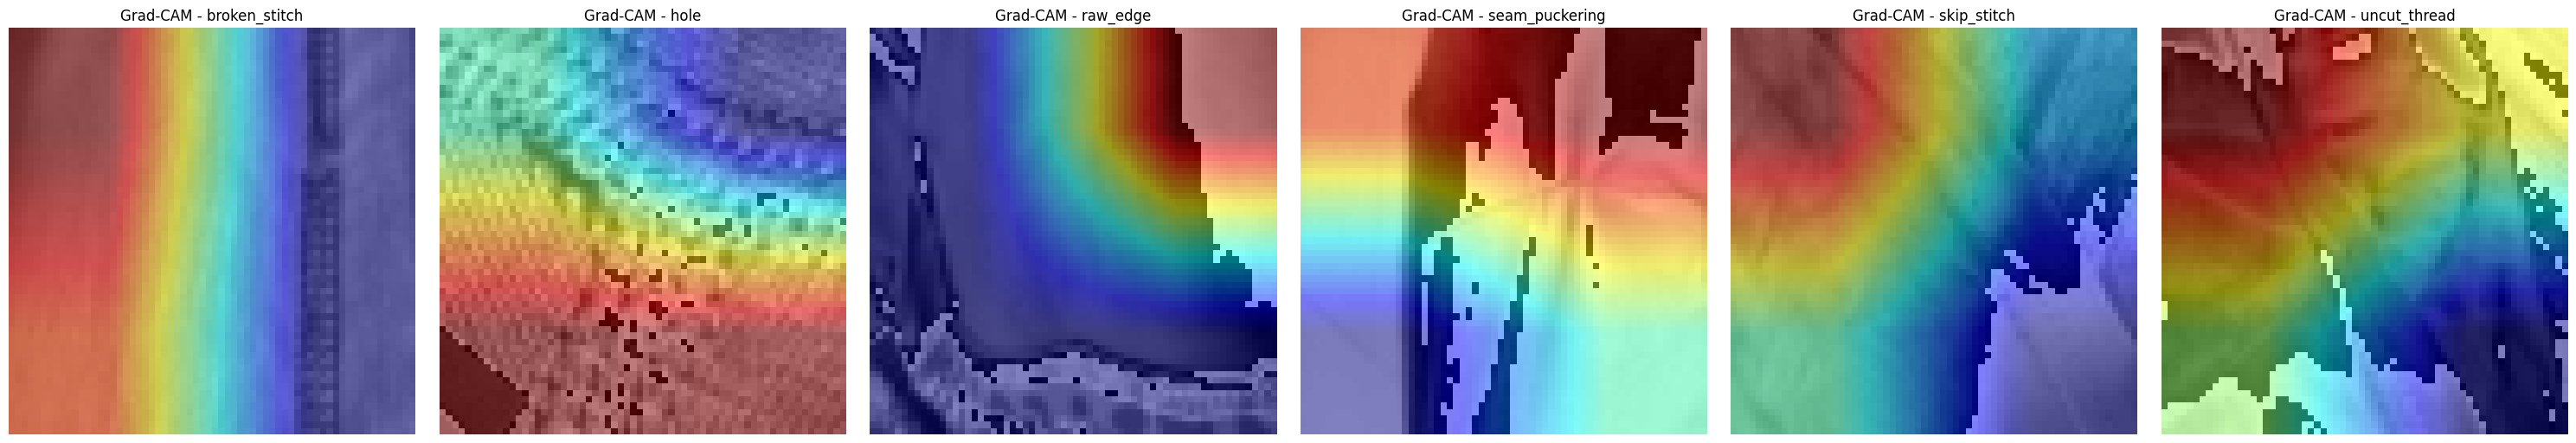

Epoch [6/30]:
  Training Loss: 1.0373, Accuracy: 81.49%, Precision: 0.82, Recall: 0.81, F1: 0.81
  Validation Loss: 1.5225, Accuracy: 52.50%, Precision: 0.63, Recall: 0.53, F1: 0.49
--------------------------------------------------------------------------------


Epoch [7/30]:
  Training Loss: 0.9553, Accuracy: 81.49%, Precision: 0.82, Recall: 0.81, F1: 0.81
  Validation Loss: 1.2993, Accuracy: 70.00%, Precision: 0.67, Recall: 0.70, F1: 0.67
--------------------------------------------------------------------------------


Epoch [8/30]:
  Training Loss: 0.8561, Accuracy: 83.88%, Precision: 0.85, Recall: 0.84, F1: 0.84
  Validation Loss: 1.1462, Accuracy: 70.00%, Precision: 0.69, Recall: 0.70, F1: 0.69
--------------------------------------------------------------------------------


Epoch [9/30]:
  Training Loss: 0.7522, Accuracy: 90.75%, Precision: 0.91, Recall: 0.91, F1: 0.91
  Validation Loss: 1.0433, Accuracy: 75.00%, Precision: 0.74, Recall: 0.75, F1: 0.74
--------------------------------------------------------------------------------


Epoch [10/30]:
  Training Loss: 0.7096, Accuracy: 90.75%, Precision: 0.91, Recall: 0.91, F1: 0.91
  Validation Loss: 0.9441, Accuracy: 77.50%, Precision: 0.76, Recall: 0.78, F1: 0.76
--------------------------------------------------------------------------------


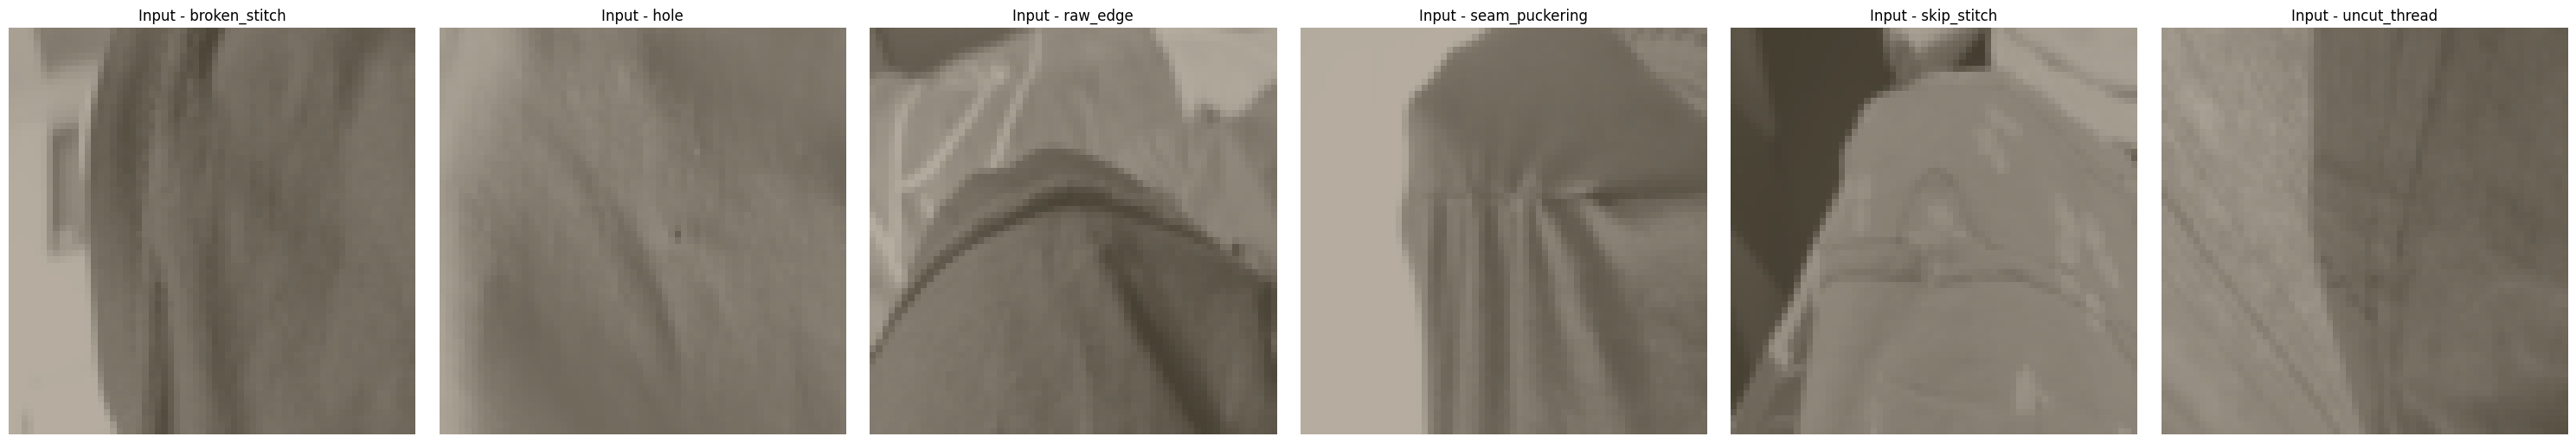

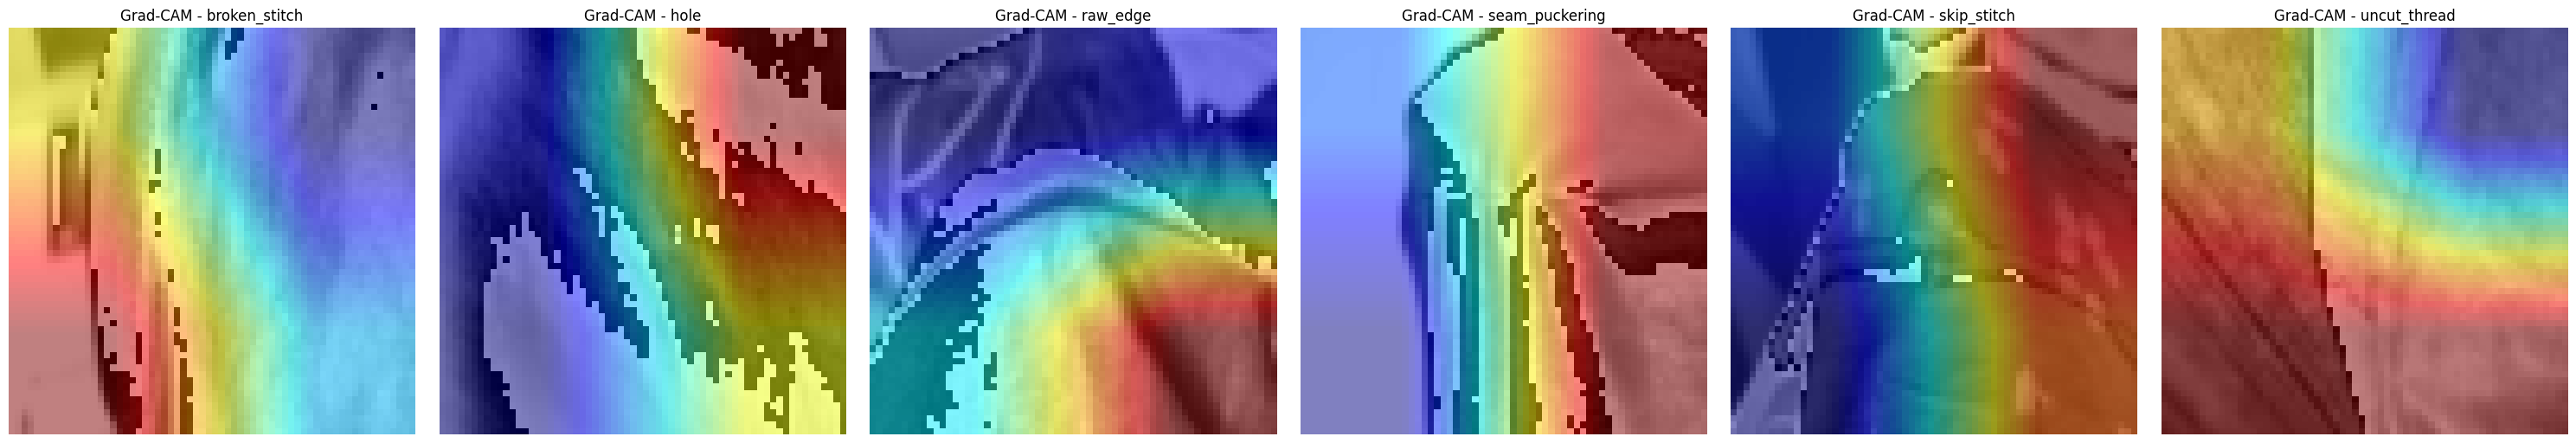

Epoch [11/30]:
  Training Loss: 0.6002, Accuracy: 91.64%, Precision: 0.92, Recall: 0.92, F1: 0.92
  Validation Loss: 0.8803, Accuracy: 80.00%, Precision: 0.80, Recall: 0.80, F1: 0.80
--------------------------------------------------------------------------------


Epoch [12/30]:
  Training Loss: 0.5196, Accuracy: 93.73%, Precision: 0.94, Recall: 0.94, F1: 0.94
  Validation Loss: 0.8675, Accuracy: 77.50%, Precision: 0.78, Recall: 0.78, F1: 0.77
--------------------------------------------------------------------------------


Epoch [13/30]:
  Training Loss: 0.4610, Accuracy: 91.94%, Precision: 0.92, Recall: 0.92, F1: 0.92
  Validation Loss: 0.8141, Accuracy: 80.00%, Precision: 0.81, Recall: 0.80, F1: 0.79
--------------------------------------------------------------------------------


Epoch [14/30]:
  Training Loss: 0.4188, Accuracy: 96.72%, Precision: 0.97, Recall: 0.97, F1: 0.97
  Validation Loss: 0.7724, Accuracy: 80.00%, Precision: 0.80, Recall: 0.80, F1: 0.80
--------------------------------------------------------------------------------


Epoch [15/30]:
  Training Loss: 0.3516, Accuracy: 96.72%, Precision: 0.97, Recall: 0.97, F1: 0.97
  Validation Loss: 0.7360, Accuracy: 80.00%, Precision: 0.80, Recall: 0.80, F1: 0.80
--------------------------------------------------------------------------------


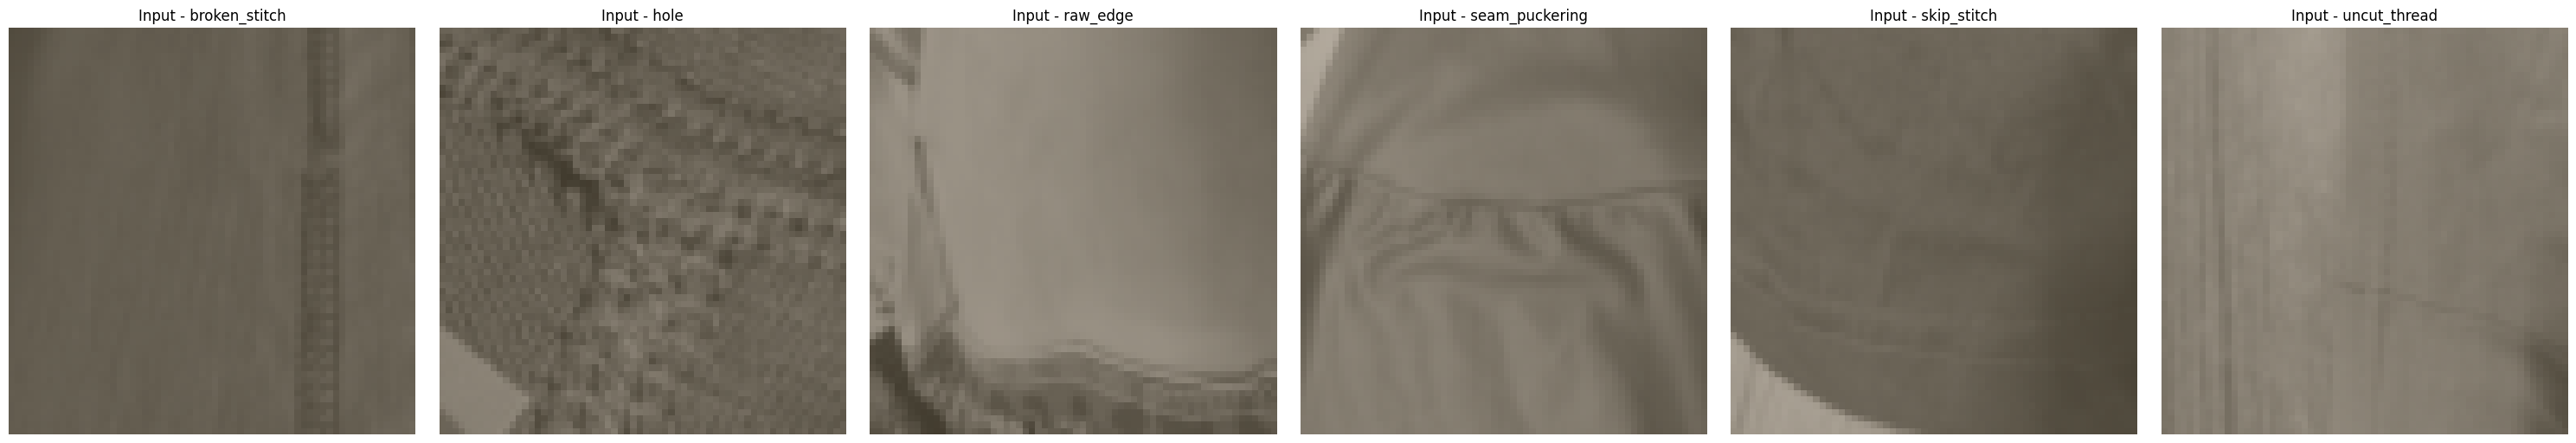

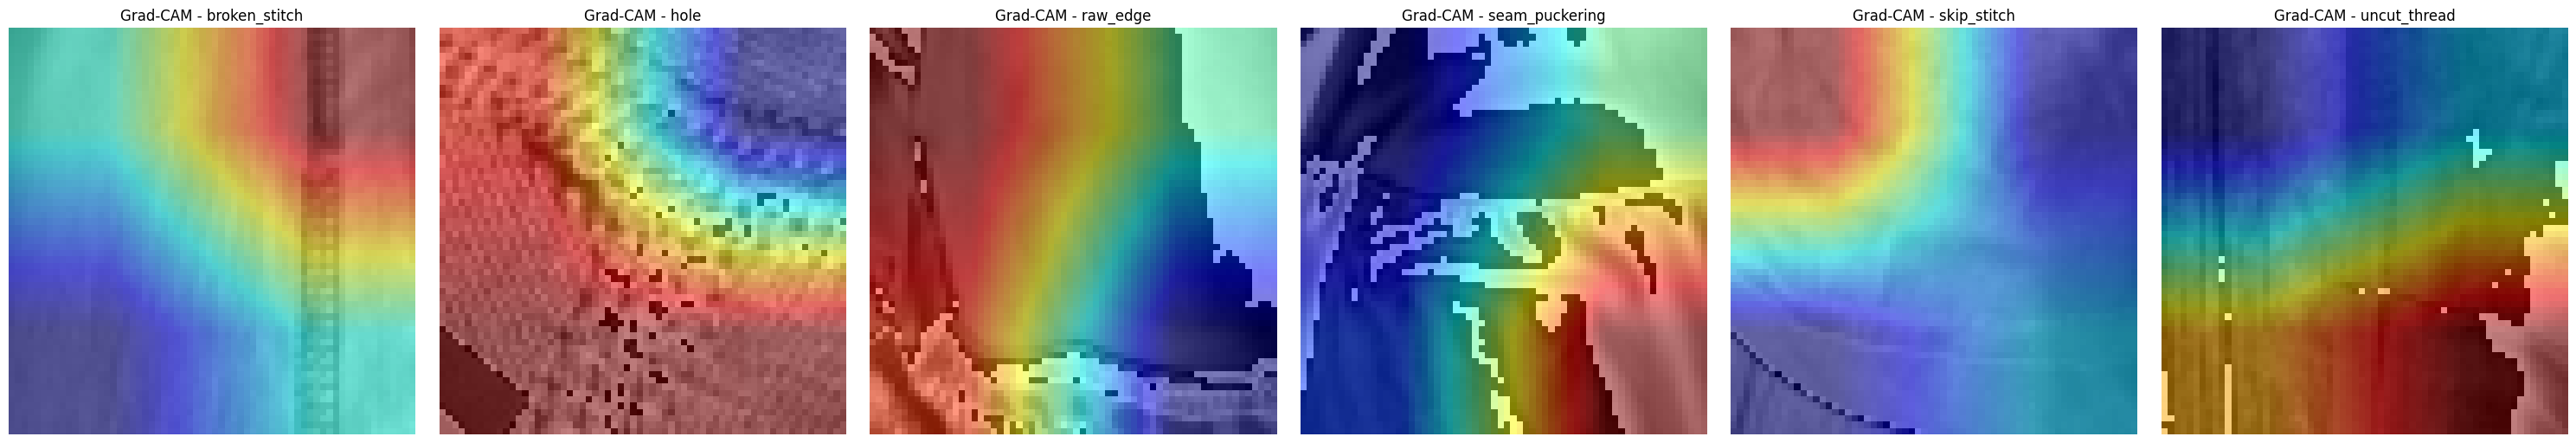

Epoch [16/30]:
  Training Loss: 0.3004, Accuracy: 97.31%, Precision: 0.97, Recall: 0.97, F1: 0.97
  Validation Loss: 0.7216, Accuracy: 80.00%, Precision: 0.80, Recall: 0.80, F1: 0.80
--------------------------------------------------------------------------------


Epoch [17/30]:
  Training Loss: 0.2888, Accuracy: 97.61%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.6872, Accuracy: 80.00%, Precision: 0.80, Recall: 0.80, F1: 0.80
--------------------------------------------------------------------------------


Epoch [18/30]:
  Training Loss: 0.2441, Accuracy: 97.61%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.6658, Accuracy: 80.00%, Precision: 0.80, Recall: 0.80, F1: 0.80
--------------------------------------------------------------------------------


Epoch [19/30]:
  Training Loss: 0.2296, Accuracy: 97.61%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.6348, Accuracy: 80.00%, Precision: 0.80, Recall: 0.80, F1: 0.80
--------------------------------------------------------------------------------


Epoch [20/30]:
  Training Loss: 0.2069, Accuracy: 97.61%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.6139, Accuracy: 80.00%, Precision: 0.80, Recall: 0.80, F1: 0.80
--------------------------------------------------------------------------------


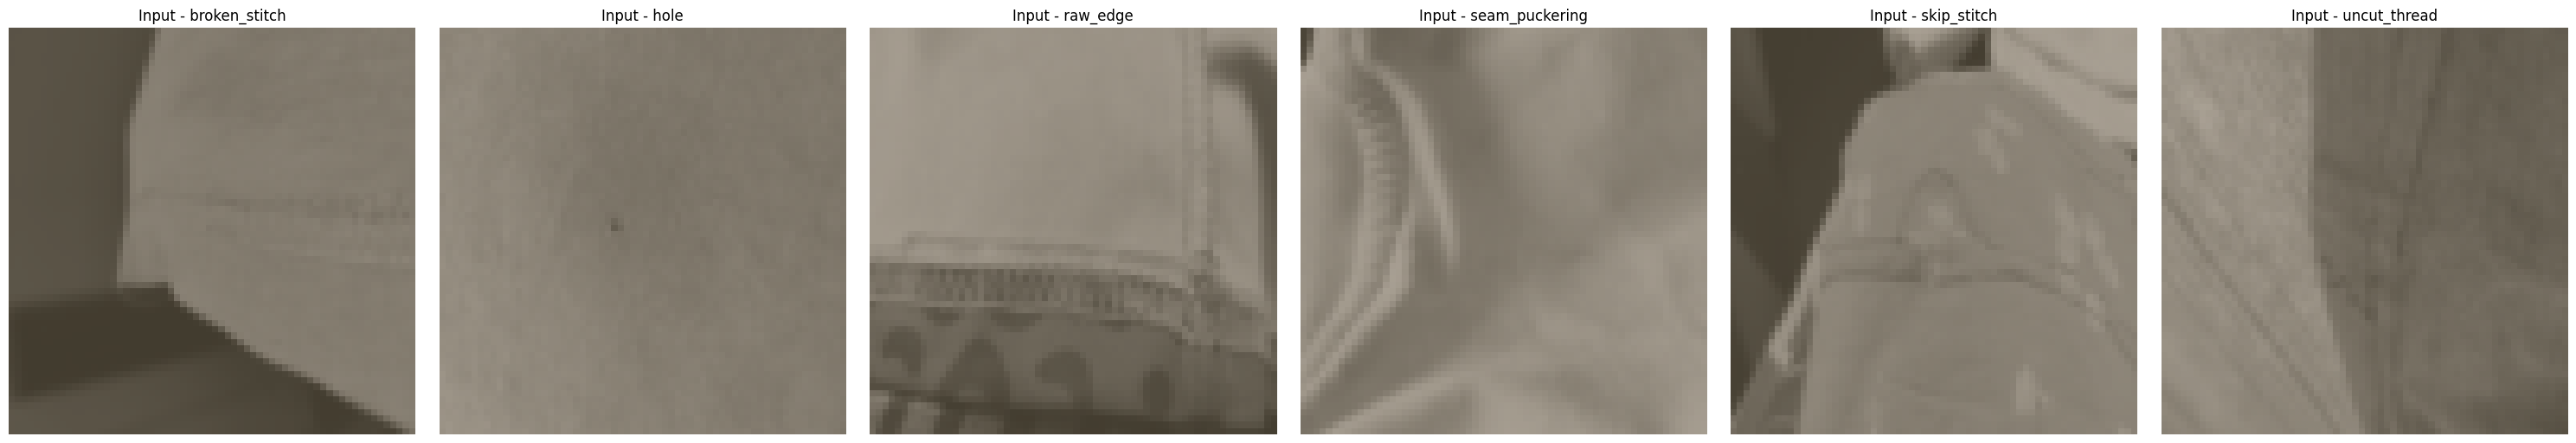

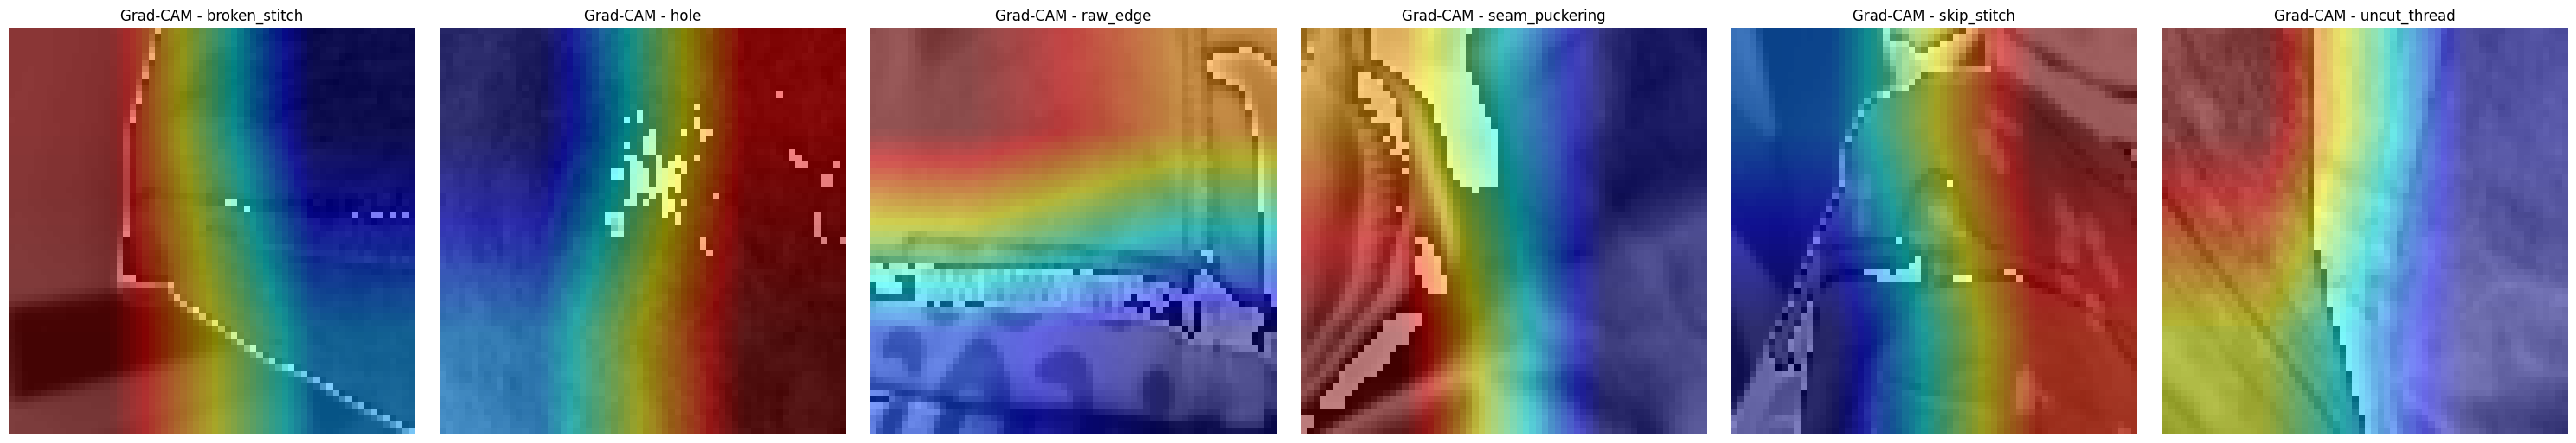

Epoch [21/30]:
  Training Loss: 0.2351, Accuracy: 97.61%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.6074, Accuracy: 80.00%, Precision: 0.80, Recall: 0.80, F1: 0.80
--------------------------------------------------------------------------------


Epoch [22/30]:
  Training Loss: 0.1930, Accuracy: 97.31%, Precision: 0.97, Recall: 0.97, F1: 0.97
  Validation Loss: 0.5468, Accuracy: 82.50%, Precision: 0.82, Recall: 0.82, F1: 0.82
--------------------------------------------------------------------------------


Epoch [23/30]:
  Training Loss: 0.1446, Accuracy: 99.70%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.5432, Accuracy: 82.50%, Precision: 0.82, Recall: 0.82, F1: 0.82
--------------------------------------------------------------------------------


Epoch [24/30]:
  Training Loss: 0.1349, Accuracy: 99.10%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.5596, Accuracy: 82.50%, Precision: 0.82, Recall: 0.82, F1: 0.82
--------------------------------------------------------------------------------


Epoch [25/30]:
  Training Loss: 0.1032, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.5546, Accuracy: 85.00%, Precision: 0.86, Recall: 0.85, F1: 0.85
--------------------------------------------------------------------------------


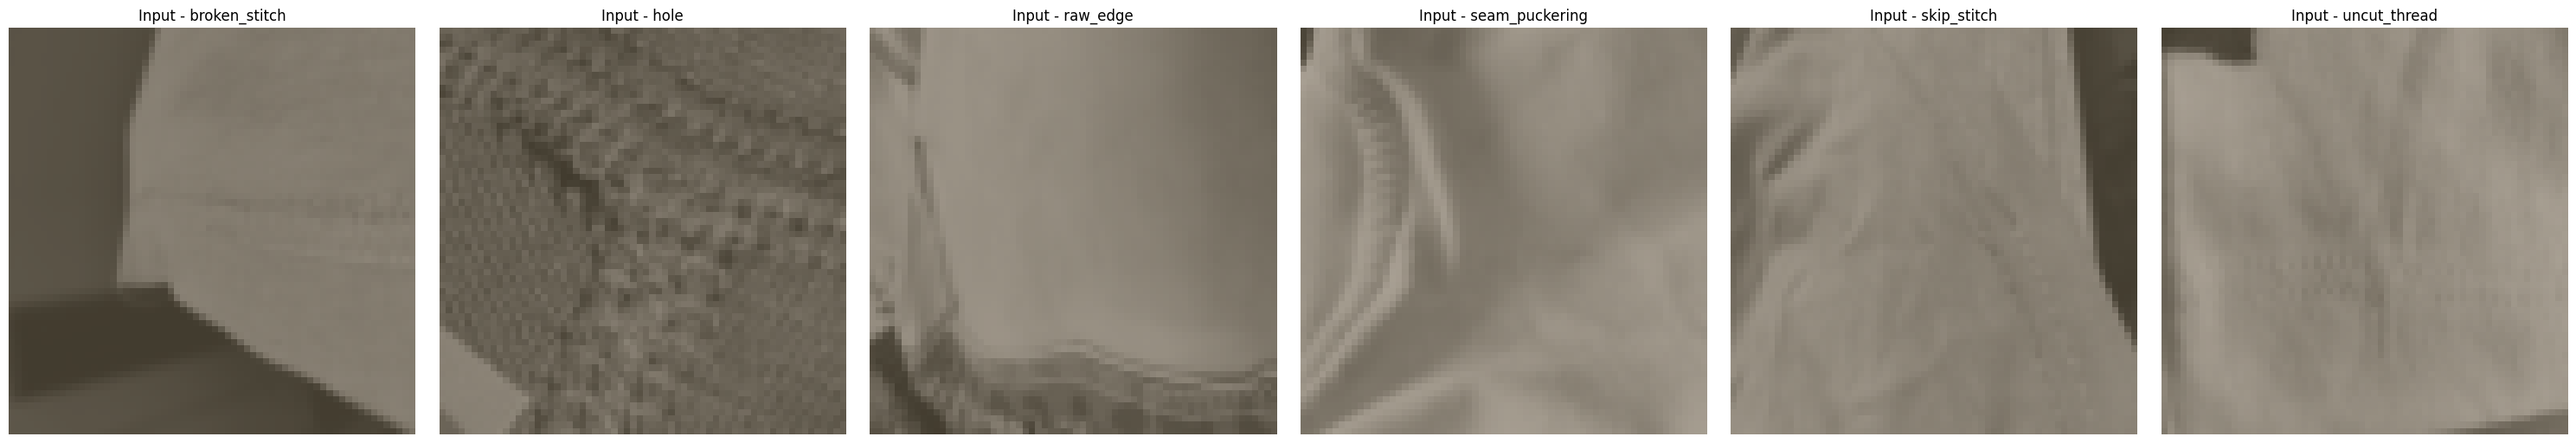

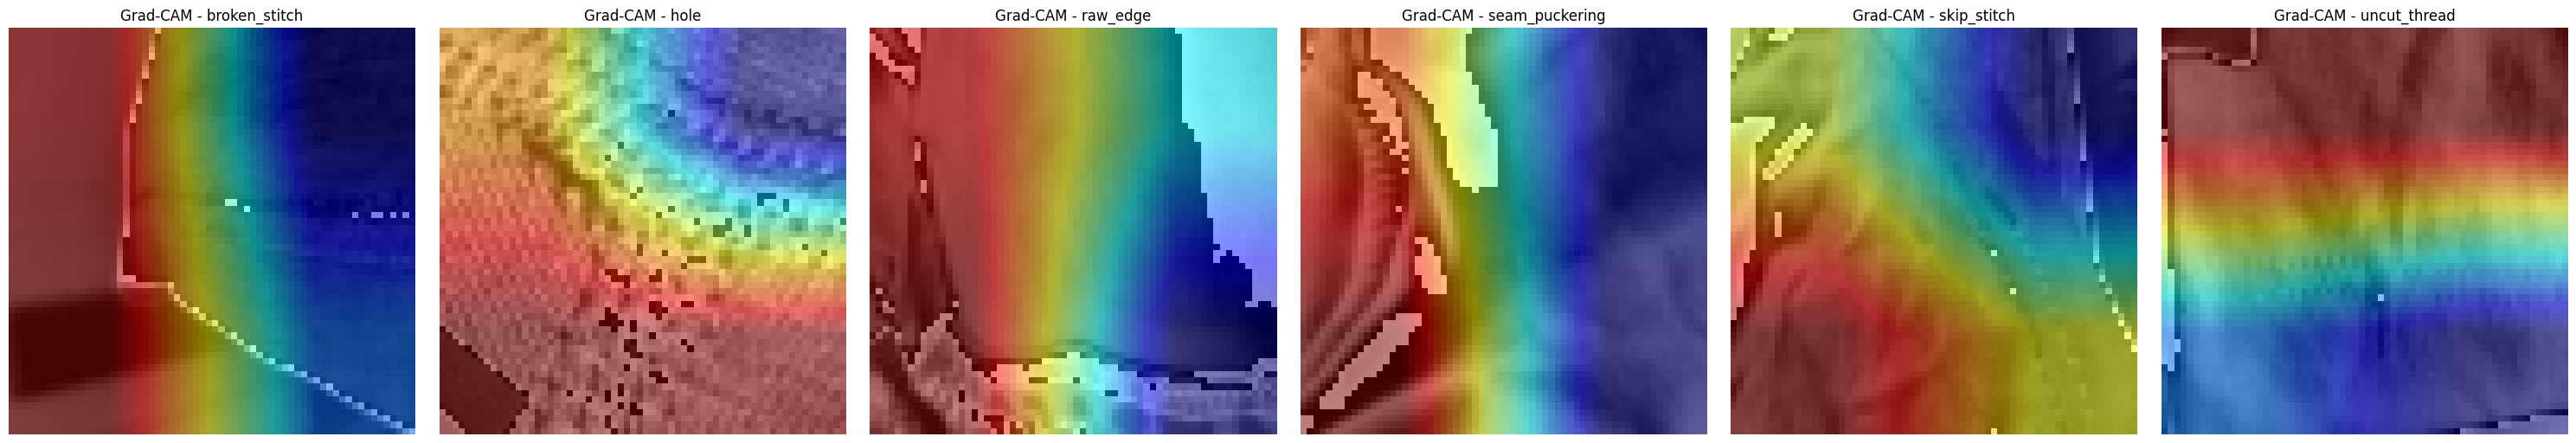

Epoch [26/30]:
  Training Loss: 0.1133, Accuracy: 99.10%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.5501, Accuracy: 82.50%, Precision: 0.82, Recall: 0.82, F1: 0.82
--------------------------------------------------------------------------------


Epoch [27/30]:
  Training Loss: 0.1088, Accuracy: 99.40%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.5508, Accuracy: 82.50%, Precision: 0.82, Recall: 0.82, F1: 0.82
--------------------------------------------------------------------------------


Epoch [28/30]:
  Training Loss: 0.0701, Accuracy: 99.10%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.5502, Accuracy: 82.50%, Precision: 0.84, Recall: 0.82, F1: 0.82
--------------------------------------------------------------------------------


Epoch [29/30]:
  Training Loss: 0.1077, Accuracy: 97.91%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.5481, Accuracy: 82.50%, Precision: 0.84, Recall: 0.82, F1: 0.82
--------------------------------------------------------------------------------


Epoch [30/30]:
  Training Loss: 0.0667, Accuracy: 99.70%, Precision: 1.00, Recall: 1.00, F1: 1.00
  Validation Loss: 0.5315, Accuracy: 82.50%, Precision: 0.84, Recall: 0.82, F1: 0.82
--------------------------------------------------------------------------------


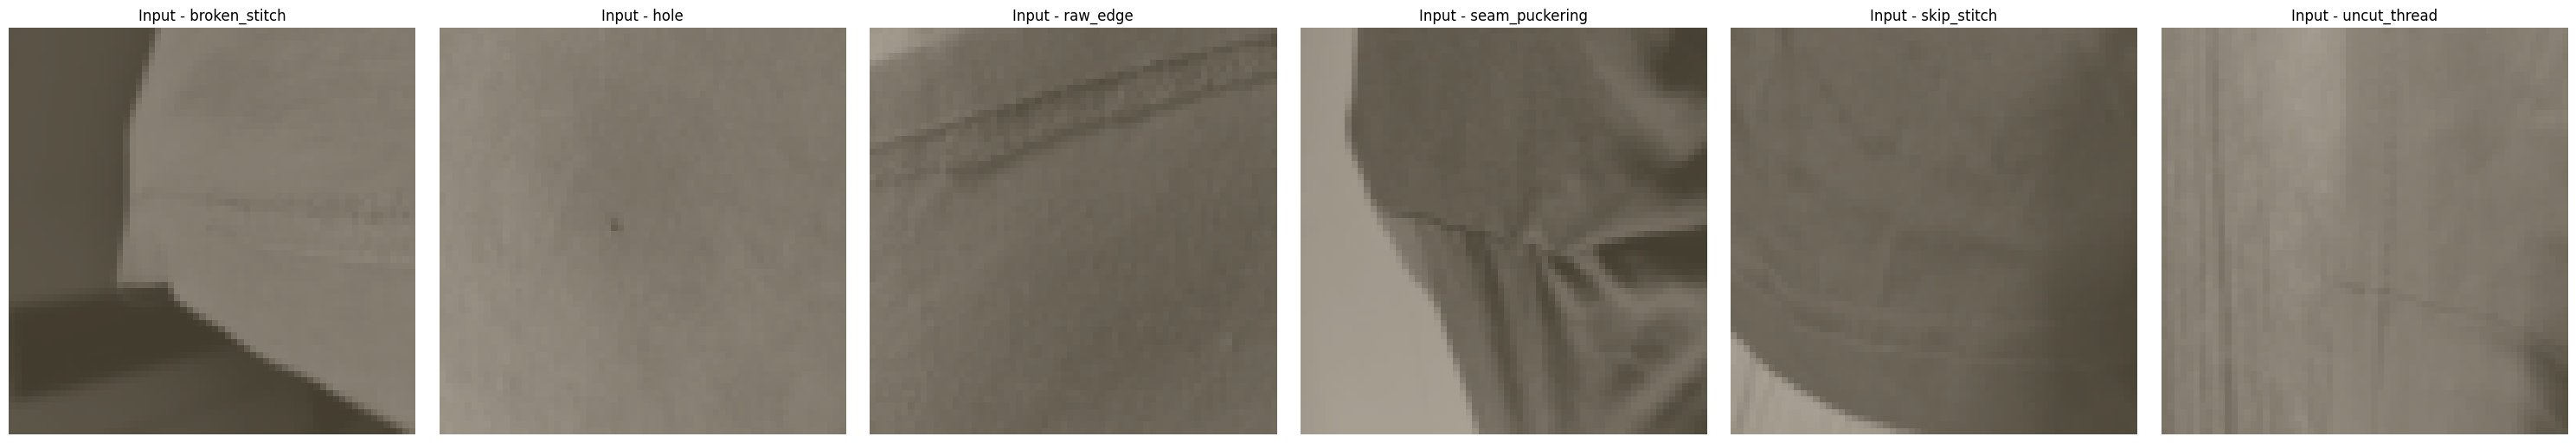

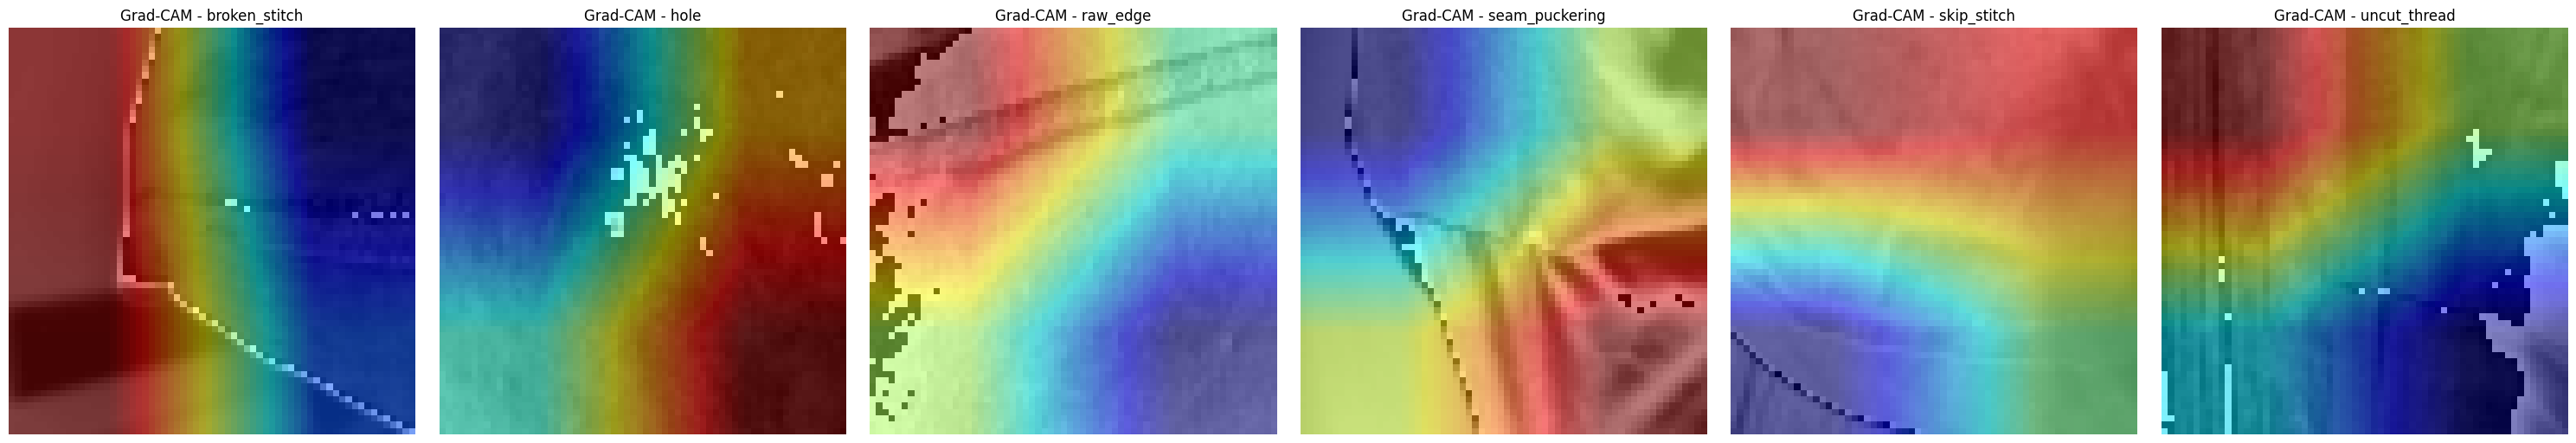

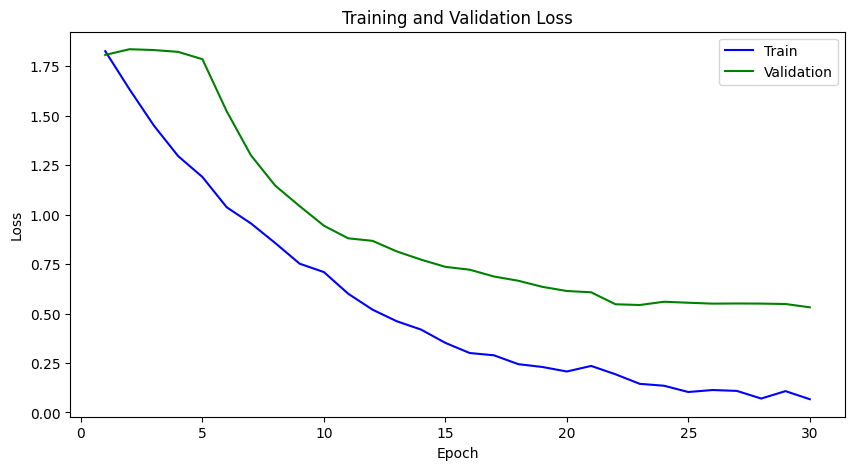

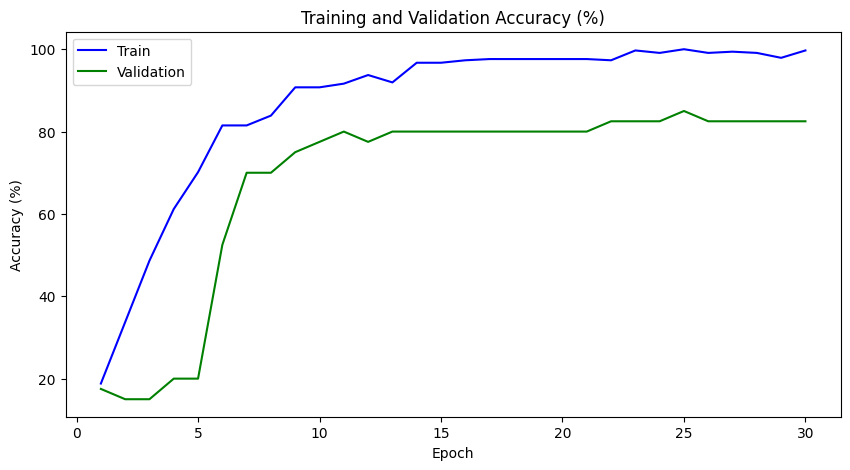

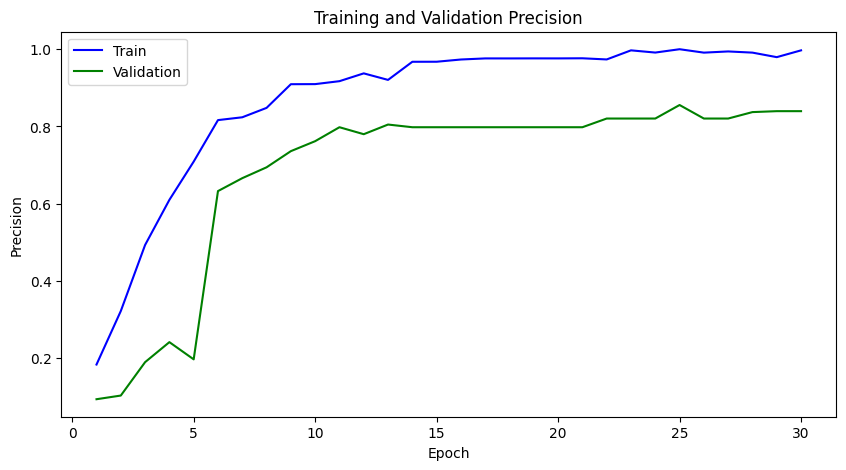

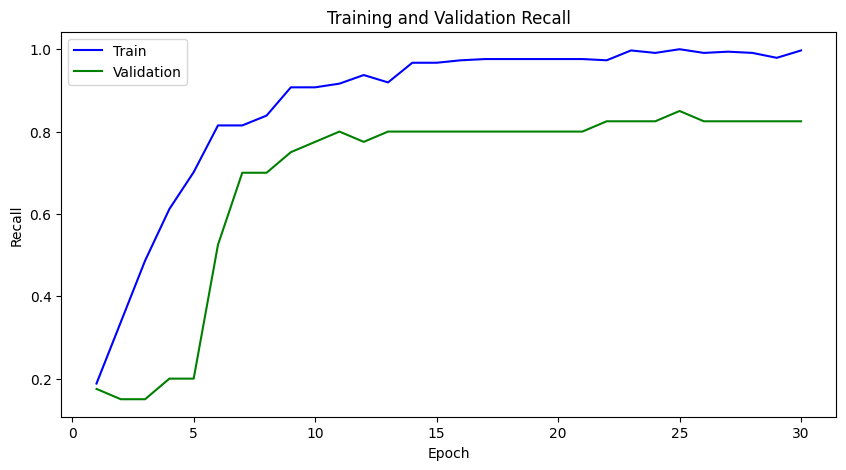

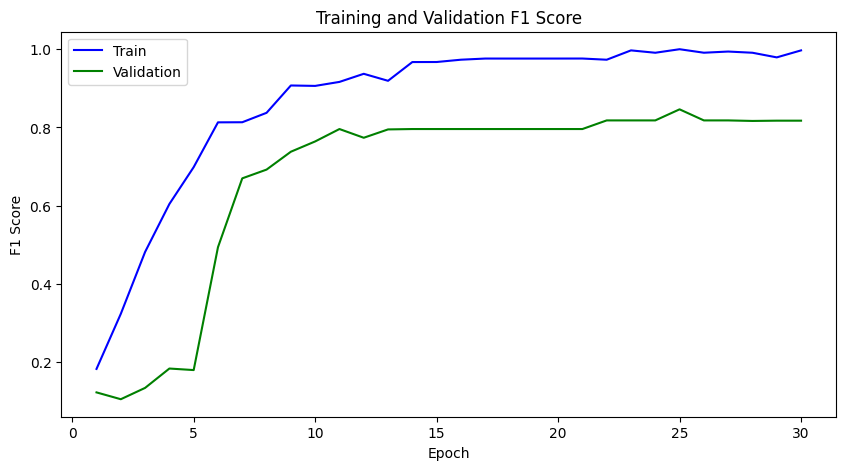

In [ ]:
train_model_with_metrics_tqdm(model_efficient,train_loader, valid_loader, criterion_efficient, optimizer_efficient, num_epochs=30)

# Output Prediction


📊 Results for: Intial Model
   Accuracy  : 77.08%
   Precision : 0.7760
   Recall    : 0.7708
   F1 Score  : 0.7565
   Classification Report:
                precision    recall  f1-score   support

 broken_stitch       0.83      0.56      0.67         9
          hole       0.75      1.00      0.86         9
      raw_edge       0.75      0.86      0.80         7
seam_puckering       0.75      0.90      0.82        10
   skip_stitch       0.83      0.83      0.83         6
  uncut_thread       0.75      0.43      0.55         7

      accuracy                           0.77        48
     macro avg       0.78      0.76      0.75        48
  weighted avg       0.78      0.77      0.76        48



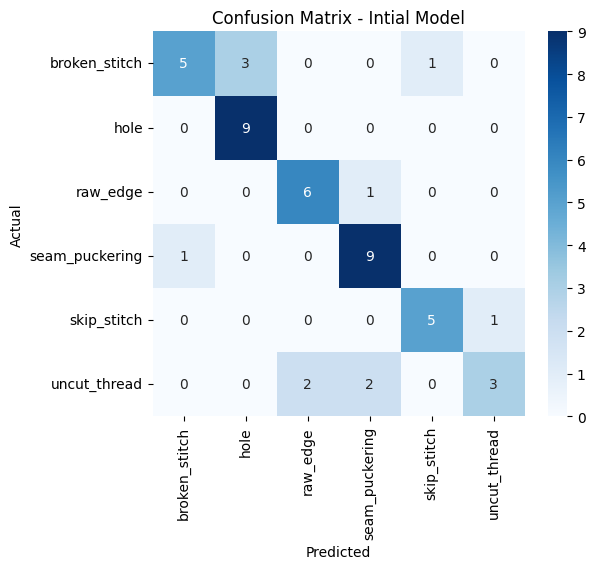


🧠 Grad-CAM Visualizations for Intial Model


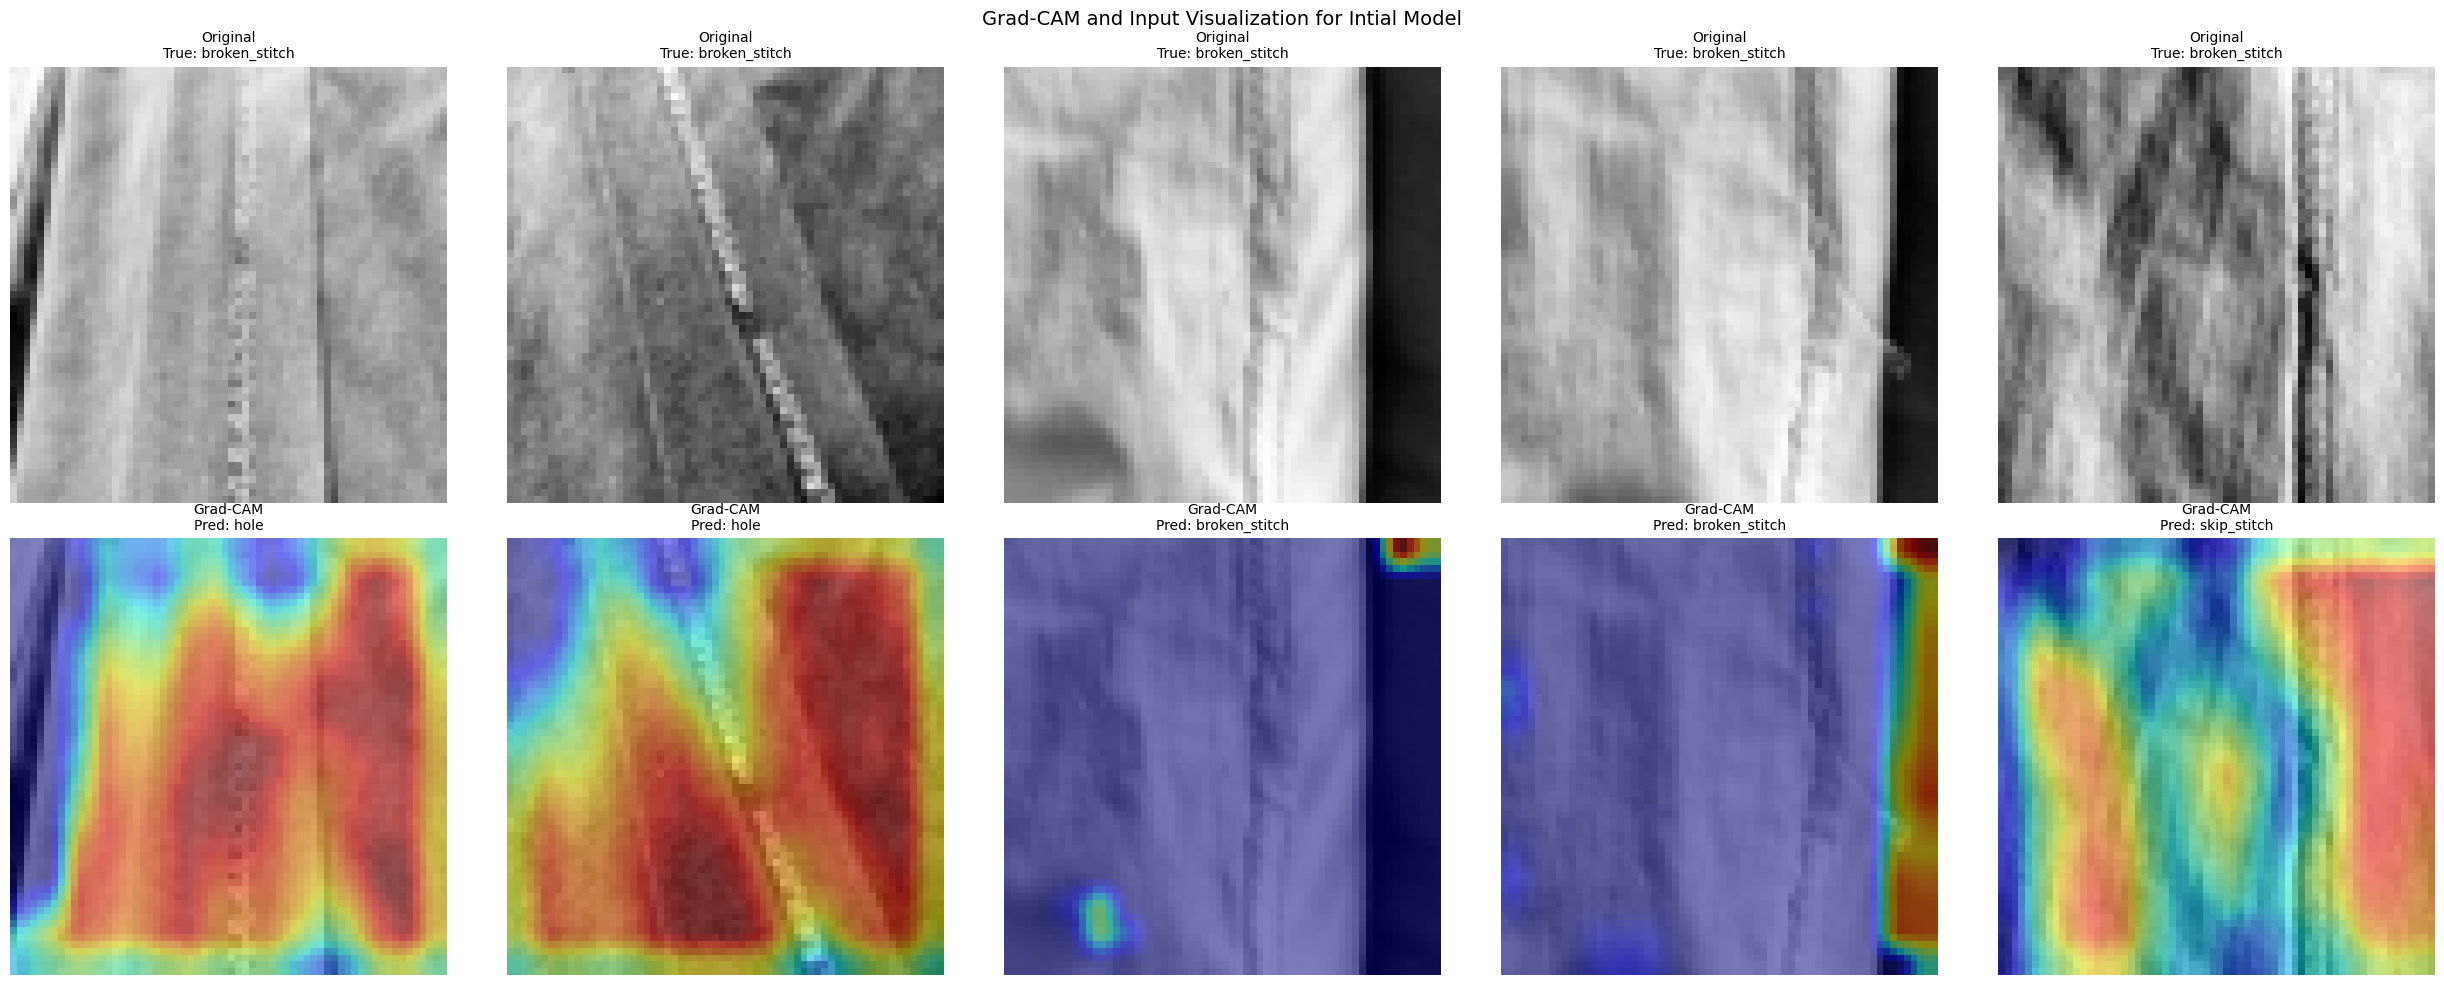


📊 Results for: Improved CNN
   Accuracy  : 83.33%
   Precision : 0.8548
   Recall    : 0.8333
   F1 Score  : 0.8312
   Classification Report:
                precision    recall  f1-score   support

 broken_stitch       0.86      0.67      0.75         9
          hole       0.69      1.00      0.82         9
      raw_edge       0.75      0.86      0.80         7
seam_puckering       1.00      1.00      1.00        10
   skip_stitch       1.00      0.67      0.80         6
  uncut_thread       0.83      0.71      0.77         7

      accuracy                           0.83        48
     macro avg       0.86      0.82      0.82        48
  weighted avg       0.85      0.83      0.83        48



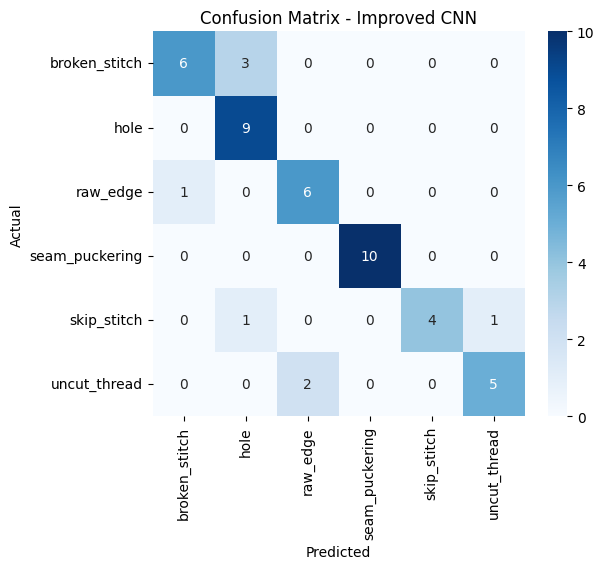


🧠 Grad-CAM Visualizations for Improved CNN


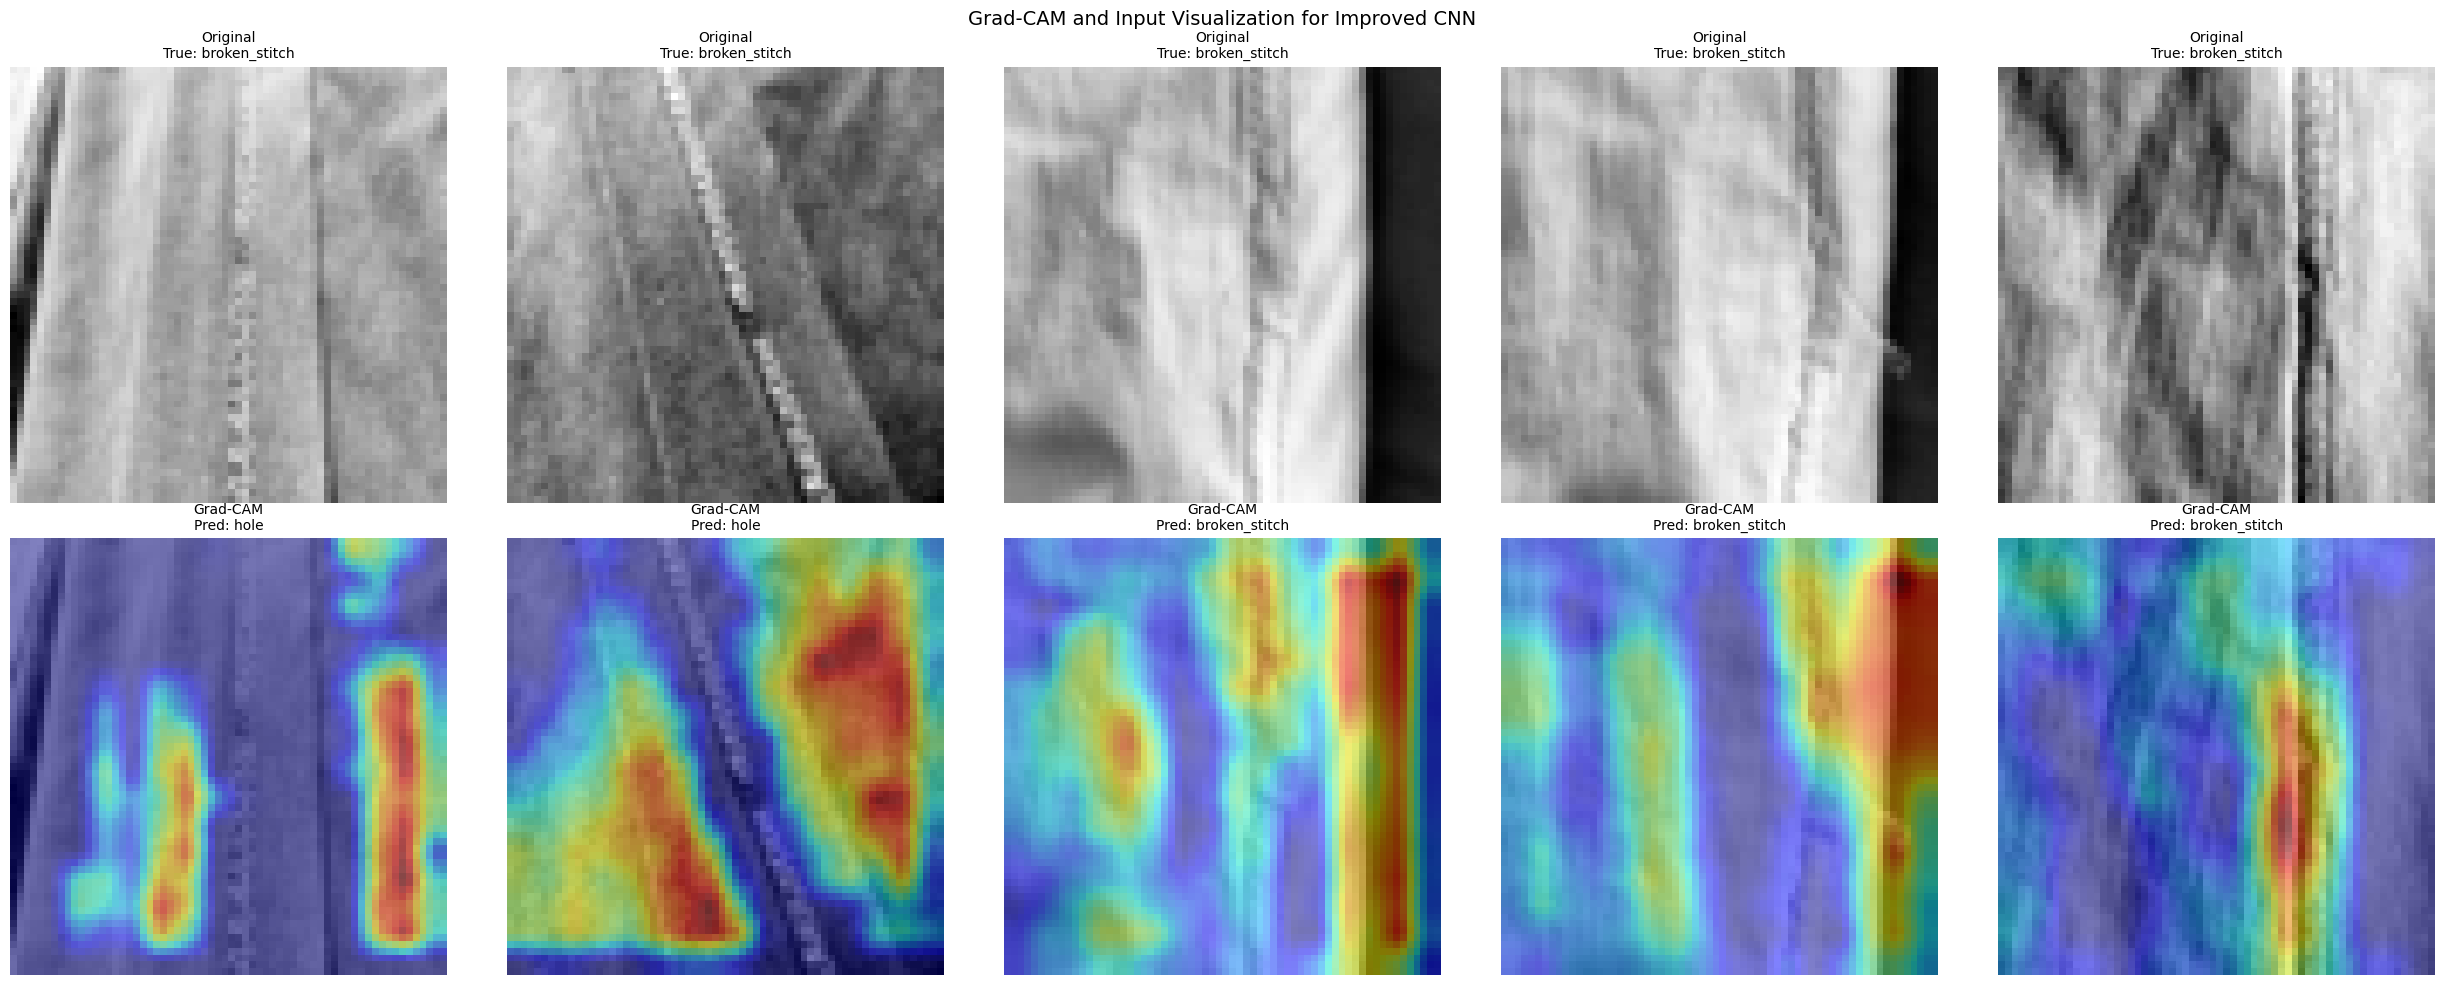


📊 Results for: ResNet18
   Accuracy  : 72.92%
   Precision : 0.7631
   Recall    : 0.7292
   F1 Score  : 0.7279
   Classification Report:
                precision    recall  f1-score   support

 broken_stitch       0.60      0.67      0.63         9
          hole       0.69      1.00      0.82         9
      raw_edge       0.71      0.71      0.71         7
seam_puckering       0.70      0.70      0.70        10
   skip_stitch       1.00      0.67      0.80         6
  uncut_thread       1.00      0.57      0.73         7

      accuracy                           0.73        48
     macro avg       0.78      0.72      0.73        48
  weighted avg       0.76      0.73      0.73        48



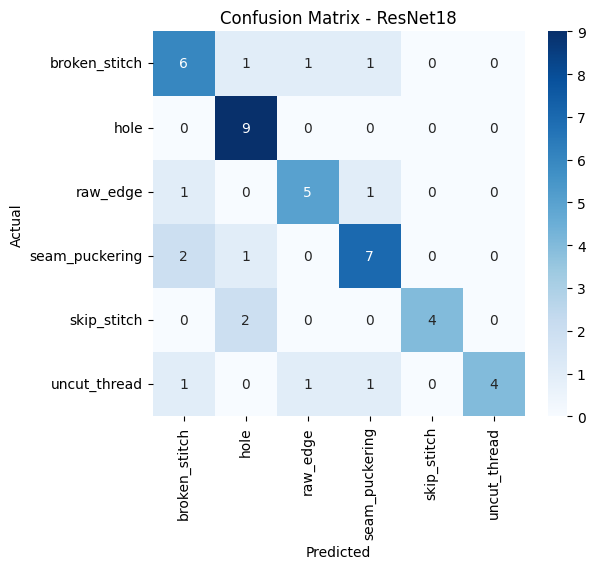


🧠 Grad-CAM Visualizations for ResNet18


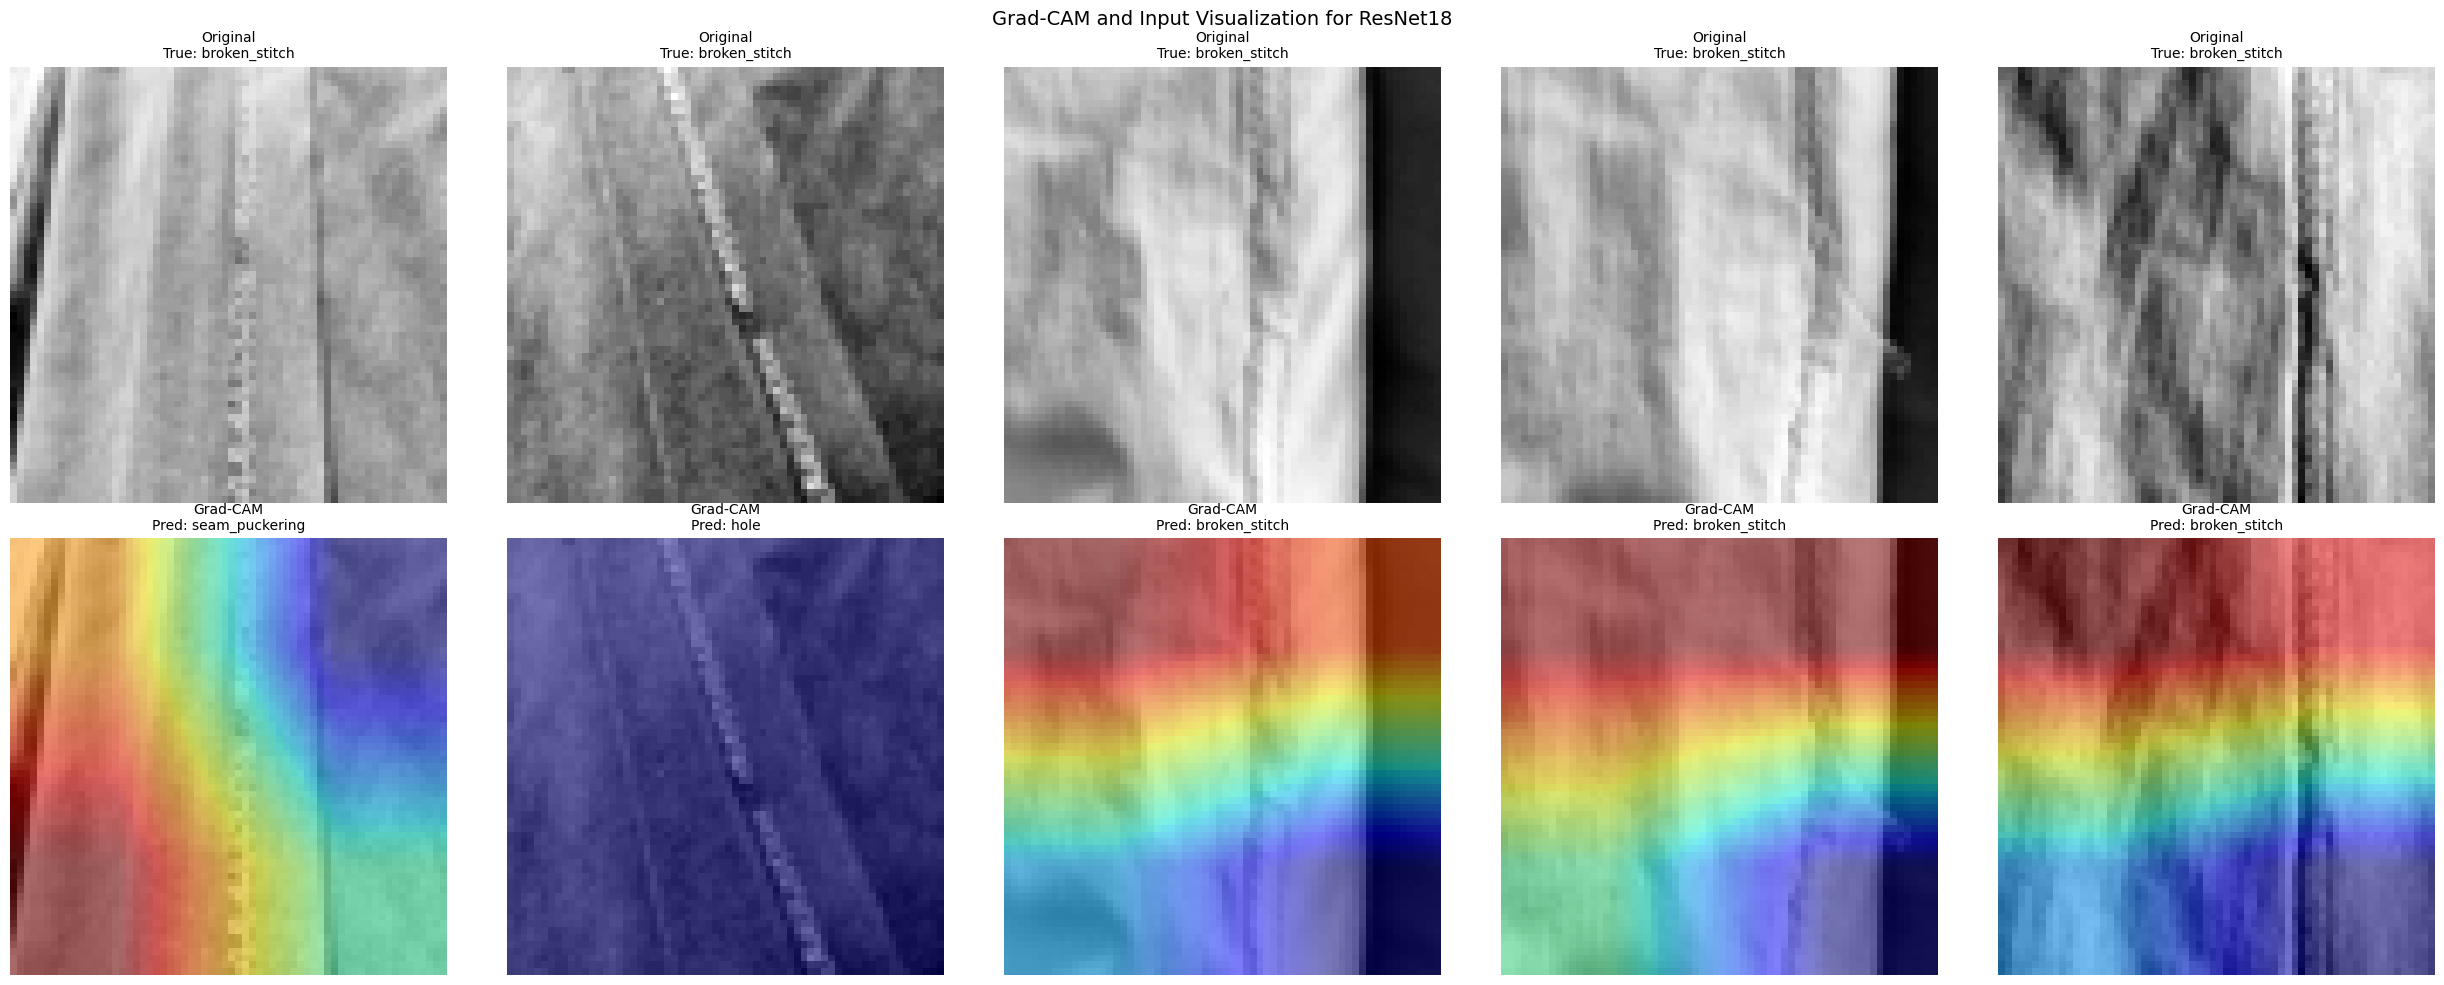


📊 Results for: EfficientNetB0
   Accuracy  : 79.17%
   Precision : 0.7944
   Recall    : 0.7917
   F1 Score  : 0.7869
   Classification Report:
                precision    recall  f1-score   support

 broken_stitch       0.86      0.67      0.75         9
          hole       0.75      1.00      0.86         9
      raw_edge       0.67      0.57      0.62         7
seam_puckering       0.90      0.90      0.90        10
   skip_stitch       0.83      0.83      0.83         6
  uncut_thread       0.71      0.71      0.71         7

      accuracy                           0.79        48
     macro avg       0.79      0.78      0.78        48
  weighted avg       0.79      0.79      0.79        48



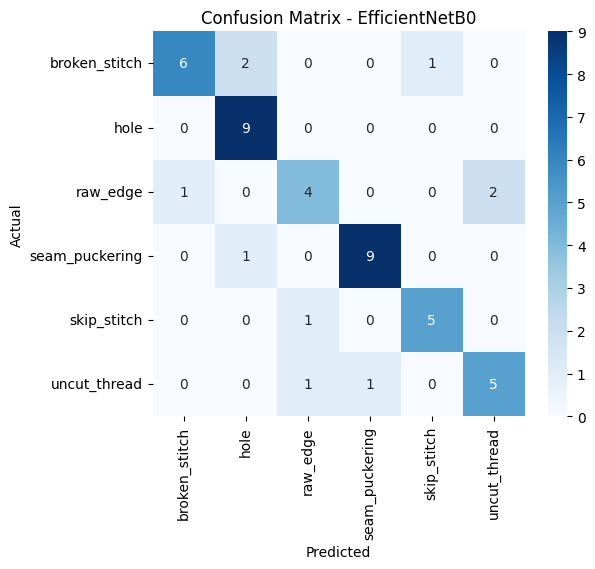


🧠 Grad-CAM Visualizations for EfficientNetB0


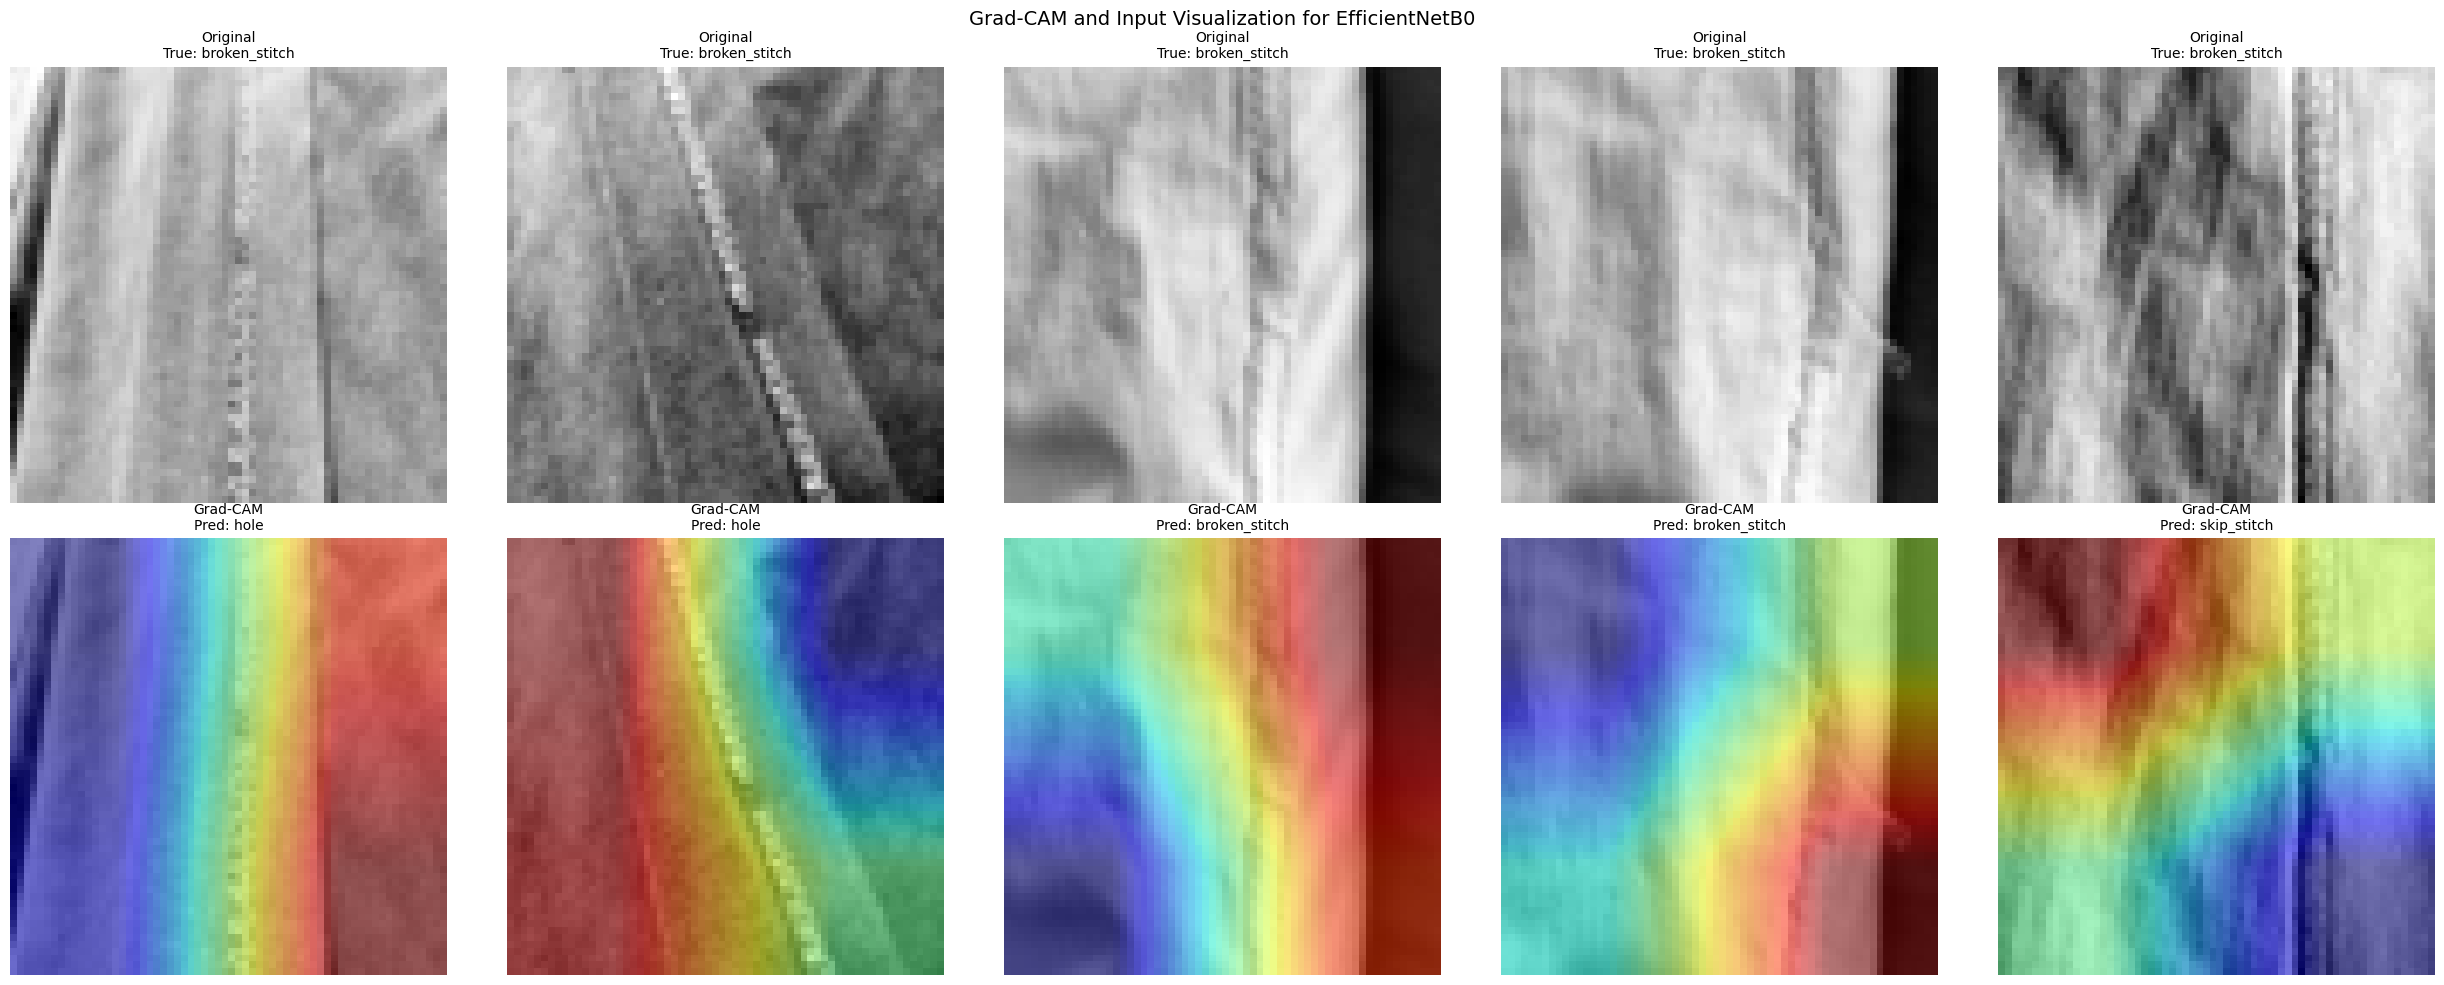

In [ ]:
all_models = [model_intial_model,model_improved, model_resnet, model_efficient]
model_names = ['Intial Model','Improved CNN', 'ResNet18', 'EfficientNetB0']
class_names = ['broken_stitch', 'hole', 'raw_edge', 'seam_puckering', 'skip_stitch', 'uncut_thread']

evaluate_multiple_models_with_gradcam(all_models, model_names, test_loader, class_names, num_samples=5)

# Saving Models


In [ ]:
torch.save(model_intial_model.state_dict(), "cnn_model_mc.pth")
torch.save(model_improved.state_dict(), "improved_cnn_mc.pth")
torch.save(model_efficient.state_dict(), "efficientnet_model_mc.pth")
torch.save(model_resnet.state_dict(), "resnet_model_mc.pth")

In [ ]:
from google.colab import files
files.download("cnn_model_mc.pth")
files.download("improved_cnn_mc.pth")
files.download("efficientnet_model_mc.pth")
files.download("resnet_model_mc.pth")

Saving Seam-Puckering.jpg to Seam-Puckering (1).jpg


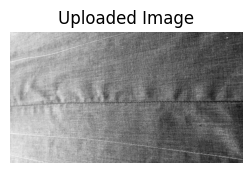

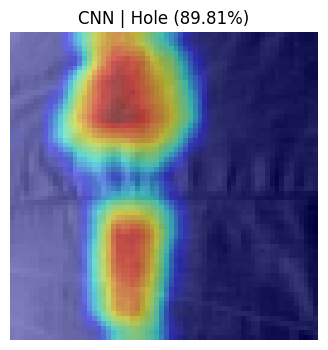

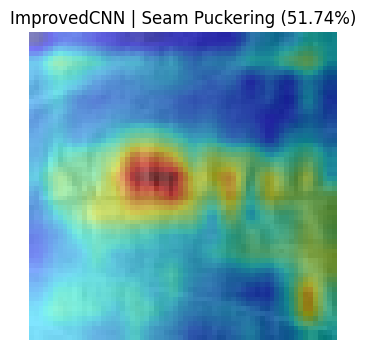

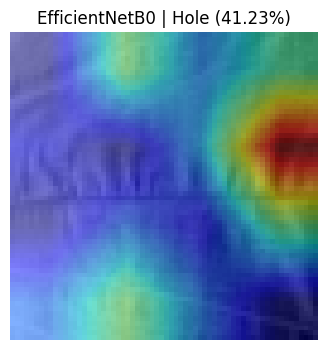

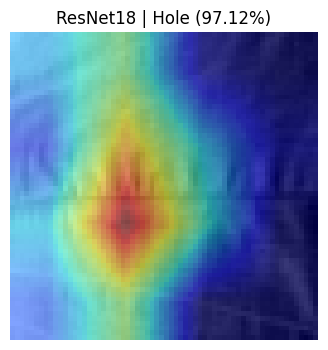


🧾 Multi-Class Model Predictions:

         Model  Predicted Index          Label Confidence
           CNN                1           Hole     89.81%
   ImprovedCNN                3 Seam Puckering     51.74%
EfficientNetB0                1           Hole     41.23%
      ResNet18                1           Hole     97.12%


In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import files

# Upload Image
uploaded = files.upload()
image_path = next(iter(uploaded))

# Preprocessing (must match training)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
image = Image.open(image_path).convert('L')
input_tensor = transform(image).unsqueeze(0)

# Show uploaded image
plt.figure(figsize=(3, 3))
plt.imshow(image, cmap='gray')
plt.title("Uploaded Image")
plt.axis('off')
plt.show()

#  label order
class_labels = [
    "Broken Stitch",     # 0
    "Hole",              # 1
    "Raw Edge",          # 2
    "Seam Puckering",    # 3
    "Skip Stitch",       # 4
    "Uncut Thread"       # 5
]

# Model Definitions
class DefectCNN(nn.Module):
    def __init__(self, num_classes):
        super(DefectCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

class ImprovedDefectCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedDefectCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = x.view(-1, 256 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

def efficientnet_model(num_classes=6):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    model.features[0][0] = nn.Conv2d(1, 32, 3, 2, 1, bias=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

def build_resnet18_model(num_classes=6):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Grad-CAM Utility
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        self.hook_handles.append(
            self.target_layer.register_forward_hook(lambda m, i, o: setattr(self, 'activations', o))
        )
        self.hook_handles.append(
            self.target_layer.register_full_backward_hook(lambda m, gin, gout: setattr(self, 'gradients', gout[0]))
        )

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output)
        output[:, class_idx].backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = F.relu(cam)
        cam -= cam.min()
        cam /= cam.max()
        return cam.detach().cpu().numpy()

    def remove_hooks(self):
        for h in self.hook_handles:
            h.remove()

# Show CAM Overlay
def show_cam_on_image(img_tensor, cam, title=""):
    cam_resized = Image.fromarray(np.uint8(cam * 255)).resize((64, 64), resample=Image.BILINEAR)
    plt.figure(figsize=(4, 4))
    plt.imshow(img_tensor.squeeze().numpy(), cmap='gray')
    plt.imshow(cam_resized, cmap='jet', alpha=0.5)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Model Metadata
models_info = {
    "CNN": {
        "model": DefectCNN(num_classes=6),
        "path": "cnn_model_mc.pth",
        "target": "conv3"
    },
    "ImprovedCNN": {
        "model": ImprovedDefectCNN(num_classes=6),
        "path": "improved_cnn_mc.pth",
        "target": "conv3"
    },
    "EfficientNetB0": {
        "model": efficientnet_model(num_classes=6),
        "path": "efficientnet_model_mc.pth",
        "target": "features.4.0"
    },
    "ResNet18": {
        "model": build_resnet18_model(num_classes=6),
        "path": "resnet_model_mc.pth",
        "target": "layer3.1.conv2"
    }
}

# Run models and display predictions
results = []

for name, info in models_info.items():
    model = info["model"]
    model.load_state_dict(torch.load(info["path"], map_location="cpu"))
    model.eval()

    target_layer = dict(model.named_modules())[info["target"]]
    cam_generator = GradCAM(model, target_layer)
    cam = cam_generator.generate(input_tensor)
    cam_generator.remove_hooks()

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_idx].item()
        pred_label = class_labels[pred_idx]

    show_cam_on_image(input_tensor, cam, title=f"{name} | {pred_label} ({confidence:.2%})")

    results.append({
        "Model": name,
        "Predicted Index": pred_idx,
        "Label": pred_label,
        "Confidence": f"{confidence:.2%}"
    })

# Display prediction table
df = pd.DataFrame(results)
print("\n🧾 Multi-Class Model Predictions:\n")
print(df.to_string(index=False))
